<a href="https://colab.research.google.com/github/mae25-create/data_visualization-analysis_practice/blob/main/Restaurants_%26_Items_in_NYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Constructing the set, dropdowns and functions

In [ ]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import features
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

import seaborn


In [ ]:
#Reading files

df_items = pd.read_pickle('items.pickle')
df_restaurants = pd.read_pickle('restaurants.pickle')
df_orders = pd.read_pickle('orders.pickle')
df_orders_7 = pd.read_pickle('orders_7.pickle')
df_summarized_orders = pd.read_pickle('summarized_orders.pickle')

#additional source of data about restaurants and bars concentration in New York. MAKE SURE TO UPLOAD THE EXTRA DATABASE INTO COLAB
bars = pd.read_csv('bar_locations.csv')


In [ ]:
# Merge df_orders_7 and df_restaurants

df_orders_7_restaurants = pd.merge(
                      df_orders_7, df_restaurants, on='RESTAURANT_ID')

In [ ]:
# Create my global varibles for restaurant, timeframe and delivery filters
rest_name = None
time_sel = None
deliv_sel = None
rest_name1 = None
time_sel1 = None

In [ ]:
# Cleaning process: Identify null orders
# add VALID_ORDER column to df_orders_7_restaurants / Anthropic. (2025, May 20). Python code for identifying valid restaurant orders using row-wise operations [Source code]. Claude 3.7 Sonnet. https://claude.ai
def add_valid_order_flag():
    global df_orders_7_restaurants

    # Function to check if a row contains at least one valid item
    def has_valid_items(row):
        # Check drinks
        has_drinks = not pd.isna(row['DRINKS']) and row['DRINKS'] != 0

        # Check cookies
        has_cookies = not pd.isna(row['COOKIES']) and row['COOKIES'] != 0

        # Check main, base, side_1, side_2
        has_main = not pd.isna(row['MAIN'])
        has_base = not pd.isna(row['BASE'])
        has_side1 = not pd.isna(row['SIDE_1'])
        has_side2 = not pd.isna(row['SIDE_2'])

        # Order is valid if it has at least one valid item
        return 1 if (has_drinks or has_cookies or has_main or has_base or has_side1 or has_side2) else 0

    # Apply the function to each row
    df_orders_7_restaurants['VALID_ORDER'] = df_orders_7_restaurants.apply(has_valid_items, axis=1)

    # Count valid and invalid orders
    valid_count = df_orders_7_restaurants['VALID_ORDER'].sum()
    invalid_count = len(df_orders_7_restaurants) - valid_count

    print(f"Total orders: {len(df_orders_7_restaurants)}")
    print(f"Valid orders: {valid_count} ({valid_count/len(df_orders_7_restaurants):.2%})")
    print(f"Invalid orders: {invalid_count} ({invalid_count/len(df_orders_7_restaurants):.2%})")

    # Show example of valid and invalid orders
    print("\nExample of invalid orders (VALID_ORDER = 0):")
    print(df_orders_7_restaurants[df_orders_7_restaurants['VALID_ORDER'] == 0][['ORDER_ID', 'DRINKS', 'COOKIES', 'MAIN', 'BASE', 'SIDE_1', 'SIDE_2', 'VALID_ORDER']].head())

    print("\nExample of valid orders (VALID_ORDER = 1):")
    print(df_orders_7_restaurants[df_orders_7_restaurants['VALID_ORDER'] == 1][['ORDER_ID', 'DRINKS', 'COOKIES', 'MAIN', 'BASE', 'SIDE_1', 'SIDE_2', 'VALID_ORDER']].head())

    return df_orders_7_restaurants

# Add the VALID_ORDER column
df_orders_7_restaurants = add_valid_order_flag()

Total orders: 2387224
Valid orders: 2338119 (97.94%)
Invalid orders: 49105 (2.06%)

Example of invalid orders (VALID_ORDER = 0):
     ORDER_ID  DRINKS  COOKIES MAIN BASE SIDE_1 SIDE_2  VALID_ORDER
1    O1011112     0.0      0.0  NaN  NaN    NaN    NaN            0
34    O820959     0.0      0.0  NaN  NaN    NaN    NaN            0
49     O96314     0.0      0.0  NaN  NaN    NaN    NaN            0
82    O296431     0.0      0.0  NaN  NaN    NaN    NaN            0
140  O1008676     0.0      0.0  NaN  NaN    NaN    NaN            0

Example of valid orders (VALID_ORDER = 1):
   ORDER_ID  DRINKS  COOKIES MAIN BASE SIDE_1 SIDE_2  VALID_ORDER
0  O1820060     1.0      2.0  NaN  NaN    NaN    NaN            1
2   O752854     0.0      2.0   I0   I7    I15    I14            1
3  O2076864     1.0      0.0   I0   I5     I9    I12            1
4  O1988898     0.0      0.0   I1   I7     I9     I9            1
5  O1026484     1.0      0.0  NaN  NaN    NaN    NaN            1


In [ ]:
# Create a map for .resample and filter timeframe
resample_map = {
    "Daily": "D",
    "Weekly": "W",
    "Monthly": "ME"
}

In [ ]:
# Create dropdown for orders
restaurant_list = ['All Restaurants'] + sorted(df_restaurants['NAME'].unique().tolist())

dropdown_rest = widgets.Dropdown(
    options=restaurant_list,
    description='Restaurant:',
    disabled=False,
)
display(dropdown_rest)

# Create dropdown for Timeframes
time_list = ['Daily', 'Weekly', 'Monthly']

dropdown_time = widgets.Dropdown(
    options=time_list,
    description='TimeFrame:',
    disabled=False,
)
display(dropdown_time)

# Create dropdown for Type of Delivery
delivery_list = ['ALL'] + sorted(df_orders_7_restaurants['TYPE'].unique().tolist())

dropdown_deli = widgets.Dropdown(
    options=delivery_list,
    description='Delivery:',
    disabled=False,
)
display(dropdown_deli)

Dropdown(description='Restaurant:', options=('All Restaurants', 'Bryant Park', 'Columbia', 'Flatiron', 'Midtow…

Dropdown(description='TimeFrame:', options=('Daily', 'Weekly', 'Monthly'), value='Daily')

Dropdown(description='Delivery:', options=('ALL', 'DELIVERY', 'IN_STORE', 'PICKUP'), value='ALL')

In [ ]:
# Create dropdown for type of deliveries
restaurant_list = ['All Restaurants'] + sorted(df_restaurants['NAME'].unique().tolist())

dropdown_rest_1 = widgets.Dropdown(
    options=restaurant_list,
    description='Restaurant:',
    disabled=False,
)
display(dropdown_rest_1)

# Create dropdown for Timeframes
time_list = ['Daily', 'Weekly', 'Monthly']

dropdown_time_1 = widgets.Dropdown(
    options=time_list,
    description='TimeFrame:',
    disabled=False,
)
display(dropdown_time_1)

Dropdown(description='Restaurant:', options=('All Restaurants', 'Bryant Park', 'Columbia', 'Flatiron', 'Midtow…

Dropdown(description='TimeFrame:', options=('Daily', 'Weekly', 'Monthly'), value='Daily')

In [ ]:
# Function to filter and plot
def filter_and_plot():
    global rest_name, time_sel, deliv_sel

    # Base DataFrame
    df_filtered = df_orders_7_restaurants.copy()

    # Delivery filter
    if deliv_sel != 'ALL':
        df_filtered = df_filtered[df_filtered['TYPE'] == deliv_sel]

    # Convert datetime and set index
    df_filtered['DATETIME'] = pd.to_datetime(df_filtered['DATETIME'])
    df_filtered.set_index('DATETIME', inplace=True)

    # Resampling based on timeframe
    resample_code = resample_map.get(time_sel, 'D')

    if rest_name and rest_name != 'All Restaurants':
        # Filter for a specific restaurant
        rest_id = df_orders_7_restaurants[df_orders_7_restaurants['NAME'] == rest_name]['RESTAURANT_ID'].iloc[0]
        df_filtered = df_filtered[df_filtered['RESTAURANT_ID'] == rest_id]

        # Resample and plot
        df_plot = df_filtered.resample(resample_code).size()
        df_plot.plot(figsize=(12, 6), label=rest_name)
    else:
        # Plot all restaurants separately
        plt.figure(figsize=(12, 6))
        for name, group in df_filtered.groupby('NAME'):
            df_plot = group.resample(resample_code).size()
            plt.plot(df_plot.index, df_plot.values, label=name)

    plt.title('Orders per Restaurant')
    plt.xlabel(time_sel)
    plt.ylabel('Number of Orders')
    plt.legend(title='NAME')
    plt.tight_layout()
    plt.show()


In [ ]:
# Function to filter and plot Pie chart
def filter_and_plot_pie():
    global rest_name1, time_sel1

    # Start with full dataset
    df_filtered = df_orders_7_restaurants.copy()

    # Filter by restaurant
    if rest_name1 and rest_name1.strip().lower() != 'all restaurants':
        title_rest = rest_name1.strip()
        rest_id = df_orders_7_restaurants[df_orders_7_restaurants['NAME'] == rest_name1]['RESTAURANT_ID'].iloc[0]
        df_filtered = df_filtered[df_filtered['RESTAURANT_ID'] == rest_id]
    else:
        title_rest = "All Restaurants"


    # Ensure DATETIME is datetime type and set as index
    df_filtered['DATETIME'] = pd.to_datetime(df_filtered['DATETIME'], errors='coerce')
    df_filtered = df_filtered.dropna(subset=['DATETIME'])
    df_filtered = df_filtered.set_index('DATETIME')

    # Resample mapping
    resample_code = resample_map.get(time_sel1, 'D')

    # Group by time frame and count order types
    try:
        df_grouped = df_filtered.resample(resample_code)['TYPE'].value_counts().unstack().fillna(0)
        delivery_type_counts = df_grouped.sum()
    except Exception as e:
        print("Error while processing data:", e)
        return

    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(delivery_type_counts, labels=delivery_type_counts.index,
            autopct='%1.1f%%', startangle=90)
    plt.title(f'Proportion of Order Types – {title_rest}')
    plt.legend(title='NAME')
    plt.axis('equal')
    plt.show()


In [ ]:
# Function to use the selected Restaurant, timeframe and delivery

def plot_selected_orders_by_restaurant(change):
    global rest_name, time_sel, deliv_sel
    rest_name = dropdown_rest.value
    time_sel = dropdown_time.value
    deliv_sel = dropdown_deli.value

    clear_output(wait=True)  # Clear previous output
    display(dropdown_rest,dropdown_time, dropdown_deli)
    filter_and_plot()

In [ ]:
# Function to use the selected Restaurant, timeframe and plot a Piechart

def plot_selected_delivery_by_restaurant(change):
    global rest_name1, time_sel1
    rest_name1 = dropdown_rest_1.value
    time_sel1 = dropdown_time_1.value

    clear_output(wait=True)
    display(dropdown_rest_1, dropdown_time_1)
    filter_and_plot_pie()

# 2. Restaurants

## 2.1 Heat Map

In [ ]:
bars.head()

Location Type  Incident Zip           City        Borough   Latitude  \
0  Club/Bar/Restaurant       10308.0  STATEN ISLAND  STATEN ISLAND  40.544096   
1  Club/Bar/Restaurant       10012.0       NEW YORK      MANHATTAN  40.729793   
2  Club/Bar/Restaurant       10308.0  STATEN ISLAND  STATEN ISLAND  40.544209   
3  Club/Bar/Restaurant       10034.0       NEW YORK      MANHATTAN  40.866376   
4  Club/Bar/Restaurant       11220.0       BROOKLYN       BROOKLYN  40.635207   

   Longitude  num_calls  
0 -74.141155         40  
1 -73.998842         18  
2 -74.141040         21  
3 -73.928258        160  
4 -74.020285         17

In [ ]:
#Based on the restaurants and bar concentration in New York City we mapped the location of the restaurants to identify the reaturant with the highest nnumber of orders.

# Re-create orders_per_location DataFrame within this cell
orders_per_location = df_orders_7_restaurants.groupby(['RESTAURANT_ID', 'LAT', 'LONG', 'RESTAURANT_NAME']).size().reset_index(name='Number_of_Orders')

#here we are using a new library called folium. We will compare the exiting map in the "Heatmap of pubs and bars of New York City" (Vasilev,2016)
# Create the base map, centered around the bar locations for consistency with the original heatmap
rest_map = folium.Map(location=[40.742459, -73.971765], zoom_start=12)

# Add the heatmap of bar locations
bar_data = [[x[0], x[1], 1] for x in np.array(bars[['Latitude', 'Longitude']])]
HeatMap(bar_data, radius=20).add_to(rest_map)

# Add the restaurant locations as CircleMarkers
for index, row in orders_per_location.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LONG']],
        radius=row['Number_of_Orders'] * 0.00008, # Adjust radius based on the number of orders
        popup=f"Restaurant Name: {row['RESTAURANT_NAME']}<br>Restaurant ID: {row['RESTAURANT_ID']}<br>Orders: {row['Number_of_Orders']}",
        color='navy',
        fill=True,
        fill_color='blue'
    ).add_to(rest_map)

# Display the map with both layers
rest_map

# Google. (2025). Gemini (May 17 version) [Large language model].
# Vasilev. E. (n.d.). Heatmap of pubs and bars of New York City [Computer software]. Kaggle. https://www.kaggle.com/code/somesnm/heatmap-of-pubs-and-bars-of-new-york-city
# Vasilev. E. (n.d.). 2016 Parties in New York [Data set]. Kaggle. https://www.kaggle.com/datasets/somesnm/partynyc


In [ ]:
#In the previous map we see that the restaurants located in the crowded areas like NYU, Williamsburg and Midtown, have a hiher number of sales than the restaurants located in the less crowded areas.


## 2.2 Bubble Map

In [ ]:
df_orders_7_restaurants['MAIN_V2'] = df_orders_7_restaurants['MAIN'].notna().astype(int)
df_orders_7_restaurants['BASE_V2'] = df_orders_7_restaurants['BASE'].notna().astype(int)
df_orders_7_restaurants['SIDE1_V2'] = df_orders_7_restaurants['SIDE_1'].notna().astype(int)
df_orders_7_restaurants['SIDE2_V2'] = df_orders_7_restaurants['SIDE_2'].notna().astype(int)
df_orders_7_restaurants['TOTAL_ITEMS'] = df_orders_7_restaurants['DRINKS'] + df_orders_7_restaurants['COOKIES'] + df_orders_7_restaurants['MAIN_V2']+ df_orders_7_restaurants['BASE_V2']+ df_orders_7_restaurants['SIDE1_V2']+ df_orders_7_restaurants['SIDE2_V2']

In [ ]:
# Calculate total items and total orders per restaurant
restaurant_summary = df_orders_7_restaurants.groupby('NAME').agg(
    total_items=('TOTAL_ITEMS', 'sum'),
    total_orders=('ORDER_ID', 'nunique') # Count unique ORDER_IDs for total orders
).reset_index()

# Calculate the average items per order per restaurant
# Avoid division by zero if a restaurant has no orders
restaurant_summary['average_items_per_order'] = restaurant_summary.apply(
    lambda row: row['total_items'] / row['total_orders'] if row['total_orders'] > 0 else 0,
    axis=1
)

print("Average Total Items and Total Orders per Restaurant:")
restaurant_summary

Average Total Items and Total Orders per Restaurant:


NAME  total_items  total_orders  average_items_per_order
0      Bryant Park     948819.0        227445                 4.171641
1         Columbia    1039293.0        250810                 4.143746
2         Flatiron    1176247.0        281983                 4.171340
3          Midtown    1363824.0        325265                 4.192963
4              NYU    1789207.0        430860                 4.152641
5  Upper East Side    1151159.0        275001                 4.186018
6  Upper West Side    1172618.0        281186                 4.170257
7     Williamsburg    1311059.0        314674                 4.166404

In [ ]:
# Create a bubble chart
# We can use Plotly Express for an interactive bubble chart
# 'average_items_per_order' for the x-axis,
# 'total_orders' for the y-axis
# size the bubbles by 'total_items'

import plotly.express as px

fig = px.scatter(restaurant_summary,
                 x="average_items_per_order",
                 y="total_orders",
                 size="total_items",
                 color="NAME",  # Color by restaurant name
                 hover_name="NAME",
                 log_x=True,    # Use logarithmic scale for x-axis if average items per order varies a lot
                 size_max=60,   # Max size of the bubbles
                 title="Bubble Chart of Restaurants" # Changed title here
                )

fig.update_layout(
    xaxis_title="Average Items per Order", # Changed x-axis label here
    yaxis_title="Total Orders"             # Changed y-axis label here
)

fig.show()

## 2.3 Rank Restaurants

Dropdown(description='Restaurant:', options=('All Restaurants', 'Bryant Park', 'Columbia', 'Flatiron', 'Midtow…

Dropdown(description='TimeFrame:', index=1, options=('Daily', 'Weekly', 'Monthly'), value='Weekly')

Dropdown(description='Delivery:', options=('ALL', 'DELIVERY', 'IN_STORE', 'PICKUP'), value='ALL')

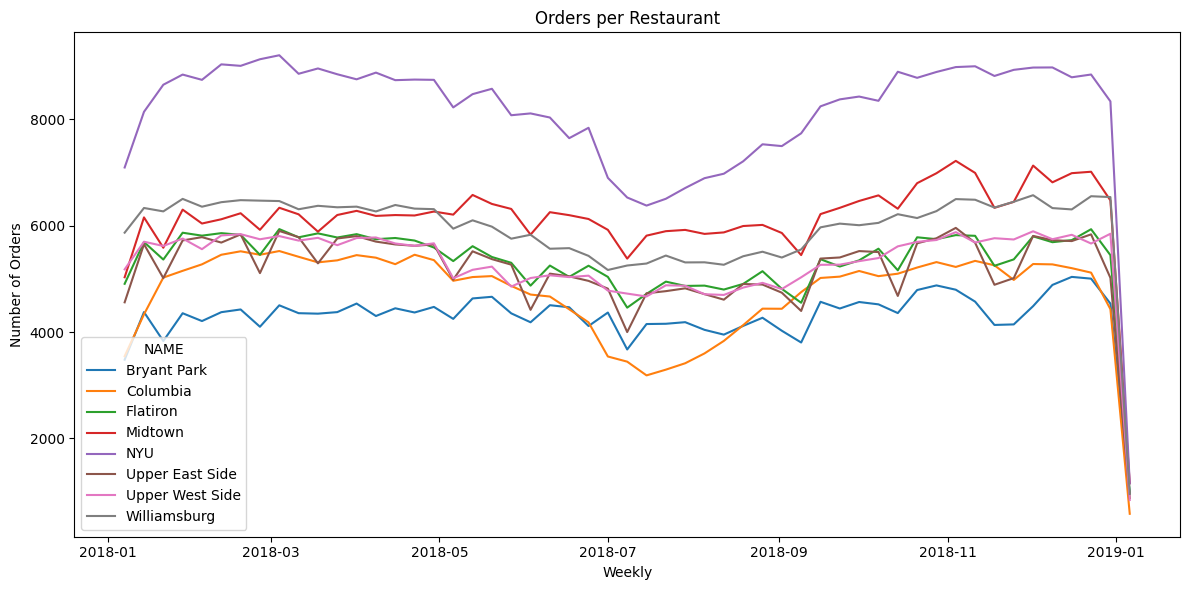

In [ ]:
display(dropdown_rest, dropdown_time, dropdown_deli)

# call the functions to the dropdown
dropdown_rest.observe(plot_selected_orders_by_restaurant, names='value')
dropdown_time.observe(plot_selected_orders_by_restaurant, names='value')
dropdown_deli.observe(plot_selected_orders_by_restaurant, names='value')


##2.4 Peak Hours

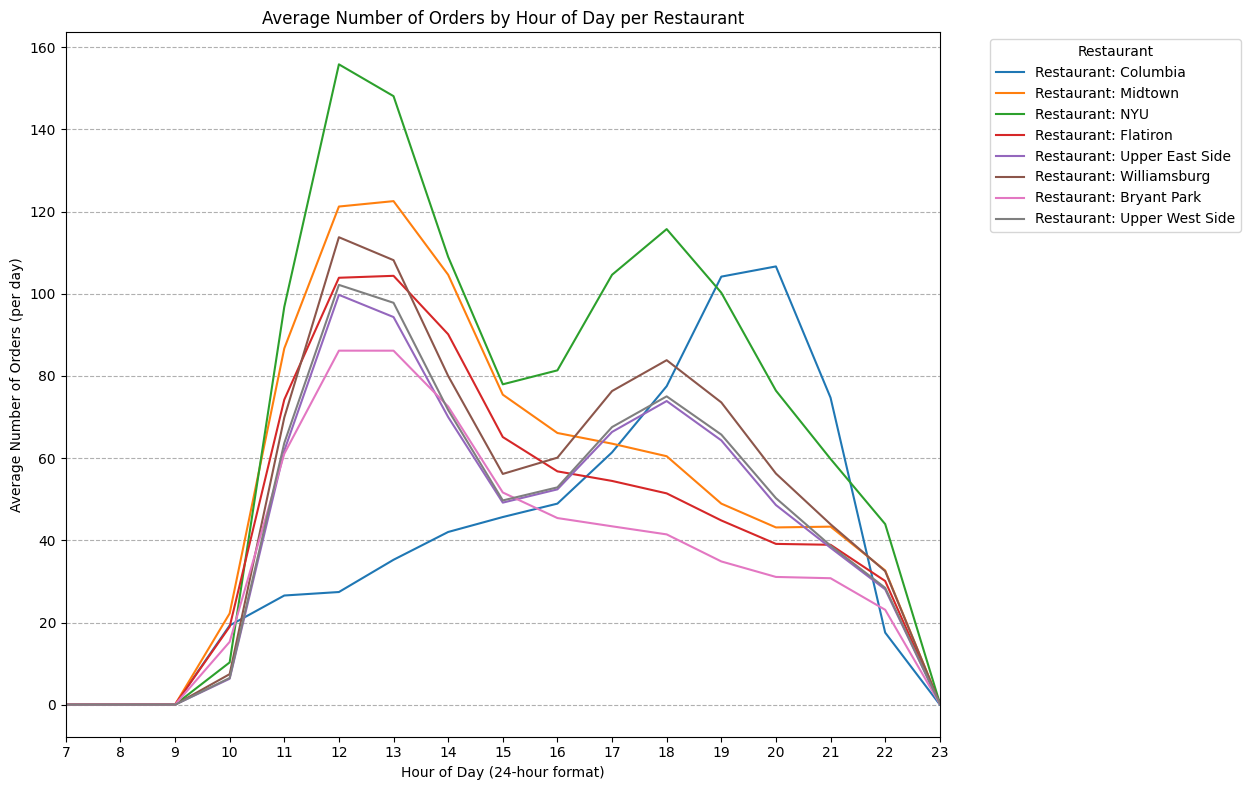

In [ ]:
#⁠hour # Orders Graph by restaurant for all restuarants
# Ensure the 'DATETIME' column is in datetime format
df_orders_7_restaurants['DATETIME'] = pd.to_datetime(df_orders_7_restaurants['DATETIME'])

# Extract the hour of the day
df_orders_7_restaurants['ORDER_HOUR'] = df_orders_7_restaurants['DATETIME'].dt.hour

# Find the number of unique days in the dataset (needed for averaging)
number_of_days = df_orders_7_restaurants['DATETIME'].dt.date.nunique()

# Group by hour, restaurant ID, and restaurant name, then count orders
# We need RESTAURANT_NAME to be part of the grouping to access it easily for the plot label
orders_by_hour_restaurant = df_orders_7_restaurants.groupby(['ORDER_HOUR', 'RESTAURANT_ID', 'RESTAURANT_NAME']).size().reset_index(name='Total_Orders')

# Calculate average orders per hour per restaurant
orders_by_hour_restaurant['Average_Orders'] = orders_by_hour_restaurant['Total_Orders'] / number_of_days

# Get unique restaurant IDs and Names for plotting
# It's better to get unique combinations from the grouped data to ensure we only plot restaurants that have orders
restaurant_info = orders_by_hour_restaurant[['RESTAURANT_ID', 'RESTAURANT_NAME']].drop_duplicates()

plt.figure(figsize=(15, 8)) # Adjust figure size as needed

# Plot a line for each restaurant
for index, row in restaurant_info.iterrows():
    restaurant_id = row['RESTAURANT_ID'] # corrected column name
    restaurant_name = row['RESTAURANT_NAME']
    # Filter data for the current restaurant ID
    restaurant_data = orders_by_hour_restaurant[orders_by_hour_restaurant['RESTAURANT_ID'] == restaurant_id]

    # Ensure all hours from 0 to 23 are present for a complete line plot, filling missing values with 0
    restaurant_data = restaurant_data.set_index('ORDER_HOUR').reindex(range(24), fill_value=0).reset_index()
    restaurant_data = restaurant_data.rename(columns={'index': 'ORDER_HOUR'})

    # Plot the average orders per hour for this restaurant using the restaurant name in the label
    plt.plot(restaurant_data['ORDER_HOUR'], restaurant_data['Average_Orders'], label=f'Restaurant: {restaurant_name}')

plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Average Number of Orders (per day)')
plt.title('Average Number of Orders by Hour of Day per Restaurant')
plt.xticks(range(24)) # Set x-axis ticks to be the hours 0-23
plt.xlim(7, 23) # Set the x-axis range to start from hour 7 and go up to 23
plt.grid(axis='y', linestyle='--') # Add a grid for better readability
plt.legend(title='Restaurant', bbox_to_anchor=(1.05, 1), loc='upper left') # Add legend outside the plot
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend
plt.show()

In [ ]:
#The peak hours for most of the restaurants are at lunch time from 11 am to 3 pm and dinner time from 5 pm to 8 pm. However the restaurant located at Columbia has only one peak hour at dinner from 6 pm  until 9 pm.
#For that reason we suggest to open this restaurant only for dinner and reduce cost of the operation. The restaurant ca also use happy hour discounts to promote consumpton at low peak ties like form 3 pm to 5 pm.

## 2.5 Types of Delivery by Restaurant

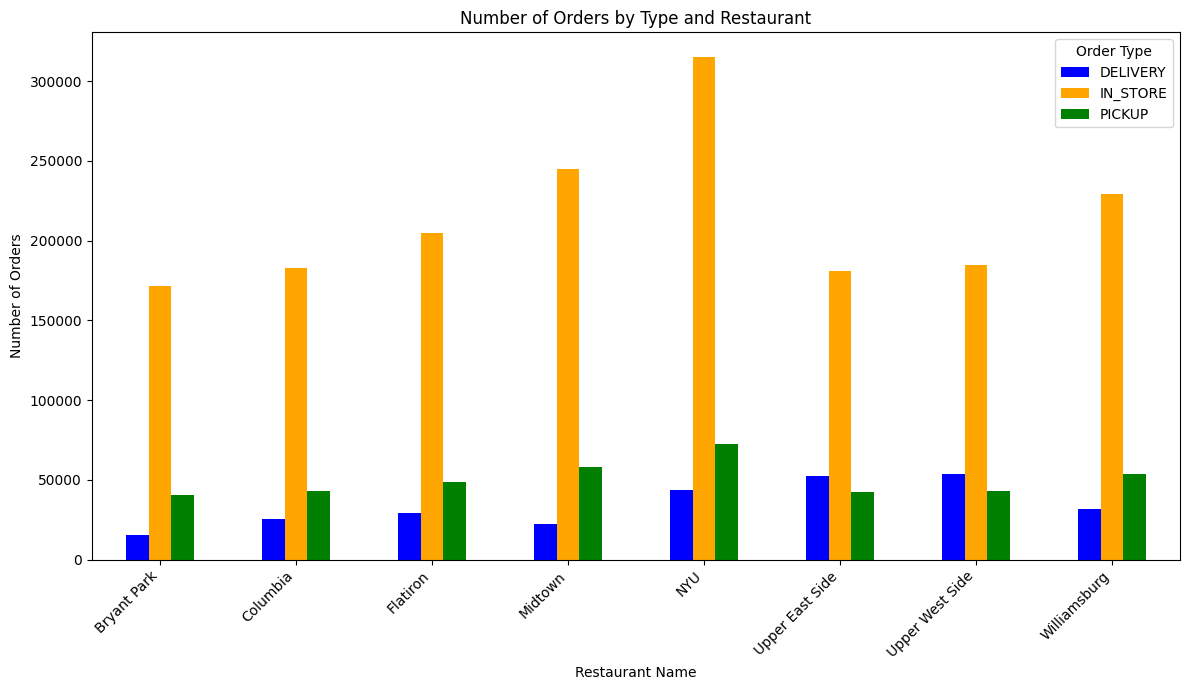

In [ ]:
# Group by restaurant name and delivery type, count the occurrences of each type
df_type_by_restaurant = df_orders_7_restaurants.groupby(['NAME','TYPE']).size().unstack()

# Define the desired colors for each type
colors = ['blue', 'orange', 'green']

# Plot the relationship between TYPE of order and restaurant
df_type_by_restaurant.plot(kind='bar', figsize=(12, 7), color=colors)

plt.title('Number of Orders by Type and Restaurant')
plt.xlabel('Restaurant Name')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Order Type')
plt.tight_layout()
plt.show()

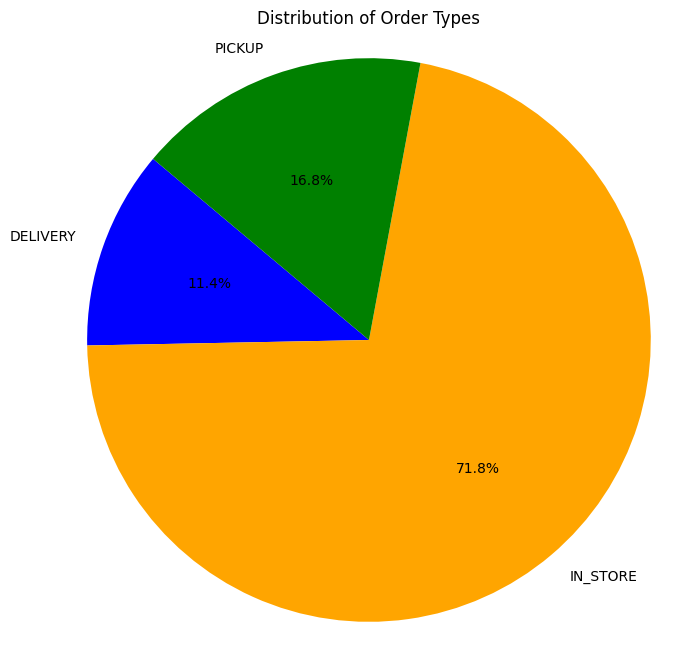

In [ ]:
# Create a pie chart for 3 types of delivery

# Count the occurrences of each 'TYPE'
delivery_type_counts = df_orders_7_restaurants['TYPE'].value_counts()

# Define colors for each type
colors = {'IN_STORE': 'orange', 'PICKUP': 'green', 'DELIVERY': 'blue'}

# Sort the index to ensure consistent color mapping if the order changes
delivery_type_counts = delivery_type_counts.sort_index()
labels = delivery_type_counts.index
sizes = delivery_type_counts.values
pie_colors = [colors[label] for label in labels]


# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=pie_colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Order Types')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

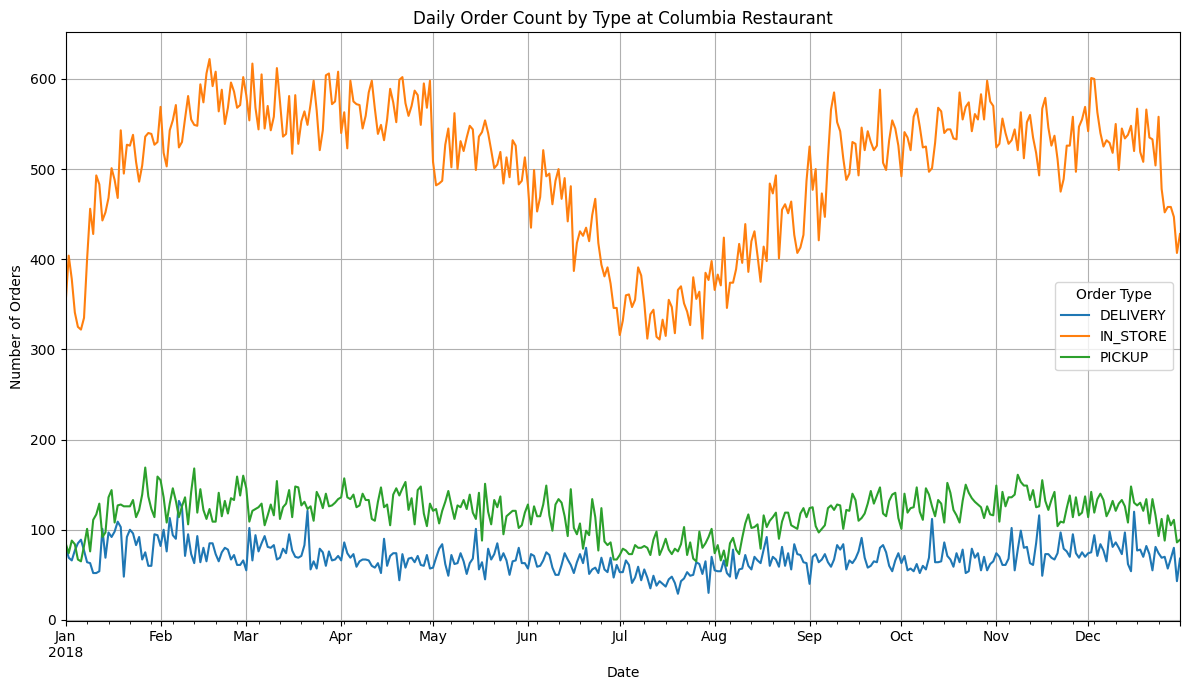

In [ ]:
# Comparison of daily‐order time series ​

# orders volume of 3 delivery types in Colombia restaurant in 1 year

df_columbia = df_orders[df_orders_7_restaurants.NAME == 'Columbia'].copy()

df_columbia['DATETIME'] = pd.to_datetime(df_columbia['DATETIME'])
df_columbia.set_index('DATETIME', inplace=True)

columbia_orders_by_type_day = df_columbia.groupby('TYPE').resample('D').size().unstack(level=0)
columbia_orders_by_type_day = columbia_orders_by_type_day.fillna(0)

# Plot the results as a line chart
columbia_orders_by_type_day.plot(kind='line', figsize=(12, 7))

plt.title('Daily Order Count by Type at Columbia Restaurant')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend(title='Order Type')
plt.grid(True)
plt.tight_layout()
plt.show()

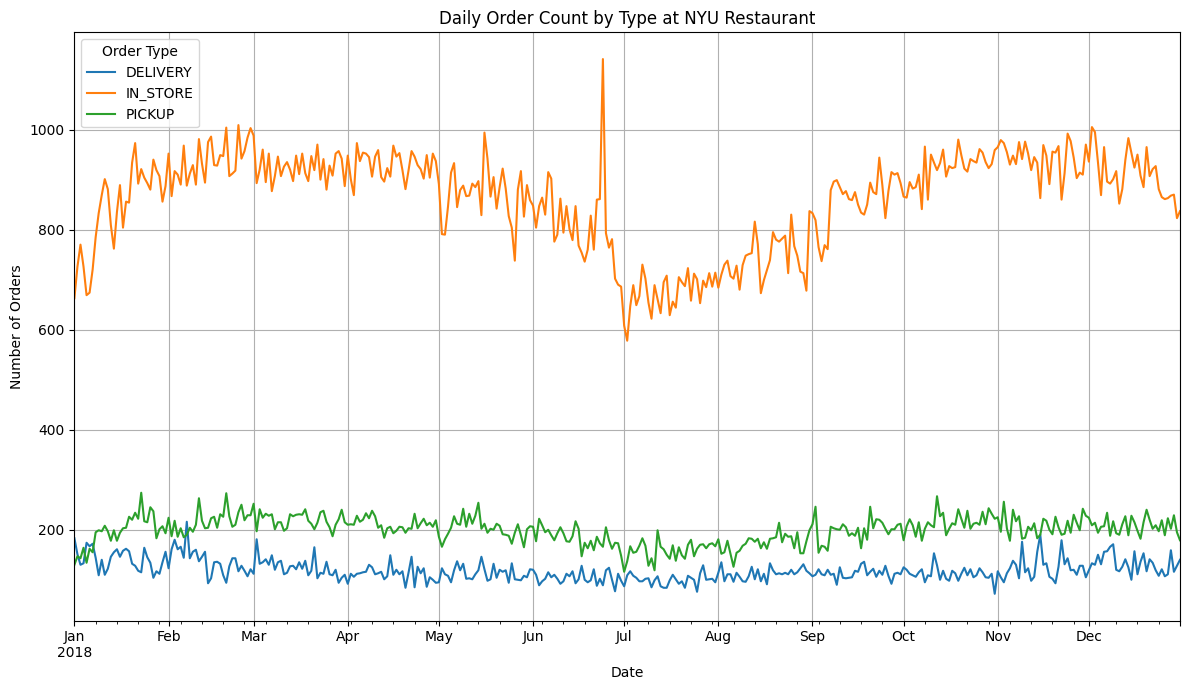

In [ ]:
# orders volume of 3 delivery types in NYU restaurant in 1 year

df_nyu = df_orders[df_orders_7_restaurants.NAME == 'NYU'].copy()

df_nyu ['DATETIME'] = pd.to_datetime(df_nyu['DATETIME'])
df_nyu.set_index('DATETIME', inplace=True)

nyu_orders_by_type_day = df_nyu.groupby('TYPE').resample('D').size().unstack(level=0)
nyu_orders_by_type_day = nyu_orders_by_type_day.fillna(0)

nyu_orders_by_type_day.plot(kind='line', figsize=(12, 7))

plt.title('Daily Order Count by Type at NYU Restaurant')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend(title='Order Type')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Items

## 3.1 Items Analysis (Basic)

In [ ]:
barh_color = 'darkseagreen'

In [ ]:
df_orders_items_analysis = df_orders_7

### 3.1.1 Main

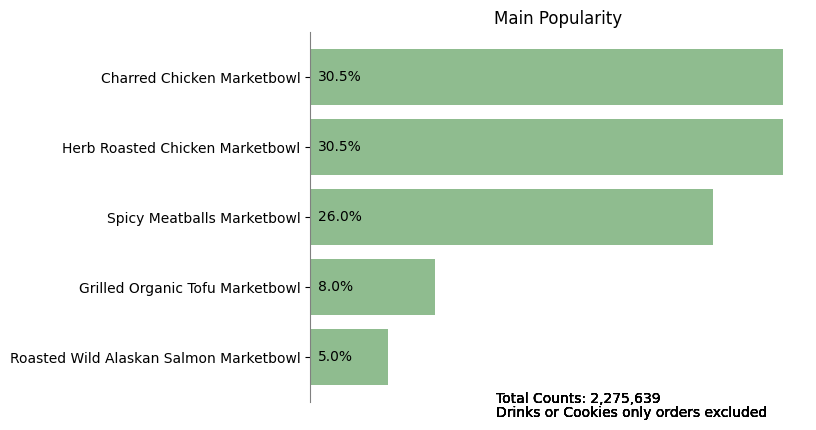

In [ ]:
## What are the most popular bowls?

title = 'Main Popularity'

# Get the value counts
counts_main = df_orders_items_analysis.MAIN_NAME.value_counts()

# Reverse the order (OpenAI, 2025)
counts_main = counts_main[::-1]

# Calculate percentages
counts_main_p = counts_main / counts_main.sum() * 100

# Data for a graph
df = counts_main
df_p = counts_main_p

# Format data labels  (OpenAI, 2025)
df_p_label = (round(df_p, 1)).astype(str) + '%'


## Draw a graph
plt.title(title)

# Delete borders for better visual (OpenAI, 2025)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Change color of left border for better visual (OpenAI, 2025)
plt.gca().spines['left'].set_color('gray')

# Delete xticks for better visual (OpenAI, 2025)
plt.xticks([])

# Plot the horizontal bar chart (OpenAI, 2025)
plt.barh(df_p.index, df_p.values, color=barh_color)

# Add data labels  (OpenAI, 2025; DataCamp, n.d.)
for i, v in enumerate(df_p.values):
    plt.text(0.5, i, df_p_label.values[i], va='center', color='black')
    plt.text(12, -0.6,'Total Counts: ' + str(format(df.sum(),',')), va='center', color='black')
    plt.text(12, -0.8, 'Drinks or Cookies only orders excluded', va='center', color='black')

plt.show()

## Reference
# DataCamp. (n.d.). Intermediate Python.
# OpenAI. (2025). ChatGPT 4o (May 17 version) [Large language model].

The most popular main is Charred Chicken Marketbowl and Herb Roasted Chicken Marketbowl.

### 3.1.2 Base

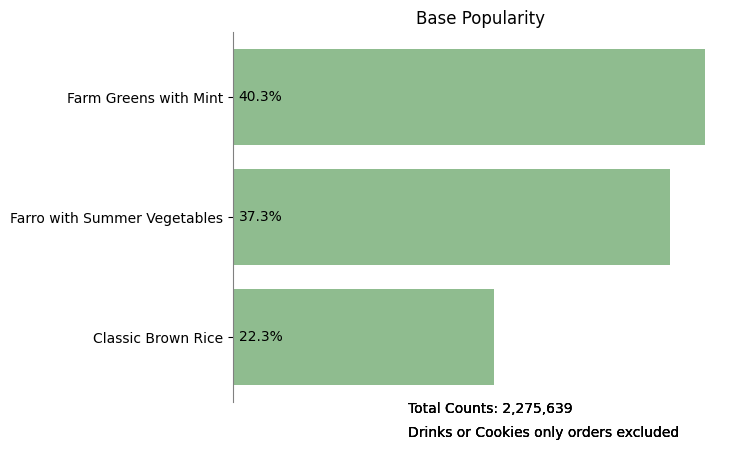

In [ ]:
## What are the most popular base?

title = 'Base Popularity'

# Get the value counts
counts_base = df_orders_items_analysis.BASE_NAME.value_counts()

# Reverse the order (OpenAI, 2025)
counts_base = counts_base[::-1]

# Calculate percentages
counts_base_p = counts_base / counts_base.sum() * 100

# Data for a graph
df = counts_base
df_p = counts_base_p

# Format data labels  (OpenAI, 2025)
df_p_label = (round(counts_base_p, 1)).astype(str) + '%'


## Draw a graph
plt.title(title)

# Delete borders for better visual (OpenAI, 2025)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Change color of left border for better visual (OpenAI, 2025)
plt.gca().spines['left'].set_color('gray')

# Delete xticks for better visual (OpenAI, 2025)
plt.xticks([])

# Plot the horizontal bar chart (OpenAI, 2025)
plt.barh(df_p.index, df_p.values, color=barh_color)

# Add data labels  (OpenAI, 2025; DataCamp, n.d.)
for i, v in enumerate(df_p.values):
    plt.text(0.5, i, df_p_label.values[i], va='center', color='black')
    plt.text(15, -0.6,'Total Counts: ' + str(format(df.sum(),',')), va='center', color='black')
    plt.text(15, -0.8, 'Drinks or Cookies only orders excluded', va='center', color='black')

#plt.savefig(title+'.png')
plt.show()

## Reference
# DataCamp. (n.d.). Intermediate Python.
# OpenAI. (2025). ChatGPT 4o (May 17 version) [Large language model].

The most popular base is Farm Greens with Mint.

### 3.1.3 Sides

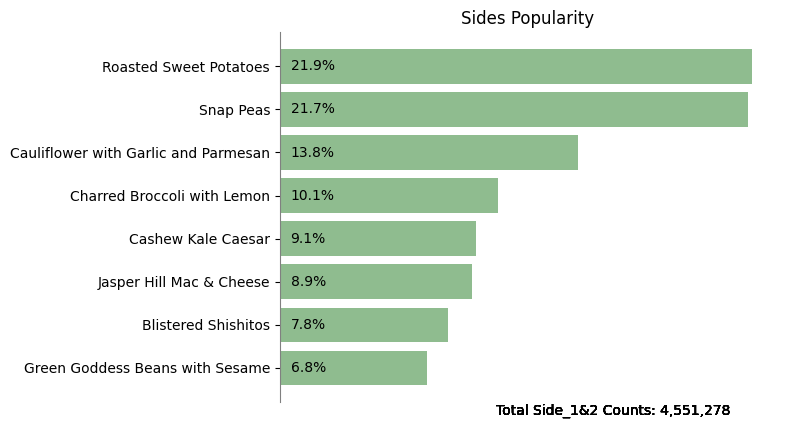

In [ ]:
## What are the most popular sides?

title = 'Sides Popularity'

# Get the value counts
counts_side_1 = df_orders_items_analysis.SIDE_1_NAME.value_counts()
counts_side_2 = df_orders_items_analysis.SIDE_2_NAME.value_counts()
counts_sides = counts_side_1 + counts_side_2

# Reverse the order (OpenAI, 2025)
counts_sides = counts_sides[::-1]

# Calculate percentages
counts_sides_p = counts_sides / counts_sides.sum() * 100

# Data for a graph
df = counts_sides
df_p = counts_sides_p

# Format data labels  (OpenAI, 2025)
df_p_label = (round(counts_sides_p, 1)).astype(str) + '%'


## Draw a graph
plt.title(title)

# Delete borders for better visual (OpenAI, 2025)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Change color of left border for better visual (OpenAI, 2025)
plt.gca().spines['left'].set_color('gray')

# Delete xticks for better visual (OpenAI, 2025)
plt.xticks([])

# Plot the horizontal bar chart (OpenAI, 2025)
plt.barh(df_p.index, df_p.values, color=barh_color)

# Add data labels  (OpenAI, 2025; DataCamp, n.d.)
for i, v in enumerate(df_p.values):
    plt.text(0.5, i, df_p_label.values[i], va='center', color='black')
    plt.text(10, -1,'Total Side_1&2 Counts: ' + str(format(df.sum(),',')), va='center', color='black')

#plt.savefig(title+'.png')
plt.show()

The most popular sides are Roasted Sweet Potatoes and Snap Peas.

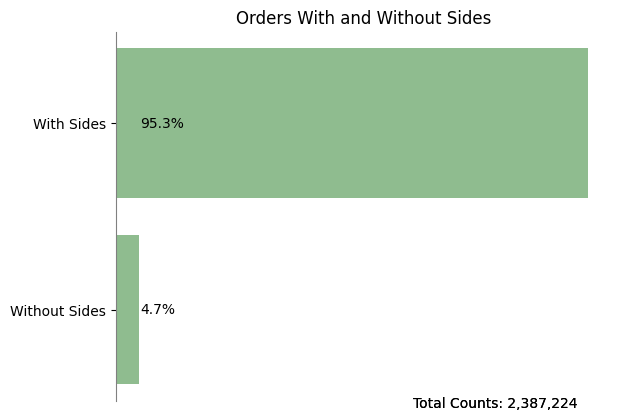

In [ ]:
## Plot the orders with/without sides

title = 'Orders With and Without Sides'

# Get the value counts
orders_with_sides = df_orders_items_analysis[~(df_orders_items_analysis['SIDE_1_NAME'].isna()) | ~(df_orders_items_analysis['SIDE_2_NAME'].isna())].shape[0]
orders_without_sides = df_orders_items_analysis[(df_orders_items_analysis['SIDE_1_NAME'].isna()) & (df_orders_items_analysis['SIDE_2_NAME'].isna())].shape[0]
counts_w_wo_sides = pd.Series({'Without Sides': orders_without_sides,'With Sides': orders_with_sides})

# Reverse the order (OpenAI, 2025)
#counts_w_wo_sides = counts_w_wo_sides[::-1]

# Calculate percentages
counts_w_wo_sides_p = counts_w_wo_sides / counts_w_wo_sides.sum() * 100

# Data for a graph
df = counts_w_wo_sides
df_p = counts_w_wo_sides_p

# Format data labels  (OpenAI, 2025)
df_p_label = (round(df_p, 1)).astype(str) + '%'


## Draw a graph
plt.title(title)

# Delete borders for better visual (OpenAI, 2025)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Change color of left border for better visual (OpenAI, 2025)
plt.gca().spines['left'].set_color('gray')

# Delete xticks for better visual (OpenAI, 2025)
plt.xticks([])

# Plot the horizontal bar chart (OpenAI, 2025)
plt.barh(df_p.index, df_p.values, color=barh_color)

# Add data labels  (OpenAI, 2025; DataCamp, n.d.)
for i, v in enumerate(df_p.values):
    plt.text(5, i, df_p_label.values[i], va='center', color='black')
    plt.text(60, -0.5,'Total Counts: ' + str(format(df.sum(),',')), va='center', color='black')

#plt.savefig(title+'.png')
plt.show()

## Reference
# DataCamp. (n.d.). Intermediate Python.
# Google. (2025). Gemini (May 17 version) [Large language model].
# OpenAI. (2025). ChatGPT 4o (May 17 version) [Large language model].

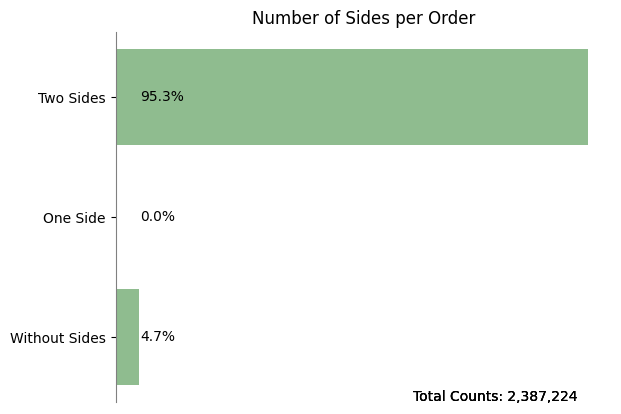

In [ ]:
## Plot the orders with/without sides

title = 'Number of Sides per Order'

# Get the number of sides (Google, 2025)
orders_with_two_sides = df_orders_items_analysis[~(df_orders_7['SIDE_1_NAME'].isna()) & ~(df_orders_items_analysis['SIDE_2_NAME'].isna())].shape[0]
orders_without_sides = df_orders_items_analysis[(df_orders_items_analysis['SIDE_1_NAME'].isna()) & (df_orders_items_analysis['SIDE_2_NAME'].isna())].shape[0]
orders_with_one_side = df_orders_items_analysis[(df_orders_items_analysis['SIDE_1_NAME'].isna()) | (df_orders_items_analysis['SIDE_2_NAME'].isna())].shape[0] - orders_without_sides
counts_sides_n = pd.Series({'Without Sides': orders_without_sides,'One Side': orders_with_one_side, 'Two Sides': orders_with_two_sides})

# Reverse the order (OpenAI, 2025)
#counts_sides_n = counts_sides_n[::-1]

# Calculate percentages
counts_sides_n_p = counts_sides_n / counts_sides_n.sum() * 100

# Data for a graph
df = counts_sides_n
df_p = counts_sides_n_p

# Format data labels  (OpenAI, 2025)
df_p_label = (round(df_p, 1)).astype(str) + '%'


## Draw a graph
plt.title(title)

# Delete borders for better visual (OpenAI, 2025)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Change color of left border for better visual (OpenAI, 2025)
plt.gca().spines['left'].set_color('gray')

# Delete xticks for better visual (OpenAI, 2025)
plt.xticks([])

# Plot the horizontal bar chart (OpenAI, 2025)
plt.barh(df_p.index, df_p.values, color=barh_color)

# Add data labels  (OpenAI, 2025; DataCamp, n.d.)
for i, v in enumerate(df_p.values):
    plt.text(5, i, df_p_label.values[i], va='center', color='black')
    plt.text(60, -0.5,'Total Counts: ' + str(format(df.sum(),',')), va='center', color='black')

#plt.savefig(title+'.png')
plt.show()


## Reference
# DataCamp. (n.d.). Intermediate Python.
# Google. (2025). Gemini (May 17 version) [Large language model].
# OpenAI. (2025). ChatGPT 4o (May 17 version) [Large language model].

95% of customers order two sides with the bowls.

### 3.1.4 Drinks

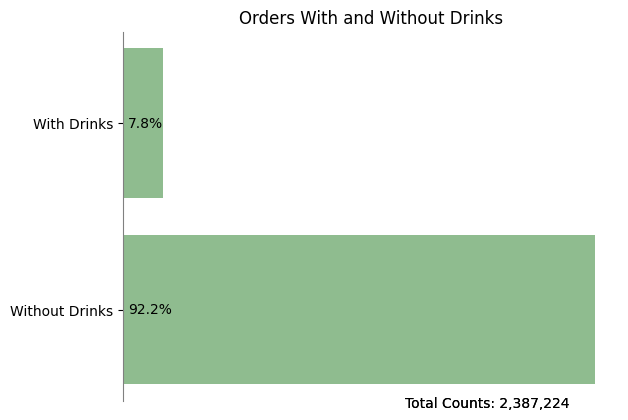

In [ ]:
## How many orders are with/without drinks? (Google, 2025)

title = 'Orders With and Without Drinks'

# Get the counts of orders with/without drinks (Google, 2025)
orders_with_drinks = df_orders_items_analysis[~(df_orders_items_analysis['DRINKS'] == 0)].shape[0]
orders_without_drinks = df_orders_items_analysis[(df_orders_items_analysis['DRINKS'] == 0)].shape[0]
counts_w_wo_drinks = pd.Series({'Without Drinks': orders_without_drinks,'With Drinks': orders_with_drinks})

# Reverse the order (OpenAI, 2025)
#counts_w_wo_drinks = counts_w_wo_drinks[::-1]

# Calculate percentages
counts_w_wo_drinks_p = counts_w_wo_drinks / counts_w_wo_drinks.sum() * 100

# Data for a graph
df = counts_w_wo_drinks
df_p = counts_w_wo_drinks_p

# Format data labels  (OpenAI, 2025)
df_p_label = (round(df_p, 1)).astype(str) + '%'


## Draw a graph
plt.title(title)

# Delete borders for better visual (OpenAI, 2025)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Change color of left border for better visual (OpenAI, 2025)
plt.gca().spines['left'].set_color('gray')

# Delete xticks for better visual (OpenAI, 2025)
plt.xticks([])

# Plot the horizontal bar chart (OpenAI, 2025)
plt.barh(df_p.index, df_p.values, color=barh_color)

# Add data labels  (OpenAI, 2025; DataCamp, n.d.)
for i, v in enumerate(df_p.values):
    plt.text(1, i, df_p_label.values[i], va='center', color='black')
    plt.text(55, -0.5,'Total Counts: ' + str(format(df.sum(),',')), va='center', color='black')

#plt.savefig(title+'.png')
plt.show()

## Reference
# DataCamp. (n.d.). Intermediate Python.
# Google. (2025). Gemini (May 17 version) [Large language model].
# OpenAI. (2025). ChatGPT 4o (May 17 version) [Large language model].

92% of customers does not order drinks with the bowls.

### 3.1.5 Cookies

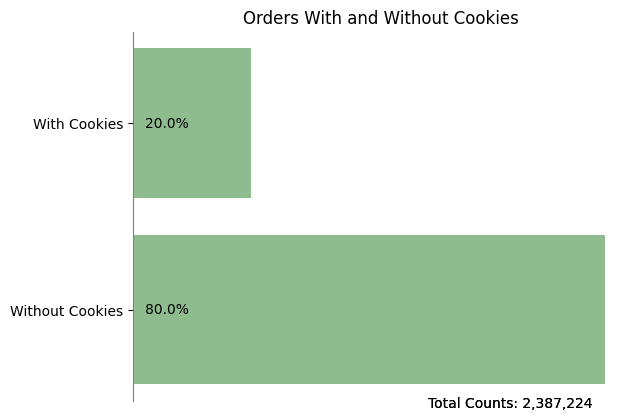

In [ ]:
## How many orders are with/without cookies? (Google, 2025)

title = 'Orders With and Without Cookies'

# Get the counts of orders with/without drinks (Google, 2025)
orders_with_cookies = df_orders_items_analysis[~(df_orders_items_analysis['COOKIES'] == 0)].shape[0]
orders_without_cookies = df_orders_items_analysis[(df_orders_items_analysis['COOKIES'] == 0)].shape[0]
counts_w_wo_cookies = pd.Series({'Without Cookies': orders_without_cookies,'With Cookies': orders_with_cookies})

# Reverse the order (OpenAI, 2025)
#counts_w_wo_cookies = counts_w_wo_cookies[::-1]

# Calculate percentages
counts_w_wo_cookies_p = counts_w_wo_cookies / counts_w_wo_cookies.sum() * 100

# Data for a graph
df = counts_w_wo_cookies
df_p = counts_w_wo_cookies_p

# Format data labels  (OpenAI, 2025)
df_p_label = (round(df_p, 1)).astype(str) + '%'


## Draw a graph
plt.title(title)

# Delete borders for better visual (OpenAI, 2025)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Change color of left border for better visual (OpenAI, 2025)
plt.gca().spines['left'].set_color('gray')

# Delete xticks for better visual (OpenAI, 2025)
plt.xticks([])

# Plot the horizontal bar chart (OpenAI, 2025)
plt.barh(df_p.index, df_p.values, color=barh_color)

# Add data labels  (OpenAI, 2025; DataCamp, n.d.)
for i, v in enumerate(df_p.values):
    plt.text(2, i, df_p_label.values[i], va='center', color='black')
    plt.text(50, -0.5,'Total Counts: ' + str(format(df.sum(),',')), va='center', color='black')

#plt.savefig(title+'.png')
plt.show()

## Reference
# DataCamp. (n.d.). Intermediate Python.
# Google. (2025). Gemini (May 17 version) [Large language model].
# OpenAI. (2025). ChatGPT 4o (May 17 version) [Large language model].

80% of customers does not order cookies with the bowls.

### 3.1.6 Combo

In [ ]:
## What COMBO is the most popular? (OpenAI, 2025)

df_orders_combo = df_orders_items_analysis

# Combine and sort side items to ensure consistent order
df_orders_combo['SIDES_SORTED'] = df_orders_combo[['SIDE_1_NAME', 'SIDE_2_NAME']].apply(
    lambda x: ' + '.join(sorted(x.dropna())), axis=1
)

# This query takes 3 min to check all combination of items

## Reference
# OpenAI. (2025). ChatGPT 4o (May 17 version) [Large language model].

In [ ]:
# Combine into a final combo key
df_orders_combo['COMBO'] = (
    df_orders_combo['MAIN_NAME'].fillna('') + ' + ' +
    df_orders_combo['BASE_NAME'].fillna('') + ' + ' +
    df_orders_combo['SIDES_SORTED']
)

# Drop rows with any missing critical parts (main or base)
df_orders_combo = df_orders_combo.dropna(subset=['MAIN_NAME', 'BASE_NAME'])

# Count combinations
combo_counts = df_orders_combo['COMBO'].value_counts()

# Convert to DataFrame
combo_df = combo_counts.reset_index()
combo_df.columns = ['COMBO', 'COUNTS']

# Add percentage to DataFrame
combo_df['PERCENTAGE'] = combo_df['COUNTS'] / combo_df['COUNTS'].sum() * 100

# Show full COMBO Name
pd.set_option('display.max_colwidth', 150)

combo_df

# Tried using Item ID instead of Item Name to run code faster, but it didn't work.

## Reference
# OpenAI. (2025). ChatGPT 4o (May 17 version) [Large language model].

COMBO  \
0    Herb Roasted Chicken Marketbowl + Farro with Summer Vegetables + Cauliflower with Garlic and Parmesan + Roasted Sweet Potatoes   
1                                                        Spicy Meatballs Marketbowl + Farm Greens with Mint + Snap Peas + Snap Peas   
2                                           Spicy Meatballs Marketbowl + Farm Greens with Mint + Roasted Sweet Potatoes + Snap Peas   
3                                                 Spicy Meatballs Marketbowl + Farro with Summer Vegetables + Snap Peas + Snap Peas   
4                         Herb Roasted Chicken Marketbowl + Farm Greens with Mint + Roasted Sweet Potatoes + Roasted Sweet Potatoes   
..                                                                                                                              ...   
535               Roasted Wild Alaskan Salmon Marketbowl + Farro with Summer Vegetables + Blistered Shishitos + Blistered Shishitos   
536                                   Roasted Wild Alaskan Salmon Marketbowl + Farro with Summer Vegetables + Snap Peas + Snap Peas   
537                                   Roasted Wild Alaskan Salmon Marketbowl + Classic Brown Rice + Blistered Shishitos + Snap Peas   
538                                             Roasted Wild Alaskan Salmon Marketbowl + Classic Brown Rice + Snap Peas + Snap Peas   
539                         Roasted Wild Alaskan Salmon Marketbowl + Classic Brown Rice + Blistered Shishitos + Blistered Shishitos   

     COUNTS  PERCENTAGE  
0     43449    1.909310  
1     39492    1.735425  
2     37483    1.647142  
3     31467    1.382776  
4     31191    1.370648  
..      ...         ...  
535      32    0.001406  
536      30    0.001318  
537      28    0.001230  
538      16    0.000703  
539      13    0.000571  

[540 rows x 3 columns]

<ipython-input-37-df3747d81a3a>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



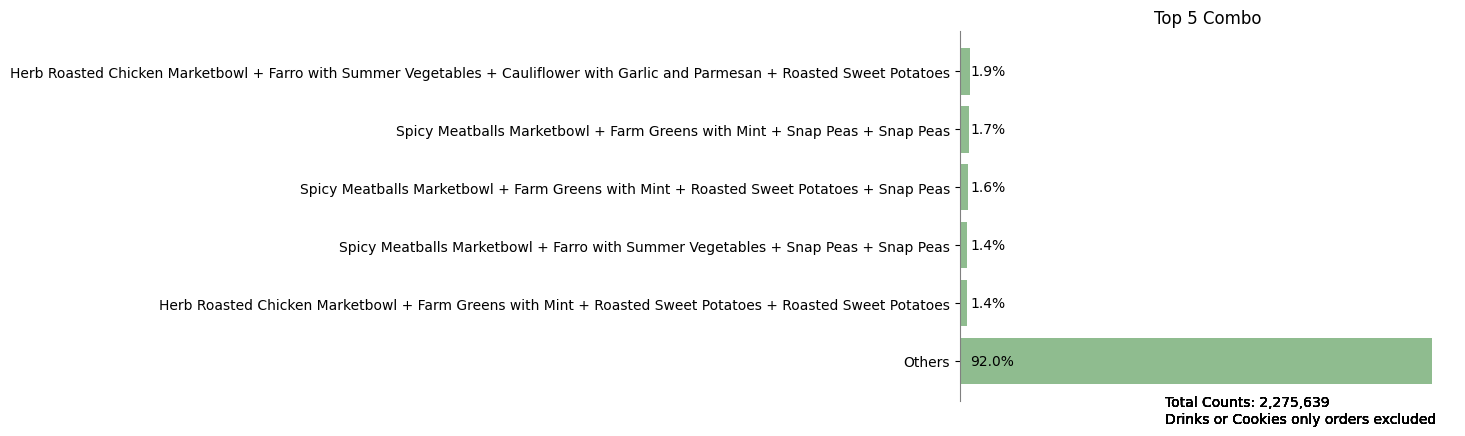

In [ ]:
## Top 5 Combo

title = 'Top 5 Combo'

# Get top 5 COMBO
combo_df_top5 = combo_df.head(5)

# Add a new row to DataFrame (OpenAI, 2025)
combo_df_top5.loc[len(combo_df_top5.index)] = ['Others', combo_df['COUNTS'].sum() - combo_df.head(5)['COUNTS'].sum(), 100 - combo_df_top5['PERCENTAGE'].sum()]

# Reverse the order (OpenAI, 2025)
combo_df_top5_r = combo_df_top5[::-1]
combo_df_top5_r.reset_index(drop=True, inplace=True)

# Calculate percentages
counts_sides_p = counts_sides / counts_sides.sum() * 100

# Data for a graph
df = counts_sides
df_p = counts_sides_p

# Format data labels  (OpenAI, 2025)
df_p_label = (round(counts_sides_p, 1)).astype(str) + '%'


## Draw a graph for COMBO
plt.title(title)

# Delete borders for better visual (OpenAI, 2025)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Change color of left border for better visual (OpenAI, 2025)
plt.gca().spines['left'].set_color('gray')

# Delete xticks for better visual (OpenAI, 2025)
plt.xticks([])

# Plot the horizontal bar chart (OpenAI, 2025)
plt.barh(combo_df_top5_r['COMBO'], combo_df_top5_r['PERCENTAGE'], color=barh_color)

# Format data labels  (OpenAI, 2025)
combo_df_top5_r_label = (round(combo_df_top5_r['PERCENTAGE'], 1)).astype(str) + '%'

# Add data labels  (OpenAI, 2025; DataCamp, n.d.)
for i, v in enumerate(combo_df_top5_r['PERCENTAGE']):
    plt.text(2, i, combo_df_top5_r_label.values[i], va='center', color='black')
    plt.text(40, -0.7, 'Total Counts: ' + str(format(combo_df['COUNTS'].sum(),',')), va='center', color='black')
    plt.text(40, -1, 'Drinks or Cookies only orders excluded', va='center', color='black')

#plt.savefig(title+'.png')
plt.show()

## Reference
# DataCamp. (n.d.). Intermediate Python.
# OpenAI. (2025). ChatGPT 4o (May 17 version) [Large language model].

The most popular combo is "Herb Roasted Chicken Marketbowl + Farro with Summer Vegetables + Cauliflower with Garlic and Parmesan + Roasted Sweet Potatoes", accounting for 1.9% of all orders.

## 3.2 Items Analysis (Seasonality)

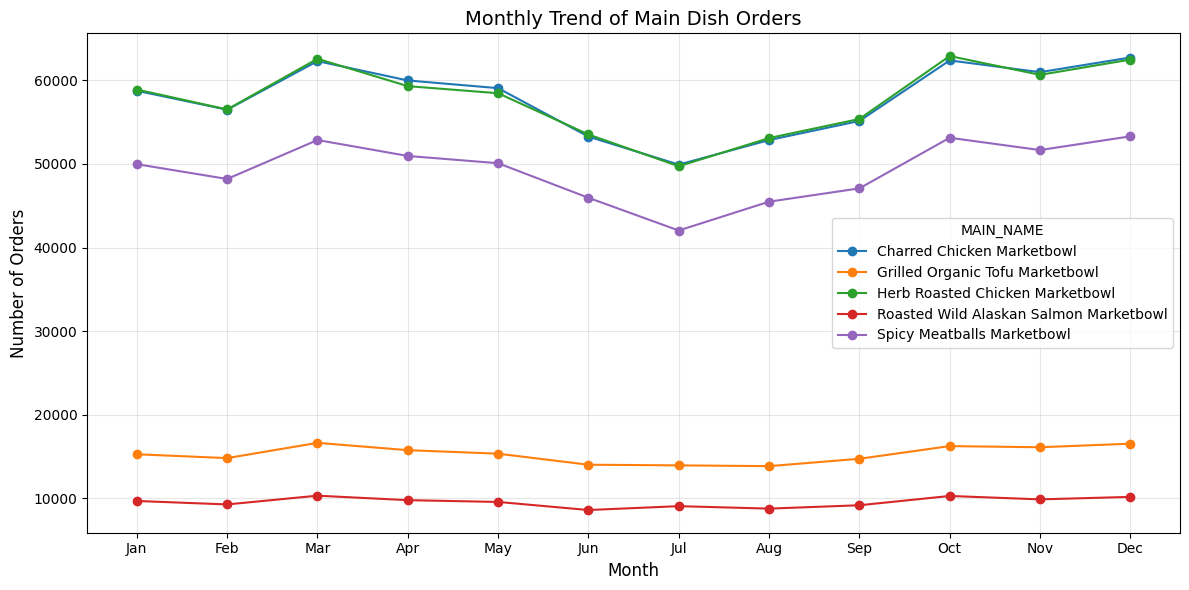

In [ ]:
# We analyzed monthly trends in the orders of MAIN dishes for the restaurant. / Anthropic. (2025, May 20). Python code for visualizing monthly main dish trends with month names [Source code]. Claude 3.7 Sonnet. https://claude.ai
def plot_monthly_main_dish_trends():
    global df_orders_7_restaurants

    # Convert DATETIME column to datetime format if not already converted
    df_orders_7_restaurants['DATETIME'] = pd.to_datetime(df_orders_7_restaurants['DATETIME'])

    # Extract month from date
    df_orders_7_restaurants['MONTH'] = df_orders_7_restaurants['DATETIME'].dt.month

    # Group by month and MAIN_NAME, count orders
    monthly_main_orders = df_orders_7_restaurants.groupby(['MONTH', 'MAIN_NAME']).size().reset_index(name='COUNT')

    # Create figure for the chart
    plt.figure(figsize=(12, 6))

    # Get unique main dish names, removing NaN values
    main_dishes = monthly_main_orders['MAIN_NAME'].dropna().unique()

    # Create a line for each main dish
    for dish in main_dishes:
        # Filter data for this dish
        dish_data = monthly_main_orders[monthly_main_orders['MAIN_NAME'] == dish]

        # Sort by month to ensure line continuity
        dish_data = dish_data.sort_values('MONTH')

        # Plot line for this dish
        plt.plot(dish_data['MONTH'], dish_data['COUNT'], label=dish, marker='o')

    # Define month names for x-axis labels
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Configure the chart
    plt.title('Monthly Trend of Main Dish Orders', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='MAIN_NAME')
    plt.tight_layout()

    # Set x-ticks at month positions with month names as labels
    plt.xticks(range(1, 13), month_names)


    # Show the chart
    plt.show()

# Execute the function
plot_monthly_main_dish_trends()

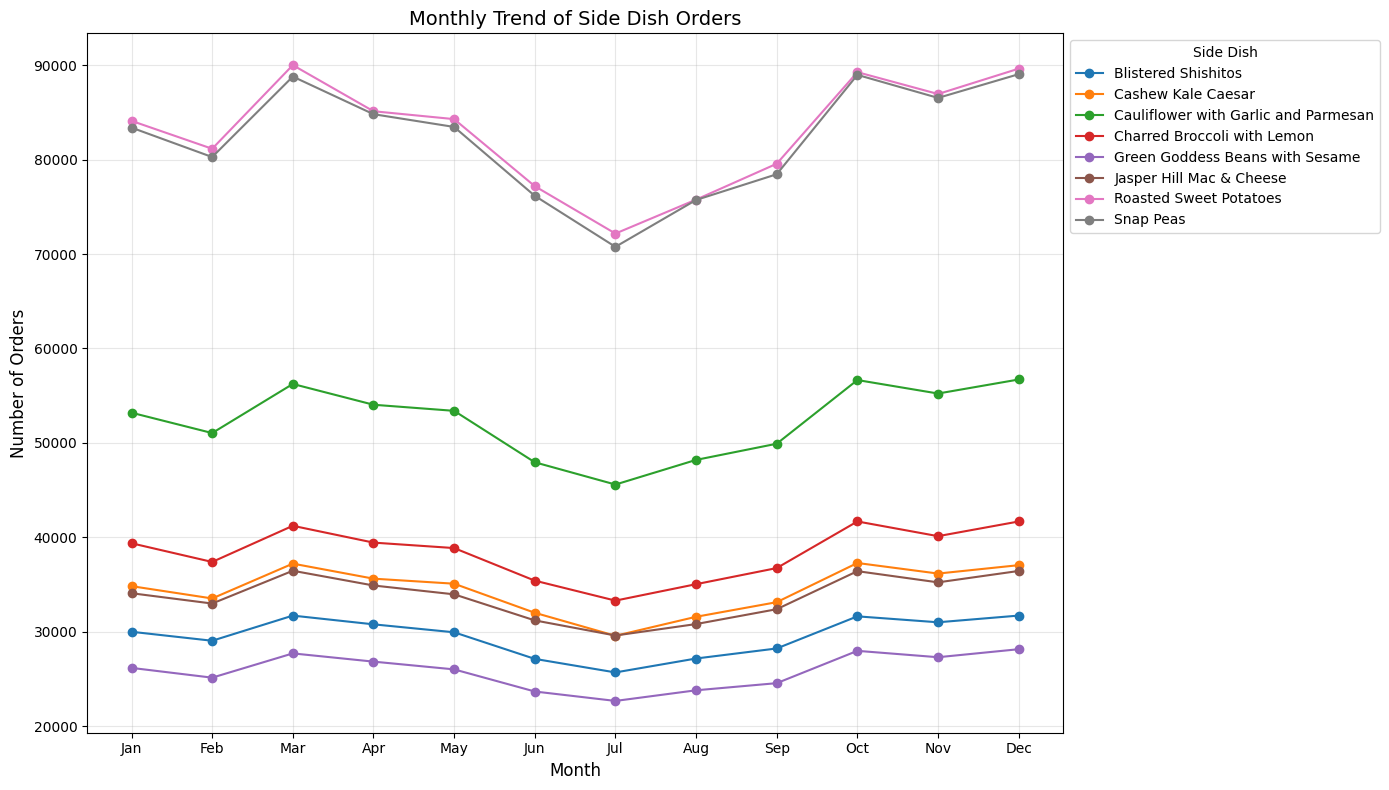

In [ ]:
# We analyzed monthly trends in the orders of SIDE dishes for the restaurant. / Anthropic. (2025, May 20). Python code for visualizing monthly side dish trends with month names [Source code]. Claude 3.7 Sonnet. https://claude.ai
def plot_monthly_side_dish_trends():
    global df_orders_7_restaurants

    # Convert DATETIME column to datetime format if not already converted
    df_orders_7_restaurants['DATETIME'] = pd.to_datetime(df_orders_7_restaurants['DATETIME'])

    # Extract month from date
    df_orders_7_restaurants['MONTH'] = df_orders_7_restaurants['DATETIME'].dt.month

    # Create a copy of the dataframe to reshape for side dishes
    df_sides = df_orders_7_restaurants.copy()

    # Prepare data for side 1 dishes
    side1_data = df_sides[['MONTH', 'SIDE_1_NAME']].copy()
    side1_data = side1_data.rename(columns={'SIDE_1_NAME': 'SIDE_NAME'})
    side1_data['SIDE_TYPE'] = 'Side 1'

    # Prepare data for side 2 dishes
    side2_data = df_sides[['MONTH', 'SIDE_2_NAME']].copy()
    side2_data = side2_data.rename(columns={'SIDE_2_NAME': 'SIDE_NAME'})
    side2_data['SIDE_TYPE'] = 'Side 2'

    # Combine both side dish datasets
    all_sides = pd.concat([side1_data, side2_data])

    # Remove rows with NaN side dish names
    all_sides = all_sides.dropna(subset=['SIDE_NAME'])

    # Group by month and side dish name, count occurrences
    monthly_side_orders = all_sides.groupby(['MONTH', 'SIDE_NAME']).size().reset_index(name='COUNT')

    # Create figure for the chart
    plt.figure(figsize=(14, 8))

    # Get unique side dish names
    side_dishes = monthly_side_orders['SIDE_NAME'].unique()

    # Create a line for each side dish
    for dish in side_dishes:
        # Filter data for this dish
        dish_data = monthly_side_orders[monthly_side_orders['SIDE_NAME'] == dish]

        # Sort by month to ensure line continuity
        dish_data = dish_data.sort_values('MONTH')

        # Plot line for this dish
        plt.plot(dish_data['MONTH'], dish_data['COUNT'], label=dish, marker='o')

    # Define month names for x-axis labels
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Configure the chart
    plt.title('Monthly Trend of Side Dish Orders', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Side Dish', loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    # Set x-ticks at month positions with month names as labels
    plt.xticks(range(1, 13), month_names)

    # Show the chart
    plt.show()

# Execute the function
plot_monthly_side_dish_trends()

In [ ]:
# We categorized MAIN dishes by preparation method and SIDE dishes by presentation format to explore possible trends. / Anthropic. (2025, May 20). Python code for create categories [Source code]. Claude 3.7 Sonnet. https://claude.ai

def add_item_category():
    global df_items

    print(f"Original df_items shape: {df_items.shape}")

    # Define our new classifications
    category_map = {
        # Main dishes - Cooking Methods
        'Roasted Wild Alaskan Salmon Marketbowl': 'Oven-Prepared/Indirect Heat',
        'Herb Roasted Chicken Marketbowl': 'Oven-Prepared/Indirect Heat',
        'Charred Chicken Marketbowl': 'Grilled/Direct Heat',
        'Spicy Meatballs Marketbowl': 'Grilled/Direct Heat',
        'Grilled Organic Tofu Marketbowl': 'Grilled/Direct Heat',

        # Side dishes - Types
        'Cauliflower with Garlic and Parmesan': 'Cooked Vegetables',
        'Cashew Kale Caesar': 'Raw Vegetables',
        'Charred Broccoli with Lemon': 'Cooked Vegetables',
        'Green Goddess Beans with Sesame': 'Cooked Vegetables',
        'Snap Peas': 'Raw Vegetables',
        'Roasted Sweet Potatoes': 'Cooked Vegetables',
        'Blistered Shishitos': 'Cooked Vegetables',
        'Jasper Hill Mac & Cheese': 'Non-Vegetables',
        'Classic Brown Rice': 'Non-Vegetables',
        'Farro with Summer Vegetables': 'Non-Vegetables'
    }

    # Create new ITEM_CATEGORY column based on ITEM_NAME
    def get_category(item_name):
        # Try to get from our mapping
        if item_name in category_map:
            return category_map[item_name]

        # If not in our mapping, use a fallback based on ITEM_TYPE
        if item_name in df_items['ITEM_NAME'].values:
            existing_type = df_items.loc[df_items['ITEM_NAME'] == item_name, 'ITEM_TYPE'].iloc[0]
            if existing_type == 'Drinks':
                return 'Beverages'
            elif existing_type == 'Bases':
                return 'Non-Vegetables'
            elif existing_type == 'Market Sides':
                return 'Other Sides'
            else:
                return existing_type
        else:
            return "Other"

    # Add the new ITEM_CATEGORY column
    df_items['ITEM_CATEGORY'] = df_items['ITEM_NAME'].apply(get_category)

    print(f"Modified df_items shape: {df_items.shape}")
    print("Added new 'ITEM_CATEGORY' column without modifying 'ITEM_TYPE'")

    # Return the updated dataframe
    return df_items

# Run the function
df_items = add_item_category()

# Display the updated items
print("\nUpdated df_items:")
print(df_items[['ITEM_ID', 'ITEM_NAME', 'ITEM_TYPE', 'ITEM_CATEGORY']].head(10))


Original df_items shape: (31, 3)
Modified df_items shape: (31, 4)
Added new 'ITEM_CATEGORY' column without modifying 'ITEM_TYPE'

Updated df_items:
  ITEM_ID                              ITEM_NAME     ITEM_TYPE  \
0      I7           Farro with Summer Vegetables         Bases   
1     I39                        Spindrift Lemon        Drinks   
2      I5                     Classic Brown Rice         Bases   
3     I36                               Kombucha        Drinks   
4      I8   Cauliflower with Garlic and Parmesan  Market Sides   
5     I37                       Organic Iced Tea        Drinks   
6     I12                     Cashew Kale Caesar  Market Sides   
7     I31                    Kitchen Sink Cookie      Desserts   
8     I11            Charred Broccoli with Lemon  Market Sides   
9     I33  Cawston Press Rhubarb Sparkling Drink        Drinks   

       ITEM_CATEGORY  
0     Non-Vegetables  
1          Beverages  
2     Non-Vegetables  
3          Beverages  
4  Cooked 

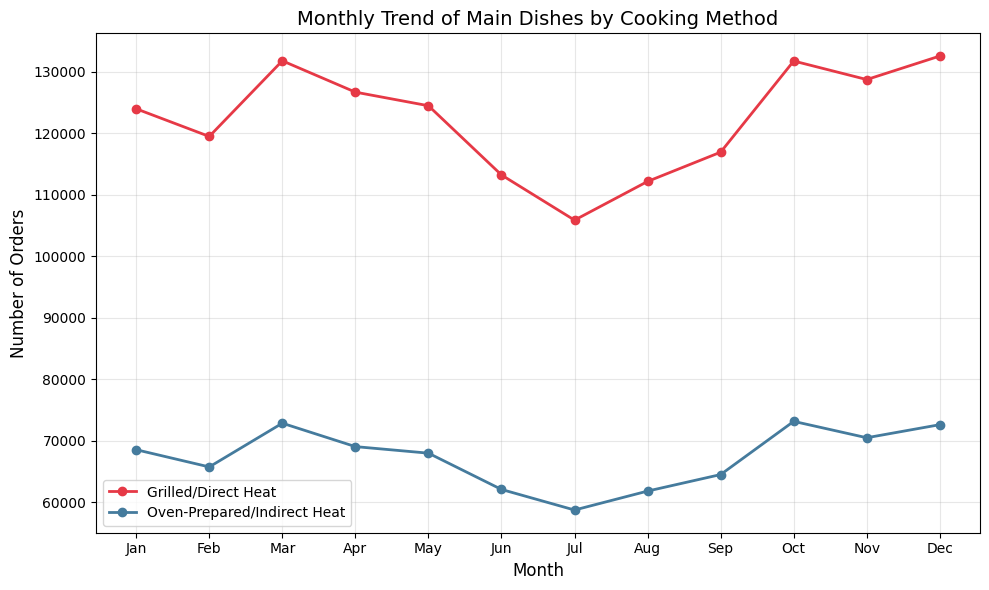

In [ ]:
# Based on the newly defined categories, we re-analyzed the MAIN dishes / Anthropic. (2025, May 20). Python code for recreate main dishes monthly trend by new category  [Source code]. Claude 3.7 Sonnet. https://claude.ai
def simple_main_dish_chart():
    global df_items, df_orders_7_restaurants

    # 1. Create a mapping from MAIN_ID to CATEGORY
    main_categories = {}
    for _, row in df_items.iterrows():
        main_categories[row['ITEM_ID']] = row['ITEM_CATEGORY']

    # 2. Add MONTH and CATEGORY to orders
    df_orders_7_restaurants['MONTH'] = pd.to_datetime(df_orders_7_restaurants['DATETIME']).dt.month
    df_orders_7_restaurants['MAIN_CATEGORY'] = df_orders_7_restaurants['MAIN'].map(main_categories)

    # 3. Filter for cooking method categories and group by month
    cooking_methods = ['Grilled/Direct Heat', 'Oven-Prepared/Indirect Heat']
    monthly_data = df_orders_7_restaurants[df_orders_7_restaurants['MAIN_CATEGORY'].isin(cooking_methods)]
    monthly_counts = monthly_data.groupby(['MONTH', 'MAIN_CATEGORY']).size().reset_index(name='COUNT')

    # 4. Create simple plot
    plt.figure(figsize=(10, 6))

    # Define colors for better visualization
    colors = {
        'Grilled/Direct Heat': '#E63946',     # Rojo para método directo/caliente
        'Oven-Prepared/Indirect Heat': '#457B9D'  # Azul para método indirecto
    }

    for method in cooking_methods:
        data = monthly_counts[monthly_counts['MAIN_CATEGORY'] == method]
        plt.plot(data['MONTH'], data['COUNT'], marker='o',
                 label=method, color=colors.get(method), linewidth=2)

    # Define month names for x-axis labels
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    plt.title('Monthly Trend of Main Dishes by Cooking Method', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Set x-ticks at month positions with month names as labels
    plt.xticks(range(1, 13), month_names)

    plt.tight_layout()
    plt.show()

# Run the simplified function
simple_main_dish_chart()

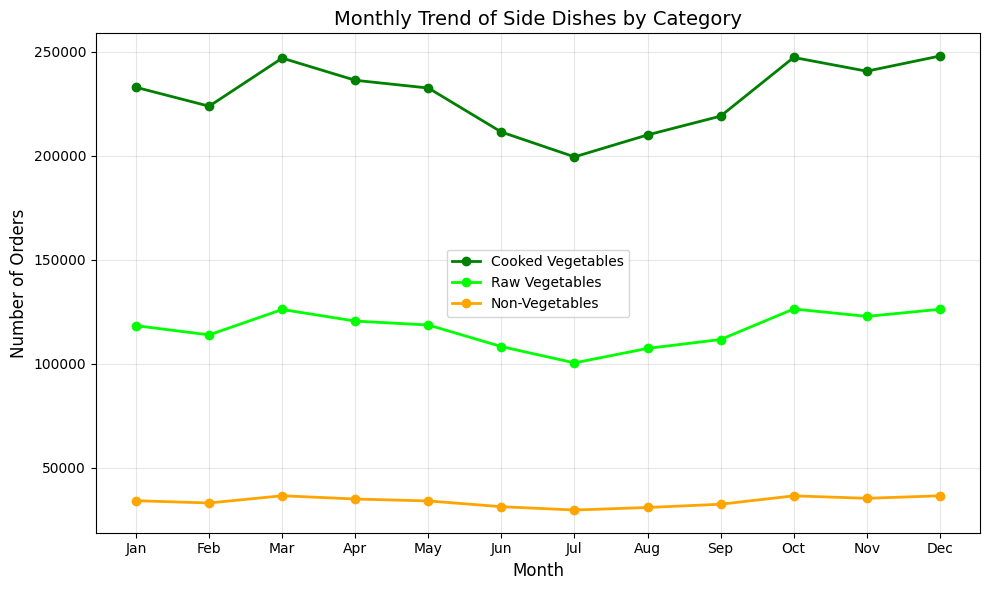

In [ ]:
# Same with SIDE dishes / Anthropic. (2025, May 20). Python code for recreate side dishes monthly trend by new category  [Source code]. Claude 3.7 Sonnet. https://claude.ai
def simple_side_dish_chart():
    global df_items, df_orders_7_restaurants

    # 1. Create a mapping from ITEM_ID to CATEGORY
    side_categories = {}
    for _, row in df_items.iterrows():
        side_categories[row['ITEM_ID']] = row['ITEM_CATEGORY']

    # 2. Add MONTH to orders
    df_orders_7_restaurants['MONTH'] = pd.to_datetime(df_orders_7_restaurants['DATETIME']).dt.month

    # 3. Create two dataframes: one for SIDE_1 and one for SIDE_2
    # For SIDE_1
    side1_data = df_orders_7_restaurants[['MONTH', 'SIDE_1']].copy()
    side1_data.columns = ['MONTH', 'SIDE_ID']

    # For SIDE_2
    side2_data = df_orders_7_restaurants[['MONTH', 'SIDE_2']].copy()
    side2_data.columns = ['MONTH', 'SIDE_ID']

    # 4. Combine both side dataframes
    all_sides = pd.concat([side1_data, side2_data])

    # 5. Add category and remove null sides
    all_sides['SIDE_CATEGORY'] = all_sides['SIDE_ID'].map(side_categories)
    all_sides = all_sides.dropna(subset=['SIDE_ID', 'SIDE_CATEGORY'])

    # 6. Filter for vegetable categories and group by month
    veg_categories = ['Cooked Vegetables', 'Raw Vegetables', 'Non-Vegetables']
    monthly_data = all_sides[all_sides['SIDE_CATEGORY'].isin(veg_categories)]
    monthly_counts = monthly_data.groupby(['MONTH', 'SIDE_CATEGORY']).size().reset_index(name='COUNT')

    # 7. Create simple plot
    plt.figure(figsize=(10, 6))

    colors = {
        'Cooked Vegetables': 'green',
        'Raw Vegetables': 'lime',
        'Non-Vegetables': 'orange'
    }

    for category in veg_categories:
        data = monthly_counts[monthly_counts['SIDE_CATEGORY'] == category]
        plt.plot(data['MONTH'], data['COUNT'], marker='o',
                 label=category, color=colors.get(category), linewidth=2)

    # Define month names for x-axis labels
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    plt.title('Monthly Trend of Side Dishes by Category', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Set x-ticks at month positions with month names as labels
    plt.xticks(range(1, 13), month_names)

    plt.tight_layout()
    plt.show()

# Run the simplified function
simple_side_dish_chart()

## 3.3 Items Analysis (peak hours demand)

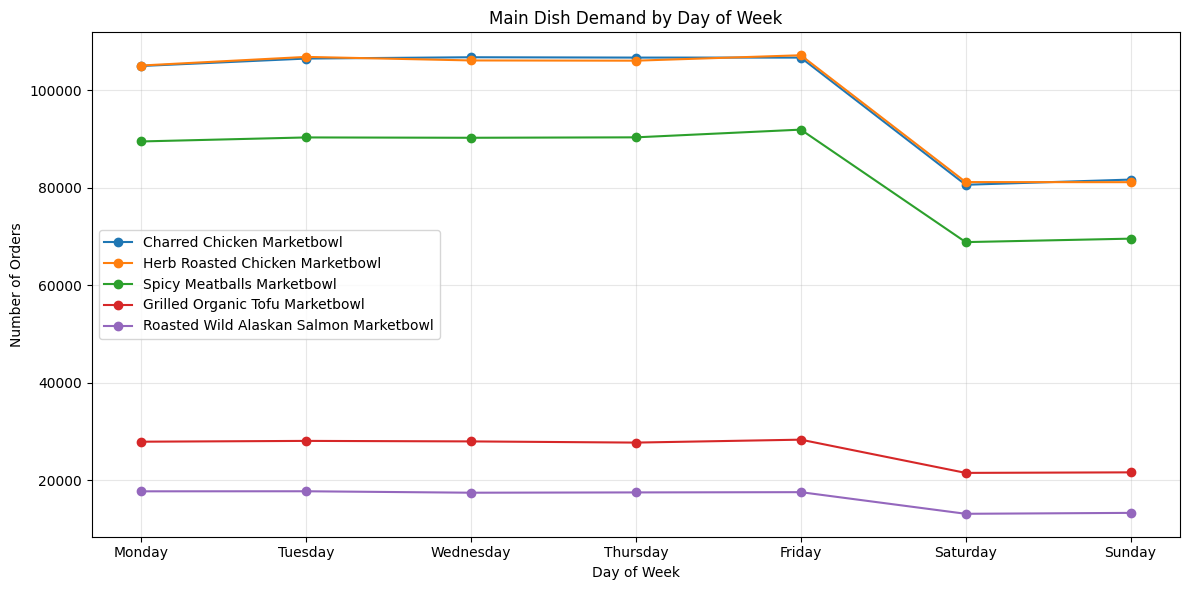

In [ ]:
# Let's analyze if there's any weekday-based purchasing trend for MAIN dishes. / Anthropic. (2025, May 20). Python code for analyze main dishes in days trend [Source code]. Claude 3.7 Sonnet. https://claude.ai
def simple_main_dish_by_day():
    global df_items, df_orders_7_restaurants

    # 1. Create a mapping from MAIN_ID to ITEM_NAME
    main_names = {}
    for _, row in df_items.iterrows():
        main_names[row['ITEM_ID']] = row['ITEM_NAME']

    # 2. Extract day of week from DATETIME
    df_orders_7_restaurants['DATETIME'] = pd.to_datetime(df_orders_7_restaurants['DATETIME'])
    df_orders_7_restaurants['DAY_OF_WEEK'] = df_orders_7_restaurants['DATETIME'].dt.dayofweek
    df_orders_7_restaurants['DAY_NAME'] = df_orders_7_restaurants['DATETIME'].dt.day_name()

    # 3. Add main dish name
    df_orders_7_restaurants['MAIN_NAME'] = df_orders_7_restaurants['MAIN'].map(main_names)

    # 4. Filter for orders with valid main dish
    main_orders = df_orders_7_restaurants.dropna(subset=['MAIN_NAME'])

    # 5. Get top 5 main dishes
    top_mains = main_orders['MAIN_NAME'].value_counts().nlargest(5).index.tolist()

    # 6. Create the plot
    plt.figure(figsize=(12, 6))

    # Day order to ensure correct sequence
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Plot for each main dish
    for dish in top_mains:
        # Get data for this dish
        dish_data = main_orders[main_orders['MAIN_NAME'] == dish]

        # Group by day name and count
        day_counts = dish_data.groupby('DAY_NAME').size().reindex(days_order, fill_value=0)

        # Plot
        plt.plot(day_counts.index, day_counts.values, marker='o', label=dish)

    plt.title('Main Dish Demand by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Orders')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the simple function
simple_main_dish_by_day()

Total unique side dishes found: 8
Side dishes:
1. Snap Peas (ordered 986450 times)
2. Jasper Hill Mac & Cheese (ordered 404399 times)
3. Roasted Sweet Potatoes (ordered 995263 times)
4. Cashew Kale Caesar (ordered 412992 times)
5. Cauliflower with Garlic and Parmesan (ordered 628136 times)
6. Blistered Shishitos (ordered 353950 times)
7. Charred Broccoli with Lemon (ordered 460190 times)
8. Green Goddess Beans with Sesame (ordered 309898 times)


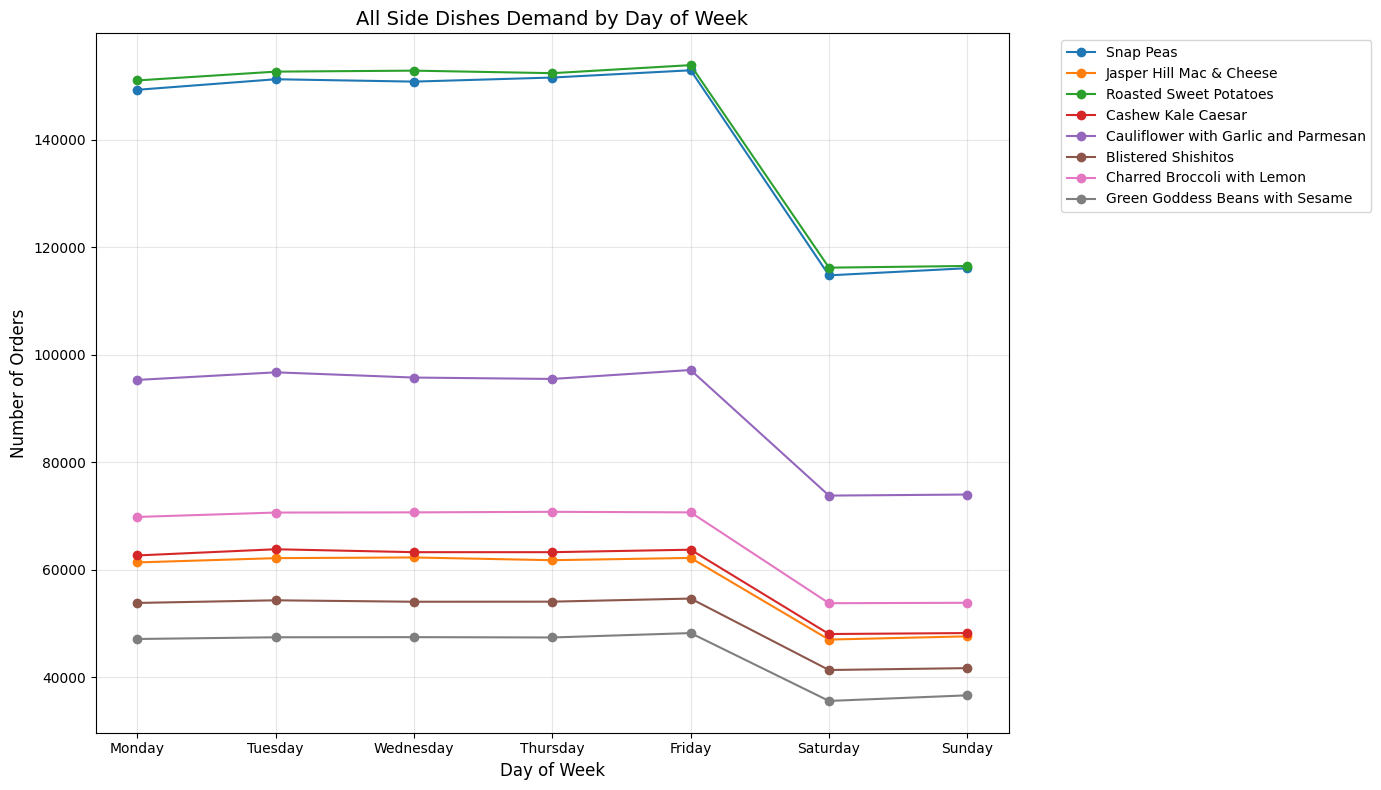

In [ ]:
# Same for SIDE dishes. / Anthropic. (2025, May 20). Python code for analyze side dishes in days trend [Source code]. Claude 3.7 Sonnet. https://claude.ai
def simple_side_dish_by_day():
    global df_items, df_orders_7_restaurants

    # 1. Create a mapping from SIDE_ID to ITEM_NAME
    side_names = {}
    for _, row in df_items.iterrows():
        side_names[row['ITEM_ID']] = row['ITEM_NAME']

    # 2. Extract day of week from DATETIME
    df_orders_7_restaurants['DATETIME'] = pd.to_datetime(df_orders_7_restaurants['DATETIME'])
    df_orders_7_restaurants['DAY_OF_WEEK'] = df_orders_7_restaurants['DATETIME'].dt.dayofweek
    df_orders_7_restaurants['DAY_NAME'] = df_orders_7_restaurants['DATETIME'].dt.day_name()

    # 3. Create two dataframes: one for SIDE_1 and one for SIDE_2
    # For SIDE_1
    side1_data = df_orders_7_restaurants[['DAY_NAME', 'SIDE_1']].copy()
    side1_data.columns = ['DAY_NAME', 'SIDE_ID']

    # For SIDE_2
    side2_data = df_orders_7_restaurants[['DAY_NAME', 'SIDE_2']].copy()
    side2_data.columns = ['DAY_NAME', 'SIDE_ID']

    # 4. Combine both side dataframes
    all_sides = pd.concat([side1_data, side2_data])

    # 5. Add side dish name and remove null sides
    all_sides['SIDE_NAME'] = all_sides['SIDE_ID'].map(side_names)
    all_sides = all_sides.dropna(subset=['SIDE_NAME'])

    # 6. Get ALL unique side dishes (instead of just top 5)
    unique_sides = all_sides['SIDE_NAME'].unique()

    # Print info about side dishes found
    print(f"Total unique side dishes found: {len(unique_sides)}")
    print("Side dishes:")
    for i, side in enumerate(unique_sides, 1):
        count = all_sides[all_sides['SIDE_NAME'] == side].shape[0]
        print(f"{i}. {side} (ordered {count} times)")

    # 7. Create the plot with adjusted size for more items
    plt.figure(figsize=(14, 8))

    # Day order to ensure correct sequence
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Plot for each side dish
    for side in unique_sides:
        # Get data for this side
        side_data = all_sides[all_sides['SIDE_NAME'] == side]

        # Group by day name and count
        day_counts = side_data.groupby('DAY_NAME').size().reindex(days_order, fill_value=0)

        # Plot
        plt.plot(day_counts.index, day_counts.values, marker='o', label=side)

    plt.title('All Side Dishes Demand by Day of Week', fontsize=14)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Move the legend outside the plot to make it more readable with many items
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Run the modified function
simple_side_dish_by_day()

<ipython-input-45-d93cdd5e44f0>:29: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



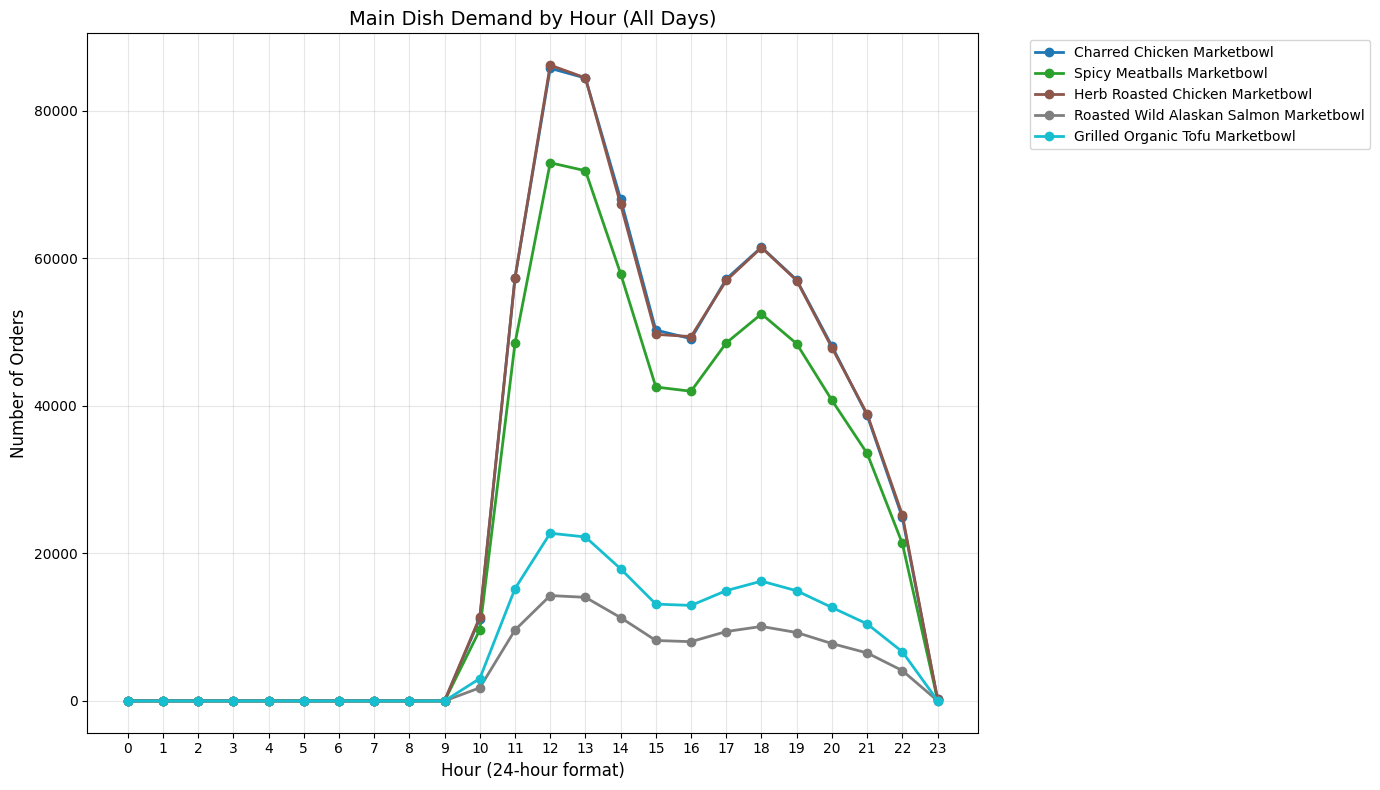

Color mapping for dishes:
Charred Chicken Marketbowl: (np.float64(0.12156862745098039), np.float64(0.4666666666666667), np.float64(0.7058823529411765), np.float64(1.0))
Spicy Meatballs Marketbowl: (np.float64(0.17254901960784313), np.float64(0.6274509803921569), np.float64(0.17254901960784313), np.float64(1.0))
Herb Roasted Chicken Marketbowl: (np.float64(0.5490196078431373), np.float64(0.33725490196078434), np.float64(0.29411764705882354), np.float64(1.0))
Roasted Wild Alaskan Salmon Marketbowl: (np.float64(0.4980392156862745), np.float64(0.4980392156862745), np.float64(0.4980392156862745), np.float64(1.0))
Grilled Organic Tofu Marketbowl: (np.float64(0.09019607843137255), np.float64(0.7450980392156863), np.float64(0.8117647058823529), np.float64(1.0))


In [ ]:
# We analyze now if there is a trend during the working hours
def main_dishes_by_hour_with_colors():
    global df_items, df_orders_7_restaurants

    # 1. Create mapping from MAIN_ID to ITEM_NAME
    main_names = {}
    for _, row in df_items.iterrows():
        main_names[row['ITEM_ID']] = row['ITEM_NAME']

    # 2. Extract hour from DATETIME
    df_orders_7_restaurants['DATETIME'] = pd.to_datetime(df_orders_7_restaurants['DATETIME'])
    df_orders_7_restaurants['HOUR'] = df_orders_7_restaurants['DATETIME'].dt.hour

    # 3. Add main dish name
    df_orders_7_restaurants['MAIN_NAME'] = df_orders_7_restaurants['MAIN'].map(main_names)

    # 4. Filter for orders with valid main dish
    main_orders = df_orders_7_restaurants[df_orders_7_restaurants['MAIN_NAME'].notna()]

    # 5. Get all unique main dishes
    unique_mains = main_orders['MAIN_NAME'].unique()

    # 6. Define a color map for consistent colors across all graphs
    # We'll create a global dictionary mapping each dish to a specific color
    global dish_colors
    dish_colors = {}

    # Use a colormap with distinct colors
    cmap = plt.cm.get_cmap('tab10', len(unique_mains))

    for i, dish in enumerate(unique_mains):
        dish_colors[dish] = cmap(i)

    # 7. Create the plot
    plt.figure(figsize=(14, 8))

    # Plot for each main dish
    for dish in unique_mains:
        # Get data for this dish
        dish_data = main_orders[main_orders['MAIN_NAME'] == dish]

        # Group by hour and count
        hour_counts = dish_data.groupby('HOUR').size()

        # Make sure all hours are included (0-23)
        all_hours = pd.Series(index=range(24), data=0)
        hour_counts = hour_counts.add(all_hours, fill_value=0)
        hour_counts = hour_counts.sort_index()

        # Plot with consistent color
        plt.plot(hour_counts.index, hour_counts.values, marker='o',
                 label=dish, color=dish_colors[dish], linewidth=2)

    plt.title('Main Dish Demand by Hour (All Days)', fontsize=14)
    plt.xlabel('Hour (24-hour format)', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

    # 8. Print the color mapping for reference
    print("Color mapping for dishes:")
    for dish, color in dish_colors.items():
        print(f"{dish}: {color}")

    # Return the color dictionary so it can be used in other functions
    return dish_colors

# Run the function and save the color mapping
dish_colors = main_dishes_by_hour_with_colors()

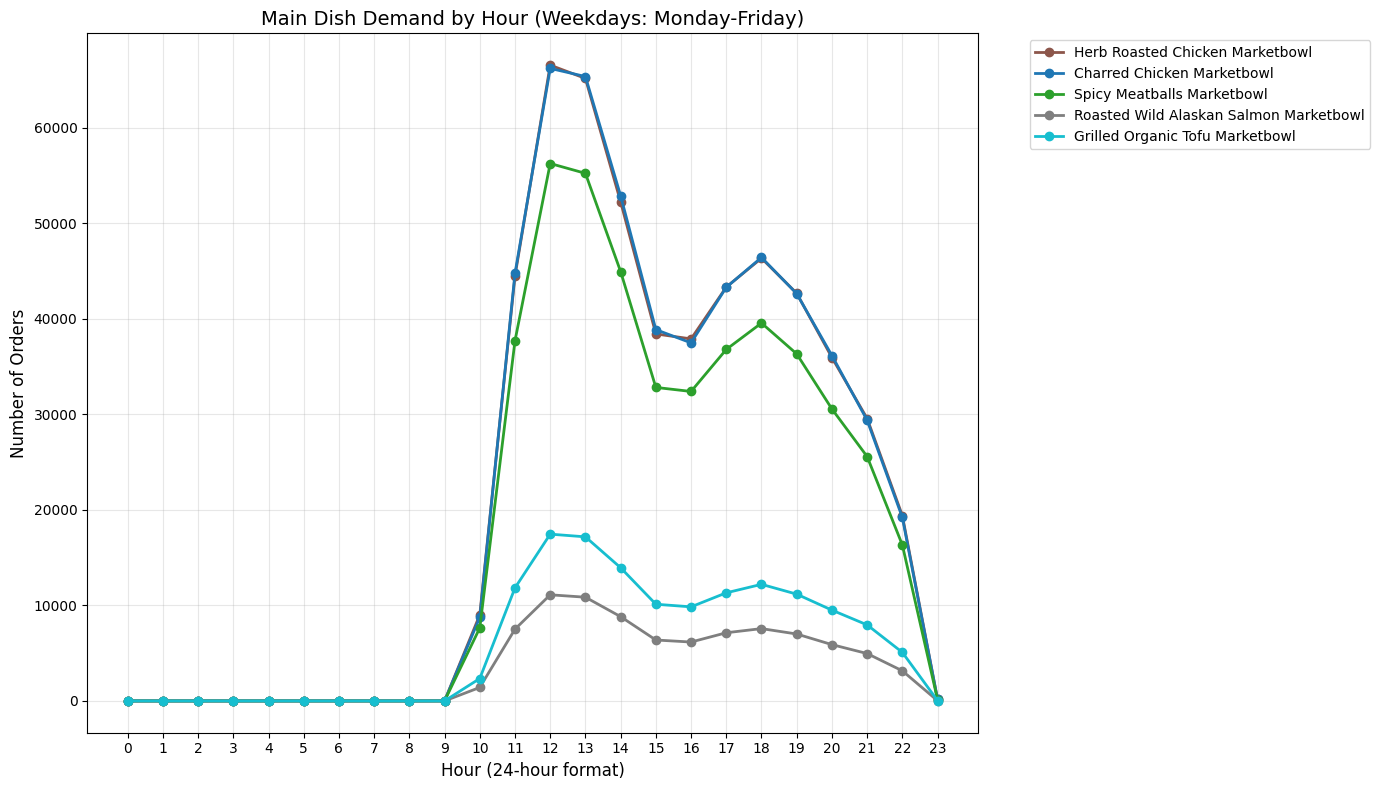

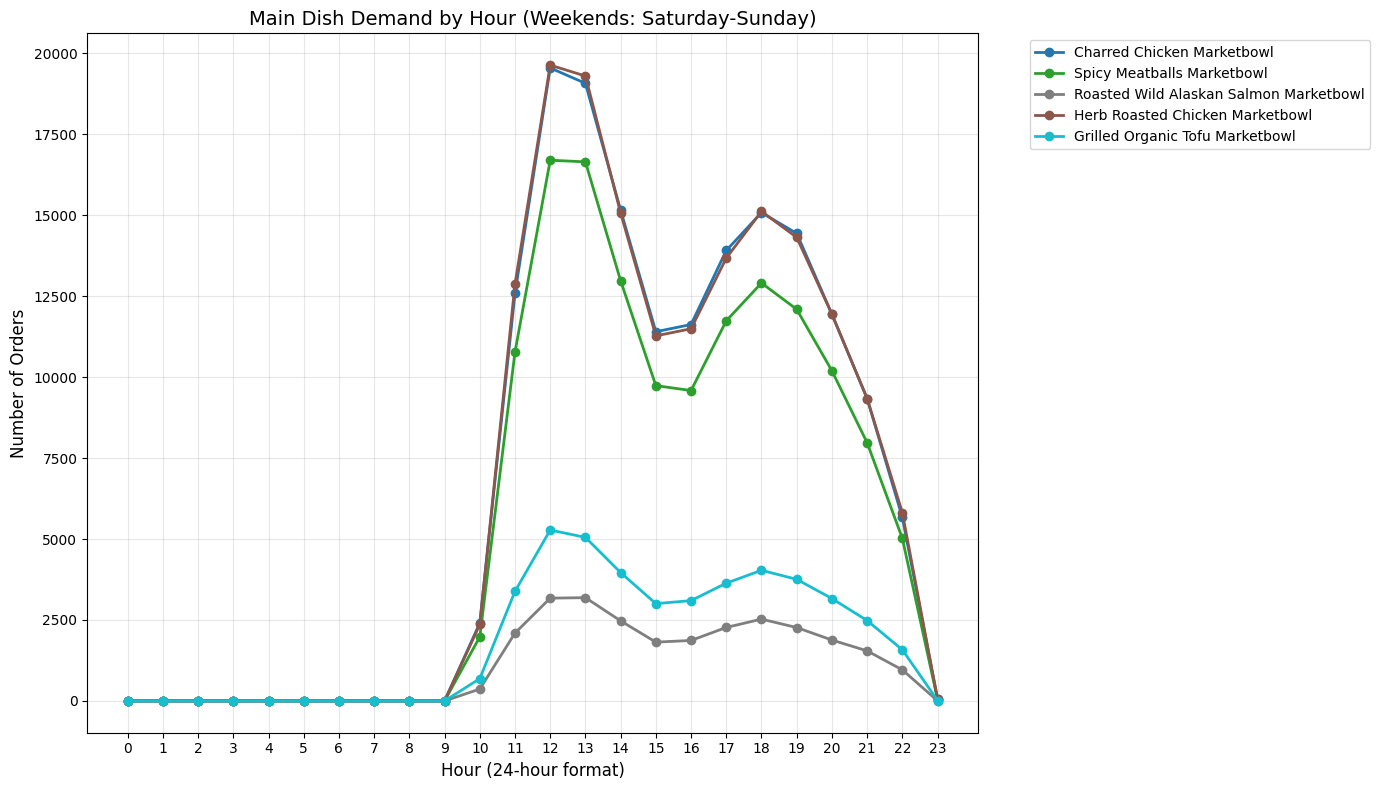

In [ ]:
# Now, we analyze if this trend continue if we divide the weekdays from the weekend days
def main_dishes_by_hour_weekdays_with_colors():
    global df_items, df_orders_7_restaurants, dish_colors

    # 1. Create mapping from MAIN_ID to ITEM_NAME
    main_names = {}
    for _, row in df_items.iterrows():
        main_names[row['ITEM_ID']] = row['ITEM_NAME']

    # 2. Extract hour and day of week from DATETIME
    df_orders_7_restaurants['DATETIME'] = pd.to_datetime(df_orders_7_restaurants['DATETIME'])
    df_orders_7_restaurants['HOUR'] = df_orders_7_restaurants['DATETIME'].dt.hour
    df_orders_7_restaurants['DAY_OF_WEEK'] = df_orders_7_restaurants['DATETIME'].dt.dayofweek

    # 3. Add main dish name
    df_orders_7_restaurants['MAIN_NAME'] = df_orders_7_restaurants['MAIN'].map(main_names)

    # 4. Filter for orders with valid main dish AND weekdays only
    weekday_main_orders = df_orders_7_restaurants[
        (df_orders_7_restaurants['MAIN_NAME'].notna()) &
        (df_orders_7_restaurants['DAY_OF_WEEK'] <= 4)
    ]

    # 5. Get all unique main dishes
    unique_weekday_mains = weekday_main_orders['MAIN_NAME'].unique()

    # 6. Create the plot
    plt.figure(figsize=(14, 8))

    # Plot for each main dish
    for dish in unique_weekday_mains:
        # Get data for this dish
        dish_data = weekday_main_orders[weekday_main_orders['MAIN_NAME'] == dish]

        # Group by hour and count
        hour_counts = dish_data.groupby('HOUR').size()

        # Make sure all hours are included (0-23)
        all_hours = pd.Series(index=range(24), data=0)
        hour_counts = hour_counts.add(all_hours, fill_value=0)
        hour_counts = hour_counts.sort_index()

        # Plot with same color as in the overall graph
        plt.plot(hour_counts.index, hour_counts.values, marker='o',
                 label=dish, color=dish_colors.get(dish), linewidth=2)

    plt.title('Main Dish Demand by Hour (Weekdays: Monday-Friday)', fontsize=14)
    plt.xlabel('Hour (24-hour format)', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

# Function for main dishes by hour on weekends with consistent colors
def main_dishes_by_hour_weekends_with_colors():
    global df_items, df_orders_7_restaurants, dish_colors

    # 1. Create mapping from MAIN_ID to ITEM_NAME
    main_names = {}
    for _, row in df_items.iterrows():
        main_names[row['ITEM_ID']] = row['ITEM_NAME']

    # 2. Extract hour and day of week from DATETIME
    df_orders_7_restaurants['DATETIME'] = pd.to_datetime(df_orders_7_restaurants['DATETIME'])
    df_orders_7_restaurants['HOUR'] = df_orders_7_restaurants['DATETIME'].dt.hour
    df_orders_7_restaurants['DAY_OF_WEEK'] = df_orders_7_restaurants['DATETIME'].dt.dayofweek

    # 3. Add main dish name
    df_orders_7_restaurants['MAIN_NAME'] = df_orders_7_restaurants['MAIN'].map(main_names)

    # 4. Filter for orders with valid main dish AND weekend days only
    weekend_main_orders = df_orders_7_restaurants[
        (df_orders_7_restaurants['MAIN_NAME'].notna()) &
        (df_orders_7_restaurants['DAY_OF_WEEK'] >= 5)
    ]

    # 5. Get all unique main dishes
    unique_weekend_mains = weekend_main_orders['MAIN_NAME'].unique()

    # 6. Create the plot
    plt.figure(figsize=(14, 8))

    # Plot for each main dish
    for dish in unique_weekend_mains:
        # Get data for this dish
        dish_data = weekend_main_orders[weekend_main_orders['MAIN_NAME'] == dish]

        # Group by hour and count
        hour_counts = dish_data.groupby('HOUR').size()

        # Make sure all hours are included (0-23)
        all_hours = pd.Series(index=range(24), data=0)
        hour_counts = hour_counts.add(all_hours, fill_value=0)
        hour_counts = hour_counts.sort_index()

        # Plot with same color as in the overall graph
        plt.plot(hour_counts.index, hour_counts.values, marker='o',
                 label=dish, color=dish_colors.get(dish), linewidth=2)

    plt.title('Main Dish Demand by Hour (Weekends: Saturday-Sunday)', fontsize=14)
    plt.xlabel('Hour (24-hour format)', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

# Run the weekday and weekend functions with consistent colors
main_dishes_by_hour_weekdays_with_colors()
main_dishes_by_hour_weekends_with_colors()

Total unique side dishes found: 8
Side dishes:
1. Snap Peas (ordered 986450 times)
2. Jasper Hill Mac & Cheese (ordered 404399 times)
3. Roasted Sweet Potatoes (ordered 995263 times)
4. Cashew Kale Caesar (ordered 412992 times)
5. Cauliflower with Garlic and Parmesan (ordered 628136 times)
6. Blistered Shishitos (ordered 353950 times)
7. Charred Broccoli with Lemon (ordered 460190 times)
8. Green Goddess Beans with Sesame (ordered 309898 times)


<ipython-input-47-9164cd6665f6>:45: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



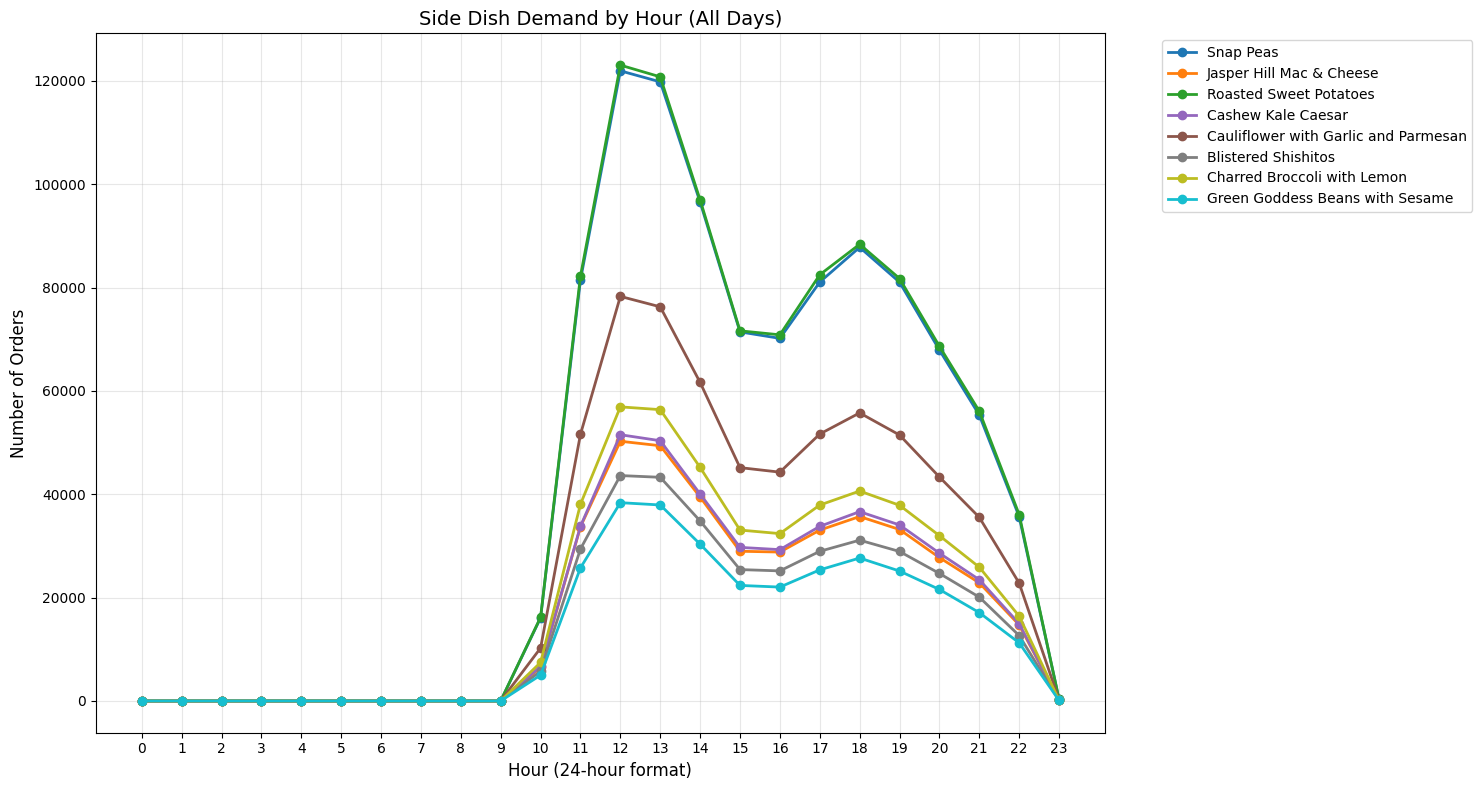

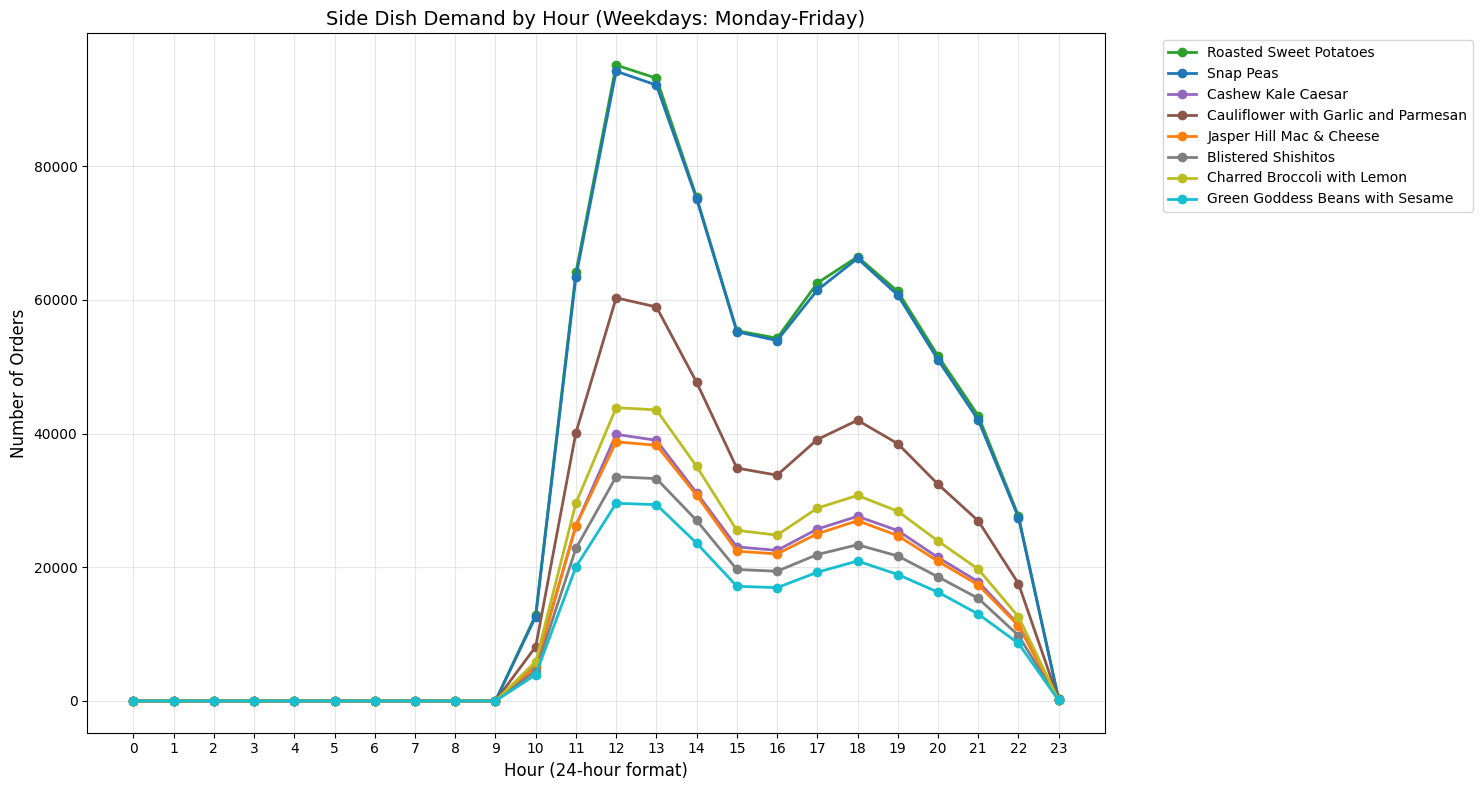

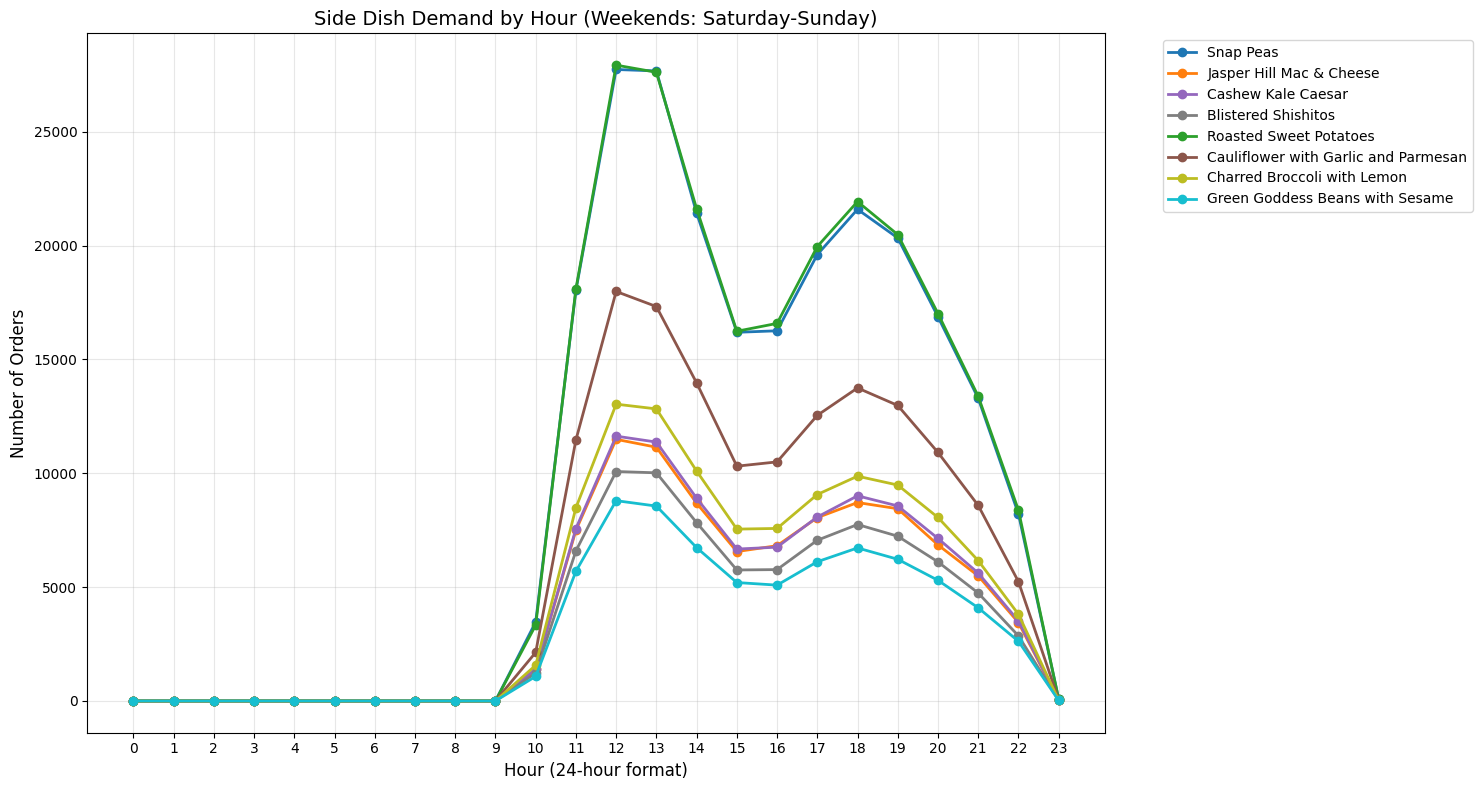

In [ ]:
# We do the same analysis for SIDE dishes
def all_side_dishes_by_hour_with_colors():
    global df_items, df_orders_7_restaurants

    # 1. Create mapping from SIDE_ID to ITEM_NAME
    side_names = {}
    for _, row in df_items.iterrows():
        side_names[row['ITEM_ID']] = row['ITEM_NAME']

    # 2. Extract hour from DATETIME
    df_orders_7_restaurants['DATETIME'] = pd.to_datetime(df_orders_7_restaurants['DATETIME'])
    df_orders_7_restaurants['HOUR'] = df_orders_7_restaurants['DATETIME'].dt.hour
    df_orders_7_restaurants['DAY_OF_WEEK'] = df_orders_7_restaurants['DATETIME'].dt.dayofweek

    # 3. Create two dataframes: one for SIDE_1 and one for SIDE_2
    # For SIDE_1
    side1_data = df_orders_7_restaurants[['HOUR', 'DAY_OF_WEEK', 'SIDE_1']].copy()
    side1_data.columns = ['HOUR', 'DAY_OF_WEEK', 'SIDE_ID']

    # For SIDE_2
    side2_data = df_orders_7_restaurants[['HOUR', 'DAY_OF_WEEK', 'SIDE_2']].copy()
    side2_data.columns = ['HOUR', 'DAY_OF_WEEK', 'SIDE_ID']

    # 4. Combine both side dataframes
    all_sides = pd.concat([side1_data, side2_data])

    # 5. Add side dish name and remove null sides
    all_sides['SIDE_NAME'] = all_sides['SIDE_ID'].map(side_names)
    all_sides = all_sides.dropna(subset=['SIDE_NAME'])

    # 6. Get all unique side dishes
    unique_sides = all_sides['SIDE_NAME'].unique()

    print(f"Total unique side dishes found: {len(unique_sides)}")
    print("Side dishes:")
    for i, side in enumerate(unique_sides, 1):
        count = all_sides[all_sides['SIDE_NAME'] == side].shape[0]
        print(f"{i}. {side} (ordered {count} times)")

    # 7. Define a color map for consistent colors across all graphs
    global side_colors
    side_colors = {}

    # Use a colormap with distinct colors
    cmap = plt.cm.get_cmap('tab10', len(unique_sides))

    for i, side in enumerate(unique_sides):
        side_colors[side] = cmap(i)

    # 8. Create the plot for ALL days
    plt.figure(figsize=(15, 8))

    # Plot for each side dish
    for side in unique_sides:
        # Get data for this side
        side_data = all_sides[all_sides['SIDE_NAME'] == side]

        # Group by hour and count
        hour_counts = side_data.groupby('HOUR').size()

        # Make sure all hours are included (0-23)
        all_hours = pd.Series(index=range(24), data=0)
        hour_counts = hour_counts.add(all_hours, fill_value=0)
        hour_counts = hour_counts.sort_index()

        # Plot with consistent color
        plt.plot(hour_counts.index, hour_counts.values, marker='o',
                 label=side, color=side_colors[side], linewidth=2)

    plt.title('Side Dish Demand by Hour (All Days)', fontsize=14)
    plt.xlabel('Hour (24-hour format)', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

    # Return the color dictionary so it can be used in other functions
    return side_colors, all_sides

# Now create the functions for weekdays and weekends using the same colors
def side_dishes_by_hour_weekdays_with_colors(side_colors, all_sides):
    # Filter for weekdays only (0-4 = Monday-Friday)
    weekday_sides = all_sides[all_sides['DAY_OF_WEEK'] <= 4]

    # Get unique side dishes in weekdays
    unique_weekday_sides = weekday_sides['SIDE_NAME'].unique()

    # Create the plot
    plt.figure(figsize=(15, 8))

    # Plot for each side dish
    for side in unique_weekday_sides:
        # Get data for this side
        side_data = weekday_sides[weekday_sides['SIDE_NAME'] == side]

        # Group by hour and count
        hour_counts = side_data.groupby('HOUR').size()

        # Make sure all hours are included (0-23)
        all_hours = pd.Series(index=range(24), data=0)
        hour_counts = hour_counts.add(all_hours, fill_value=0)
        hour_counts = hour_counts.sort_index()

        # Plot with same color as in the overall graph
        plt.plot(hour_counts.index, hour_counts.values, marker='o',
                 label=side, color=side_colors.get(side), linewidth=2)

    plt.title('Side Dish Demand by Hour (Weekdays: Monday-Friday)', fontsize=14)
    plt.xlabel('Hour (24-hour format)', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

def side_dishes_by_hour_weekends_with_colors(side_colors, all_sides):
    # Filter for weekends only (5-6 = Saturday-Sunday)
    weekend_sides = all_sides[all_sides['DAY_OF_WEEK'] >= 5]

    # Get unique side dishes in weekends
    unique_weekend_sides = weekend_sides['SIDE_NAME'].unique()

    # Create the plot
    plt.figure(figsize=(15, 8))

    # Plot for each side dish
    for side in unique_weekend_sides:
        # Get data for this side
        side_data = weekend_sides[weekend_sides['SIDE_NAME'] == side]

        # Group by hour and count
        hour_counts = side_data.groupby('HOUR').size()

        # Make sure all hours are included (0-23)
        all_hours = pd.Series(index=range(24), data=0)
        hour_counts = hour_counts.add(all_hours, fill_value=0)
        hour_counts = hour_counts.sort_index()

        # Plot with same color as in the overall graph
        plt.plot(hour_counts.index, hour_counts.values, marker='o',
                 label=side, color=side_colors.get(side), linewidth=2)

    plt.title('Side Dish Demand by Hour (Weekends: Saturday-Sunday)', fontsize=14)
    plt.xlabel('Hour (24-hour format)', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

# Run all functions in sequence
side_colors, all_sides_data = all_side_dishes_by_hour_with_colors()
side_dishes_by_hour_weekdays_with_colors(side_colors, all_sides_data)
side_dishes_by_hour_weekends_with_colors(side_colors, all_sides_data)

## 3.4 Items by Restaurant


###3.4.1 Main

#### 3.4.1.1 All time

In [ ]:
# Group by restaurant and main (Google, 2025)

df_orders_items_analysis = df_orders_7

# Add ID
main_id = {'Charred Chicken Marketbowl':1, 'Herb Roasted Chicken Marketbowl':2, 'Spicy Meatballs Marketbowl':3, 'Grilled Organic Tofu Marketbowl':4, 'Roasted Wild Alaskan Salmon Marketbowl':5}
df_orders_items_analysis['MAIN_ID'] = df_orders_items_analysis['MAIN_NAME'].map(main_id)

# Groupby
df_restaurant = df_orders_items_analysis.groupby(['RESTAURANT_NAME','MAIN_NAME','MAIN_ID']).size()
df_restaurant = df_restaurant.reset_index()
df_restaurant.columns = ['RESTAURANT_NAME','ITEM_NAME', 'ITEM_ID', 'COUNT']
df_restaurant = df_restaurant.sort_values(by=['RESTAURANT_NAME','ITEM_ID'], ascending=False)

# Calculate total orders per restaurant
total_orders_per_restaurant = df_restaurant.groupby('RESTAURANT_NAME')['COUNT'].sum().reset_index(name='TOTAL_RESTAURANT_ORDERS')
total_orders_per_restaurant.columns = ['RESTAURANT_NAME', 'TOTAL_RESTAURANT_ORDERS']

# Merge the total orders back to the main_restaurant dataframe
df_restaurant = pd.merge(df_restaurant, total_orders_per_restaurant, on='RESTAURANT_NAME')

# Calculate the percentage
df_restaurant['PERCENTAGE'] = (df_restaurant['COUNT'] / df_restaurant['TOTAL_RESTAURANT_ORDERS']) * 100

# Separate by restaurant
df_restaurant_B = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Bryant Park']
df_restaurant_C = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Columbia']
df_restaurant_F = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Flatiron']
df_restaurant_M = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Midtown']
df_restaurant_N = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'NYU']
df_restaurant_UE = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Upper East Side']
df_restaurant_UW = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Upper West Side']
df_restaurant_W = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Williamsburg']

df_restaurant.head(10)

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME                               ITEM_NAME  ITEM_ID  COUNT  \
0     Williamsburg  Roasted Wild Alaskan Salmon Marketbowl      5.0  14835   
1     Williamsburg         Grilled Organic Tofu Marketbowl      4.0  24236   
2     Williamsburg              Spicy Meatballs Marketbowl      3.0  77987   
3     Williamsburg         Herb Roasted Chicken Marketbowl      2.0  91499   
4     Williamsburg              Charred Chicken Marketbowl      1.0  91265   
5  Upper West Side  Roasted Wild Alaskan Salmon Marketbowl      5.0  13491   
6  Upper West Side         Grilled Organic Tofu Marketbowl      4.0  21245   
7  Upper West Side              Spicy Meatballs Marketbowl      3.0  69817   
8  Upper West Side         Herb Roasted Chicken Marketbowl      2.0  81636   
9  Upper West Side              Charred Chicken Marketbowl      1.0  81834   

   TOTAL_RESTAURANT_ORDERS  PERCENTAGE  
0                   299822    4.947936  
1                   299822    8.083463  
2                   299822   26.011100  
3                   299822   30.517774  
4                   299822   30.439728  
5                   268023    5.033523  
6                   268023    7.926559  
7                   268023   26.048884  
8                   268023   30.458580  
9                   268023   30.532454

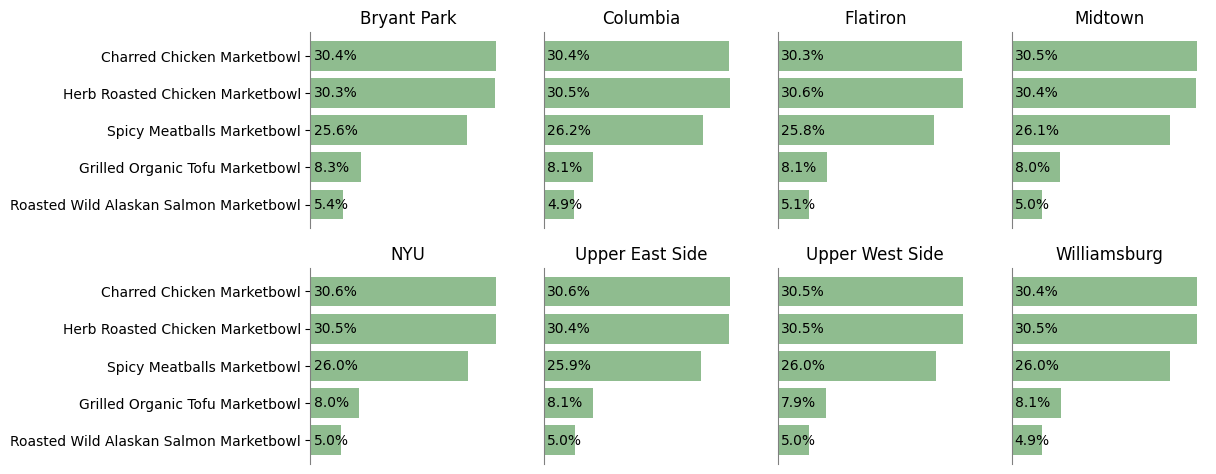

In [ ]:
# Plot by restaurant and main (Google, 2025)

title = 'Main Popularity by Restaurant'
fig = plt.figure()

# Graph visual set (OpenAI, 2025)
ax1 = fig.add_subplot(241, title="Bryant Park")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])

ax2 = fig.add_subplot(242, title="Columbia")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax3 = fig.add_subplot(243, title="Flatiron")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax4 = fig.add_subplot(244, title="Midtown")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax5 = fig.add_subplot(245, title="NYU")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])

ax6 = fig.add_subplot(246, title="Upper East Side")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax7 = fig.add_subplot(247, title="Upper West Side")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax8 = fig.add_subplot(248, title="Williamsburg")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

# Format data labels (OpenAI, 2025)
df_ax1_label = (round(df_restaurant_B['PERCENTAGE'], 1)).astype(str) + '%'
df_ax2_label = (round(df_restaurant_C['PERCENTAGE'], 1)).astype(str) + '%'
df_ax3_label = (round(df_restaurant_F['PERCENTAGE'], 1)).astype(str) + '%'
df_ax4_label = (round(df_restaurant_M['PERCENTAGE'], 1)).astype(str) + '%'
df_ax5_label = (round(df_restaurant_N['PERCENTAGE'], 1)).astype(str) + '%'
df_ax6_label = (round(df_restaurant_UE['PERCENTAGE'], 1)).astype(str) + '%'
df_ax7_label = (round(df_restaurant_UW['PERCENTAGE'], 1)).astype(str) + '%'
df_ax8_label = (round(df_restaurant_W['PERCENTAGE'], 1)).astype(str) + '%'

# Plot and add datalabels (OpenAI, 2025)
plt.subplots_adjust(left=0.1, right=1.5, top=1, bottom=0.1)

ax1.barh(df_restaurant_B['ITEM_NAME'], df_restaurant_B['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_B['PERCENTAGE']):
    ax1.text(0.5, i, df_ax1_label.values[i], va='center', color='black')

ax2.barh(df_restaurant_C['ITEM_NAME'], df_restaurant_C['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_C['PERCENTAGE']):
    ax2.text(0.5, i, df_ax2_label.values[i], va='center', color='black')

ax3.barh(df_restaurant_F['ITEM_NAME'], df_restaurant_F['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_F['PERCENTAGE']):
    ax3.text(0.5, i, df_ax3_label.values[i], va='center', color='black')

ax4.barh(df_restaurant_M['ITEM_NAME'], df_restaurant_M['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_M['PERCENTAGE']):
    ax4.text(0.5, i, df_ax4_label.values[i], va='center', color='black')

ax5.barh(df_restaurant_N['ITEM_NAME'], df_restaurant_N['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_N['PERCENTAGE']):
    ax5.text(0.5, i, df_ax5_label.values[i], va='center', color='black')

ax6.barh(df_restaurant_UE['ITEM_NAME'], df_restaurant_UE['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_UE['PERCENTAGE']):
    ax6.text(0.5, i, df_ax6_label.values[i], va='center', color='black')

ax7.barh(df_restaurant_UW['ITEM_NAME'], df_restaurant_UW['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_UW['PERCENTAGE']):
    ax7.text(0.5, i, df_ax7_label.values[i], va='center', color='black')

ax8.barh(df_restaurant_W['ITEM_NAME'], df_restaurant_W['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_W['PERCENTAGE']):
    ax8.text(0.5, i, df_ax8_label.values[i], va='center', color='black')

#plt.savefig(title+'.png')
plt.show()

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

No significant difference between restaurants

####3.4.1.2 By Month

In [ ]:
# Group by restaurant and main in month (Google, 2025)

df_orders_items_Main = df_orders_items_analysis

df_orders_items_Main['ORDER_MONTH'] = df_orders_items_Main['DATETIME'].dt.month

# Groupby month
monthly_orders = df_orders_items_Main.groupby(['RESTAURANT_NAME','MAIN_NAME','MAIN_ID', 'ORDER_MONTH']).size()
monthly_orders = monthly_orders.reset_index()
monthly_orders.columns = ['RESTAURANT_NAME','ITEM_NAME', 'ITEM_ID', 'ORDER_MONTH', 'ORDER_COUNT']

# Separate by restaurant
monthly_orders_B = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Bryant Park']
monthly_orders_C = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Columbia']
monthly_orders_F = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Flatiron']
monthly_orders_M = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Midtown']
monthly_orders_N = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'NYU']
monthly_orders_UE = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Upper East Side']
monthly_orders_UW = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Upper West Side']
monthly_orders_W = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Williamsburg']

monthly_orders

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME                   ITEM_NAME  ITEM_ID  ORDER_MONTH  \
0       Bryant Park  Charred Chicken Marketbowl      1.0            1   
1       Bryant Park  Charred Chicken Marketbowl      1.0            2   
2       Bryant Park  Charred Chicken Marketbowl      1.0            3   
3       Bryant Park  Charred Chicken Marketbowl      1.0            4   
4       Bryant Park  Charred Chicken Marketbowl      1.0            5   
..              ...                         ...      ...          ...   
475    Williamsburg  Spicy Meatballs Marketbowl      3.0            8   
476    Williamsburg  Spicy Meatballs Marketbowl      3.0            9   
477    Williamsburg  Spicy Meatballs Marketbowl      3.0           10   
478    Williamsburg  Spicy Meatballs Marketbowl      3.0           11   
479    Williamsburg  Spicy Meatballs Marketbowl      3.0           12   

     ORDER_COUNT  
0           5425  
1           5067  
2           5570  
3           5402  
4           5895  
..           ...  
475         5908  
476         6355  
477         6710  
478         6910  
479         7036  

[480 rows x 5 columns]

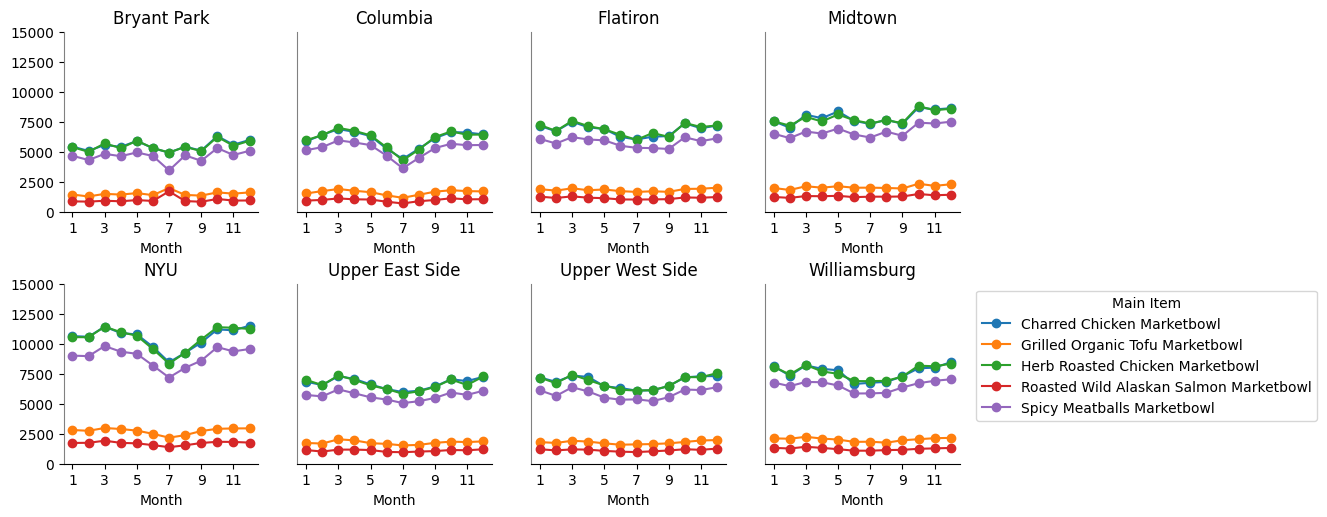

In [ ]:
# Plot by restaurant and main by month (Google, 2025)
title = 'Main Popularity by Restaurant and Month'
fig = plt.figure()

# Graph visual set (OpenAI, 2025)
ax1 = fig.add_subplot(241, title="Bryant Park")
ax1.set_xlabel('Month')
ax1.set_ylim(0,15000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks(np.arange(1, 12, step=2))

ax2 = fig.add_subplot(242, title="Columbia")
ax2.set_xlabel('Month')
ax2.set_ylim(0,15000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax3 = fig.add_subplot(243, title="Flatiron")
ax3.set_xlabel('Month')
ax3.set_ylim(0,15000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax4 = fig.add_subplot(244, title="Midtown")
ax4.set_xlabel('Month')
ax4.set_ylim(0,15000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax5 = fig.add_subplot(245, title="NYU")
ax5.set_xlabel('Month')
ax5.set_ylim(0,15000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks(np.arange(1, 12, step=2))

ax6 = fig.add_subplot(246, title="Upper East Side")
ax6.set_xlabel('Month')
ax6.set_ylim(0,15000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax7 = fig.add_subplot(247, title="Upper West Side")
ax7.set_xlabel('Month')
ax7.set_ylim(0,15000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax8 = fig.add_subplot(248, title="Williamsburg")
ax8.set_xlabel('Month')
ax8.set_ylim(0,15000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

# Plot and add datalabels (OpenAI, 2025)
plt.subplots_adjust(left=0.1, right=1.5, top=1, bottom=0.1, hspace=0.4)

# Filter for Bryant Park orders
bryant_park_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Bryant Park']
columbias_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Columbia']
flatirons_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Flatiron']
midtowns_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Midtown']
nyus_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'NYU']
upper_east_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Upper East Side']
upper_west_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Upper West Side']
williamsburg_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Williamsburg']

# Pivot the table to have hours as index, items as columns, and order count as values
bryant_park_pivot = bryant_park_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
columbias_pivot = columbias_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
flatirons_pivot = flatirons_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
midtowns_pivot = midtowns_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
nyus_pivot = nyus_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
upper_east_pivot = upper_east_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
upper_west_pivot = upper_west_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
williamsburg_pivot = williamsburg_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)

# Plotting
for column in bryant_park_pivot.columns:
    ax1.plot(bryant_park_pivot.index, bryant_park_pivot[column], marker='o', linestyle='-', label=column)
for column in columbias_pivot.columns:
    ax2.plot(columbias_pivot.index, columbias_pivot[column], marker='o', linestyle='-', label=column)
for column in flatirons_pivot.columns:
    ax3.plot(flatirons_pivot.index, flatirons_pivot[column], marker='o', linestyle='-', label=column)
for column in midtowns_pivot.columns:
    ax4.plot(midtowns_pivot.index, midtowns_pivot[column], marker='o', linestyle='-', label=column)
for column in nyus_pivot.columns:
    ax5.plot(nyus_pivot.index, nyus_pivot[column], marker='o', linestyle='-', label=column)
for column in upper_east_pivot.columns:
    ax6.plot(upper_east_pivot.index, upper_east_pivot[column], marker='o', linestyle='-', label=column)
for column in upper_west_pivot.columns:
    ax7.plot(upper_west_pivot.index, upper_west_pivot[column], marker='o', linestyle='-', label=column)
for column in williamsburg_pivot.columns:
    ax8.plot(williamsburg_pivot.index, williamsburg_pivot[column], marker='o', linestyle='-', label=column)

plt.legend(title='Main Item', bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.savefig(title+'.png')
plt.show()

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

Each main does not behave differently from month to month at each restaurant.

####3.4.1.3 By Hour

In [ ]:
# Group by restaurant and main in hour (Google, 2025)

df_orders_items_Main = df_orders_items_analysis

df_orders_items_Main['ORDER_HOUR'] = df_orders_items_Main['DATETIME'].dt.hour

# Groupby hour
hourly_orders = df_orders_items_Main.groupby(['RESTAURANT_NAME','MAIN_NAME','MAIN_ID', 'ORDER_HOUR']).size()
hourly_orders = hourly_orders.reset_index()
hourly_orders.columns = ['RESTAURANT_NAME','ITEM_NAME', 'ITEM_ID', 'ORDER_HOUR', 'ORDER_COUNT']

# Separate by restaurant
hourly_orders_B = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Bryant Park']
hourly_orders_C = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Columbia']
hourly_orders_F = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Flatiron']
hourly_orders_M = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Midtown']
hourly_orders_N = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'NYU']
hourly_orders_UE = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Upper East Side']
hourly_orders_UW = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Upper West Side']
hourly_orders_W = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Williamsburg']

hourly_orders.head(20)

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME                        ITEM_NAME  ITEM_ID  ORDER_HOUR  \
0      Bryant Park       Charred Chicken Marketbowl      1.0          10   
1      Bryant Park       Charred Chicken Marketbowl      1.0          11   
2      Bryant Park       Charred Chicken Marketbowl      1.0          12   
3      Bryant Park       Charred Chicken Marketbowl      1.0          13   
4      Bryant Park       Charred Chicken Marketbowl      1.0          14   
5      Bryant Park       Charred Chicken Marketbowl      1.0          15   
6      Bryant Park       Charred Chicken Marketbowl      1.0          16   
7      Bryant Park       Charred Chicken Marketbowl      1.0          17   
8      Bryant Park       Charred Chicken Marketbowl      1.0          18   
9      Bryant Park       Charred Chicken Marketbowl      1.0          19   
10     Bryant Park       Charred Chicken Marketbowl      1.0          20   
11     Bryant Park       Charred Chicken Marketbowl      1.0          21   
12     Bryant Park       Charred Chicken Marketbowl      1.0          22   
13     Bryant Park       Charred Chicken Marketbowl      1.0          23   
14     Bryant Park  Grilled Organic Tofu Marketbowl      4.0          10   
15     Bryant Park  Grilled Organic Tofu Marketbowl      4.0          11   
16     Bryant Park  Grilled Organic Tofu Marketbowl      4.0          12   
17     Bryant Park  Grilled Organic Tofu Marketbowl      4.0          13   
18     Bryant Park  Grilled Organic Tofu Marketbowl      4.0          14   
19     Bryant Park  Grilled Organic Tofu Marketbowl      4.0          15   

    ORDER_COUNT  
0          1610  
1          6441  
2          9056  
3          9230  
4          7728  
5          5433  
6          4850  
7          4574  
8          4427  
9          3589  
10         3328  
11         3172  
12         2501  
13           20  
14          421  
15         1775  
16         2512  
17         2511  
18         2212  
19         1436

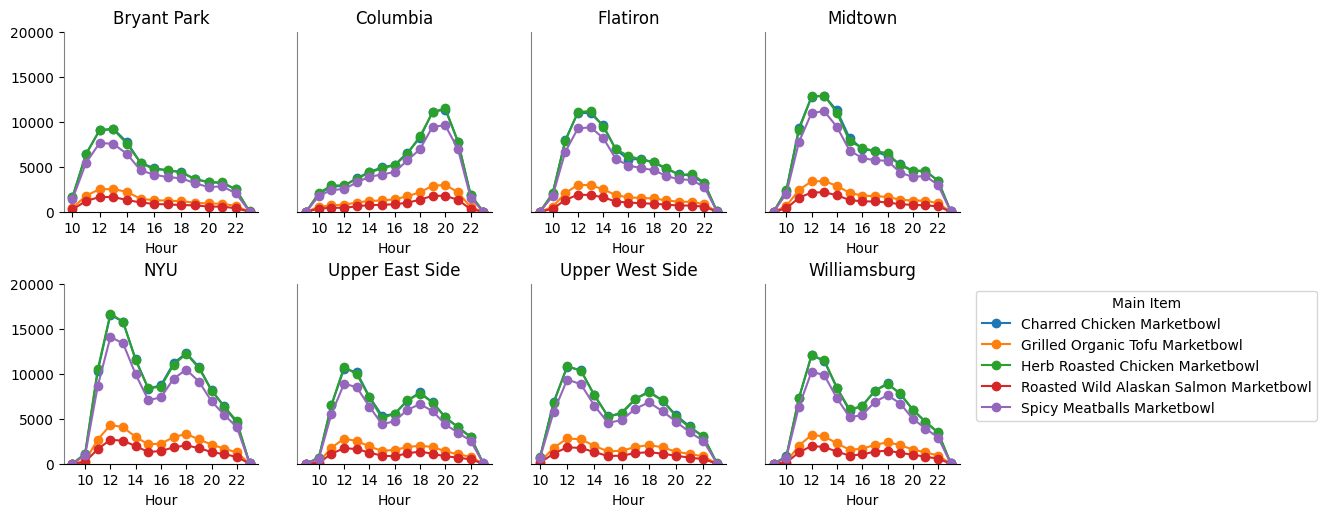

In [ ]:
# Plot by restaurant and main in hour (Google, 2025)
title = 'Main Popularity by Restaurant and Hour'
fig = plt.figure()

# Graph visual set (OpenAI, 2025)
ax1 = fig.add_subplot(241, title="Bryant Park")
ax1.set_xlabel('Hour')
ax1.set_ylim(0,20000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks(np.arange(10, 23, step=2))

ax2 = fig.add_subplot(242, title="Columbia")
ax2.set_xlabel('Hour')
ax2.set_ylim(0,20000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax3 = fig.add_subplot(243, title="Flatiron")
ax3.set_xlabel('Hour')
ax3.set_ylim(0,20000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax4 = fig.add_subplot(244, title="Midtown")
ax4.set_xlabel('Hour')
ax4.set_ylim(0,20000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax5 = fig.add_subplot(245, title="NYU")
ax5.set_xlabel('Hour')
ax5.set_ylim(0,20000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks(np.arange(10, 23, step=2))

ax6 = fig.add_subplot(246, title="Upper East Side")
ax6.set_xlabel('Hour')
ax6.set_ylim(0,20000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax7 = fig.add_subplot(247, title="Upper West Side")
ax7.set_xlabel('Hour')
ax7.set_ylim(0,20000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax8 = fig.add_subplot(248, title="Williamsburg")
ax8.set_xlabel('Hour')
ax8.set_ylim(0,20000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

# Plot and add datalabels (OpenAI, 2025)
plt.subplots_adjust(left=0.1, right=1.5, top=1, bottom=0.1, hspace=0.4)

# Filter for Bryant Park orders
bryant_park_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Bryant Park']
columbias_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Columbia']
flatirons_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Flatiron']
midtowns_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Midtown']
nyus_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'NYU']
upper_east_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Upper East Side']
upper_west_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Upper West Side']
williamsburg_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Williamsburg']

# Pivot the table to have hours as index, items as columns, and order count as values
bryant_park_pivot = bryant_park_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
columbias_pivot = columbias_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
flatirons_pivot = flatirons_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
midtowns_pivot = midtowns_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
nyus_pivot = nyus_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
upper_east_pivot = upper_east_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
upper_west_pivot = upper_west_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
williamsburg_pivot = williamsburg_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)

# Plotting
for column in bryant_park_pivot.columns:
    ax1.plot(bryant_park_pivot.index, bryant_park_pivot[column], marker='o', linestyle='-', label=column)
for column in columbias_pivot.columns:
    ax2.plot(columbias_pivot.index, columbias_pivot[column], marker='o', linestyle='-', label=column)
for column in flatirons_pivot.columns:
    ax3.plot(flatirons_pivot.index, flatirons_pivot[column], marker='o', linestyle='-', label=column)
for column in midtowns_pivot.columns:
    ax4.plot(midtowns_pivot.index, midtowns_pivot[column], marker='o', linestyle='-', label=column)
for column in nyus_pivot.columns:
    ax5.plot(nyus_pivot.index, nyus_pivot[column], marker='o', linestyle='-', label=column)
for column in upper_east_pivot.columns:
    ax6.plot(upper_east_pivot.index, upper_east_pivot[column], marker='o', linestyle='-', label=column)
for column in upper_west_pivot.columns:
    ax7.plot(upper_west_pivot.index, upper_west_pivot[column], marker='o', linestyle='-', label=column)
for column in williamsburg_pivot.columns:
    ax8.plot(williamsburg_pivot.index, williamsburg_pivot[column], marker='o', linestyle='-', label=column)

plt.legend(title='Main Item', bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.savefig(title+'.png')
plt.show()

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

Each main does not behave differently at each restaurant at different hours.

### 3.4.2 Base

#### 3.4.2.1 All time

In [ ]:
# Group by restaurant and base (Google, 2025)

df_orders_items_analysis = df_orders_7

# Add ID
base_id = {'Farm Greens with Mint':1, 'Farro with Summer Vegetables':2, 'Classic Brown Rice':3}
df_orders_items_analysis['BASE_ID'] = df_orders_items_analysis['BASE_NAME'].map(base_id)

# Groupby
df_restaurant = df_orders_items_analysis.groupby(['RESTAURANT_NAME','BASE_NAME','BASE_ID']).size()
df_restaurant = df_restaurant.reset_index()
df_restaurant.columns = ['RESTAURANT_NAME','ITEM_NAME', 'ITEM_ID', 'COUNT']
df_restaurant = df_restaurant.sort_values(by=['RESTAURANT_NAME','ITEM_ID'], ascending=False)

# Calculate total orders per restaurant
total_orders_per_restaurant = df_restaurant.groupby('RESTAURANT_NAME')['COUNT'].sum().reset_index(name='TOTAL_RESTAURANT_ORDERS')
total_orders_per_restaurant.columns = ['RESTAURANT_NAME', 'TOTAL_RESTAURANT_ORDERS']

# Merge the total orders back to the main_restaurant dataframe
df_restaurant = pd.merge(df_restaurant, total_orders_per_restaurant, on='RESTAURANT_NAME')

# Calculate the percentage
df_restaurant['PERCENTAGE'] = (df_restaurant['COUNT'] / df_restaurant['TOTAL_RESTAURANT_ORDERS']) * 100

# Separate by restaurant
df_restaurant_B = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Bryant Park']
df_restaurant_C = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Columbia']
df_restaurant_F = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Flatiron']
df_restaurant_M = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Midtown']
df_restaurant_N = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'NYU']
df_restaurant_UE = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Upper East Side']
df_restaurant_UW = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Upper West Side']
df_restaurant_W = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Williamsburg']

df_restaurant.head(10)

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME                     ITEM_NAME  ITEM_ID   COUNT  \
0     Williamsburg            Classic Brown Rice      3.0   66765   
1     Williamsburg  Farro with Summer Vegetables      2.0  111996   
2     Williamsburg         Farm Greens with Mint      1.0  121061   
3  Upper West Side            Classic Brown Rice      3.0   59867   
4  Upper West Side  Farro with Summer Vegetables      2.0   99524   
5  Upper West Side         Farm Greens with Mint      1.0  108632   
6  Upper East Side            Classic Brown Rice      3.0   58671   
7  Upper East Side  Farro with Summer Vegetables      2.0   97777   
8  Upper East Side         Farm Greens with Mint      1.0  105509   
9              NYU            Classic Brown Rice      3.0   91860   

   TOTAL_RESTAURANT_ORDERS  PERCENTAGE  
0                   299822   22.268212  
1                   299822   37.354163  
2                   299822   40.377624  
3                   268023   22.336516  
4                   268023   37.132634  
5                   268023   40.530850  
6                   261957   22.397187  
7                   261957   37.325592  
8                   261957   40.277221  
9                   411253   22.336615

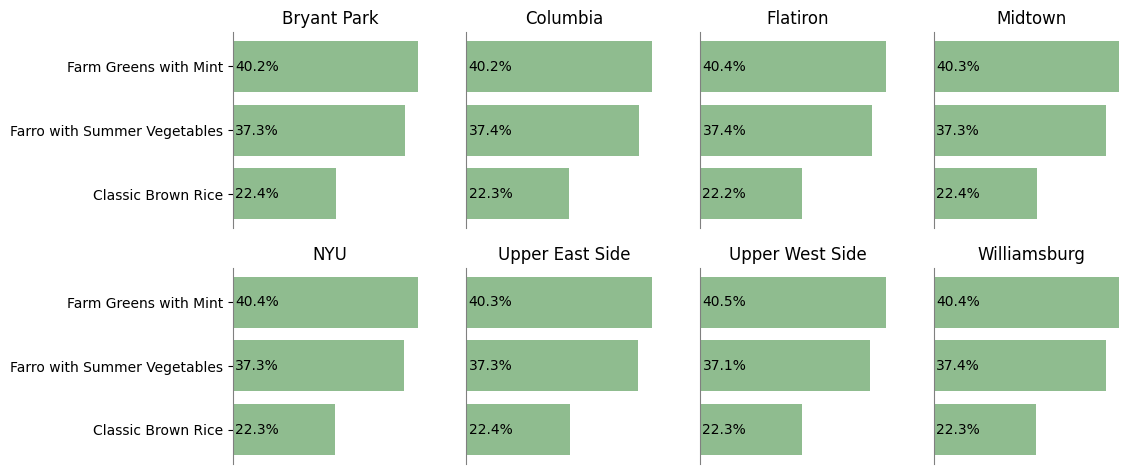

In [ ]:
# Plot by restaurant and base (Google, 2025)
title = 'Base Popularity by Restaurant'
fig = plt.figure()

# Graph visual set (OpenAI, 2025)
ax1 = fig.add_subplot(241, title="Bryant Park")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])

ax2 = fig.add_subplot(242, title="Columbia")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax3 = fig.add_subplot(243, title="Flatiron")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax4 = fig.add_subplot(244, title="Midtown")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax5 = fig.add_subplot(245, title="NYU")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])

ax6 = fig.add_subplot(246, title="Upper East Side")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax7 = fig.add_subplot(247, title="Upper West Side")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax8 = fig.add_subplot(248, title="Williamsburg")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

# Format data labels (OpenAI, 2025)
df_ax1_label = (round(df_restaurant_B['PERCENTAGE'], 1)).astype(str) + '%'
df_ax2_label = (round(df_restaurant_C['PERCENTAGE'], 1)).astype(str) + '%'
df_ax3_label = (round(df_restaurant_F['PERCENTAGE'], 1)).astype(str) + '%'
df_ax4_label = (round(df_restaurant_M['PERCENTAGE'], 1)).astype(str) + '%'
df_ax5_label = (round(df_restaurant_N['PERCENTAGE'], 1)).astype(str) + '%'
df_ax6_label = (round(df_restaurant_UE['PERCENTAGE'], 1)).astype(str) + '%'
df_ax7_label = (round(df_restaurant_UW['PERCENTAGE'], 1)).astype(str) + '%'
df_ax8_label = (round(df_restaurant_W['PERCENTAGE'], 1)).astype(str) + '%'

# Plot and add datalabels (OpenAI, 2025)
plt.subplots_adjust(left=0.1, right=1.5, top=1, bottom=0.1)

ax1.barh(df_restaurant_B['ITEM_NAME'], df_restaurant_B['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_B['PERCENTAGE']):
    ax1.text(0.5, i, df_ax1_label.values[i], va='center', color='black')

ax2.barh(df_restaurant_C['ITEM_NAME'], df_restaurant_C['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_C['PERCENTAGE']):
    ax2.text(0.5, i, df_ax2_label.values[i], va='center', color='black')

ax3.barh(df_restaurant_F['ITEM_NAME'], df_restaurant_F['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_F['PERCENTAGE']):
    ax3.text(0.5, i, df_ax3_label.values[i], va='center', color='black')

ax4.barh(df_restaurant_M['ITEM_NAME'], df_restaurant_M['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_M['PERCENTAGE']):
    ax4.text(0.5, i, df_ax4_label.values[i], va='center', color='black')

ax5.barh(df_restaurant_N['ITEM_NAME'], df_restaurant_N['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_N['PERCENTAGE']):
    ax5.text(0.5, i, df_ax5_label.values[i], va='center', color='black')

ax6.barh(df_restaurant_UE['ITEM_NAME'], df_restaurant_UE['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_UE['PERCENTAGE']):
    ax6.text(0.5, i, df_ax6_label.values[i], va='center', color='black')

ax7.barh(df_restaurant_UW['ITEM_NAME'], df_restaurant_UW['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_UW['PERCENTAGE']):
    ax7.text(0.5, i, df_ax7_label.values[i], va='center', color='black')

ax8.barh(df_restaurant_W['ITEM_NAME'], df_restaurant_W['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_W['PERCENTAGE']):
    ax8.text(0.5, i, df_ax8_label.values[i], va='center', color='black')

#plt.savefig(title+'.png')
plt.show()

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

No significant difference between restaurants

#### 3.4.2.2 By Month

In [ ]:
# Group by restaurant and base in month (Google, 2025)

df_orders_items_base = df_orders_items_analysis

df_orders_items_base['ORDER_MONTH'] = df_orders_items_base['DATETIME'].dt.month

# Groupby month
monthly_orders = df_orders_items_base.groupby(['RESTAURANT_NAME','BASE_NAME','BASE_ID', 'ORDER_MONTH']).size()
monthly_orders = monthly_orders.reset_index()
monthly_orders.columns = ['RESTAURANT_NAME','ITEM_NAME', 'ITEM_ID', 'ORDER_MONTH', 'ORDER_COUNT']

# Separate by restaurant
monthly_orders_B = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Bryant Park']
monthly_orders_C = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Columbia']
monthly_orders_F = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Flatiron']
monthly_orders_M = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Midtown']
monthly_orders_N = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'NYU']
monthly_orders_UE = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Upper East Side']
monthly_orders_UW = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Upper West Side']
monthly_orders_W = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Williamsburg']

monthly_orders

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME                     ITEM_NAME  ITEM_ID  ORDER_MONTH  \
0       Bryant Park            Classic Brown Rice      3.0            1   
1       Bryant Park            Classic Brown Rice      3.0            2   
2       Bryant Park            Classic Brown Rice      3.0            3   
3       Bryant Park            Classic Brown Rice      3.0            4   
4       Bryant Park            Classic Brown Rice      3.0            5   
..              ...                           ...      ...          ...   
283    Williamsburg  Farro with Summer Vegetables      2.0            8   
284    Williamsburg  Farro with Summer Vegetables      2.0            9   
285    Williamsburg  Farro with Summer Vegetables      2.0           10   
286    Williamsburg  Farro with Summer Vegetables      2.0           11   
287    Williamsburg  Farro with Summer Vegetables      2.0           12   

     ORDER_COUNT  
0           3911  
1           3723  
2           4071  
3           3914  
4           4328  
..           ...  
283         8483  
284         9014  
285         9761  
286         9806  
287        10097  

[288 rows x 5 columns]

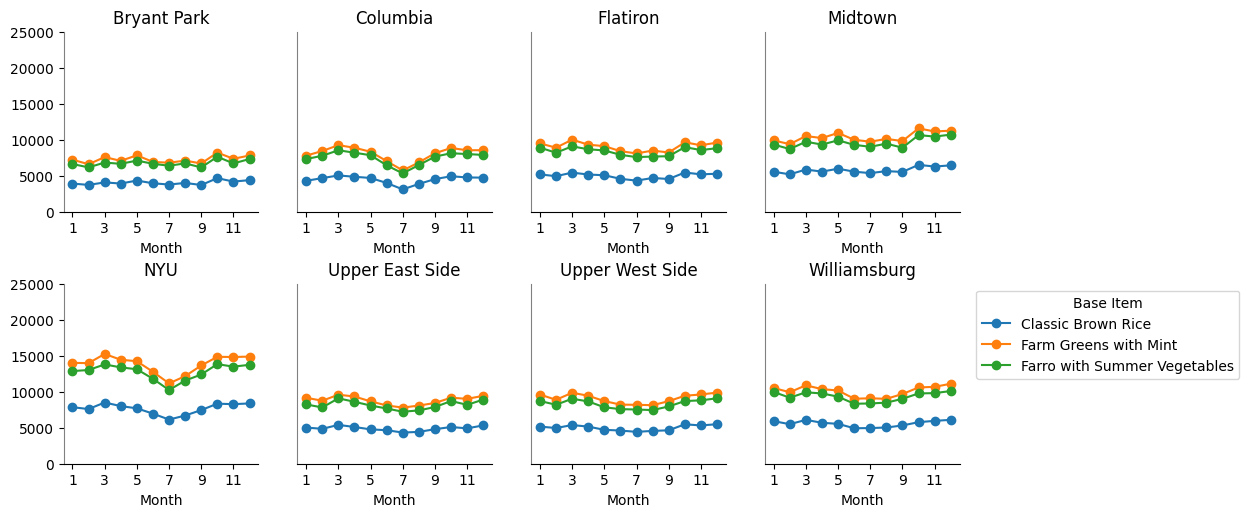

In [ ]:
# Plot by restaurant and base by month (Google, 2025)
title = 'Base Popularity by Restaurant and month'
fig = plt.figure()

# Graph visual set (OpenAI, 2025)
ax1 = fig.add_subplot(241, title="Bryant Park")
ax1.set_xlabel('Month')
ax1.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks(np.arange(1, 12, step=2))

ax2 = fig.add_subplot(242, title="Columbia")
ax2.set_xlabel('Month')
ax2.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax3 = fig.add_subplot(243, title="Flatiron")
ax3.set_xlabel('Month')
ax3.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax4 = fig.add_subplot(244, title="Midtown")
ax4.set_xlabel('Month')
ax4.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax5 = fig.add_subplot(245, title="NYU")
ax5.set_xlabel('Month')
ax5.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks(np.arange(1, 12, step=2))

ax6 = fig.add_subplot(246, title="Upper East Side")
ax6.set_xlabel('Month')
ax6.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax7 = fig.add_subplot(247, title="Upper West Side")
ax7.set_xlabel('Month')
ax7.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax8 = fig.add_subplot(248, title="Williamsburg")
ax8.set_xlabel('Month')
ax8.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

# Plot and add datalabels (OpenAI, 2025)
plt.subplots_adjust(left=0.1, right=1.5, top=1, bottom=0.1, hspace=0.4)

# Filter for Bryant Park orders
bryant_park_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Bryant Park']
columbias_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Columbia']
flatirons_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Flatiron']
midtowns_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Midtown']
nyus_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'NYU']
upper_east_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Upper East Side']
upper_west_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Upper West Side']
williamsburg_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Williamsburg']

# Pivot the table to have hours as index, items as columns, and order count as values
bryant_park_pivot = bryant_park_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
columbias_pivot = columbias_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
flatirons_pivot = flatirons_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
midtowns_pivot = midtowns_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
nyus_pivot = nyus_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
upper_east_pivot = upper_east_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
upper_west_pivot = upper_west_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
williamsburg_pivot = williamsburg_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)

# Plotting
for column in bryant_park_pivot.columns:
    ax1.plot(bryant_park_pivot.index, bryant_park_pivot[column], marker='o', linestyle='-', label=column)
for column in columbias_pivot.columns:
    ax2.plot(columbias_pivot.index, columbias_pivot[column], marker='o', linestyle='-', label=column)
for column in flatirons_pivot.columns:
    ax3.plot(flatirons_pivot.index, flatirons_pivot[column], marker='o', linestyle='-', label=column)
for column in midtowns_pivot.columns:
    ax4.plot(midtowns_pivot.index, midtowns_pivot[column], marker='o', linestyle='-', label=column)
for column in nyus_pivot.columns:
    ax5.plot(nyus_pivot.index, nyus_pivot[column], marker='o', linestyle='-', label=column)
for column in upper_east_pivot.columns:
    ax6.plot(upper_east_pivot.index, upper_east_pivot[column], marker='o', linestyle='-', label=column)
for column in upper_west_pivot.columns:
    ax7.plot(upper_west_pivot.index, upper_west_pivot[column], marker='o', linestyle='-', label=column)
for column in williamsburg_pivot.columns:
    ax8.plot(williamsburg_pivot.index, williamsburg_pivot[column], marker='o', linestyle='-', label=column)

plt.legend(title='Base Item', bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.savefig(title+'.png')
plt.show()

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

####3.4.2.3 By Hour

In [ ]:
# Group by restaurant and base in hour (Google, 2025)

df_orders_items_base = df_orders_items_analysis

df_orders_items_base['ORDER_HOUR'] = df_orders_items_base['DATETIME'].dt.hour

# Groupby hour
hourly_orders = df_orders_items_base.groupby(['RESTAURANT_NAME','BASE_NAME','BASE_ID', 'ORDER_HOUR']).size()
hourly_orders = hourly_orders.reset_index()
hourly_orders.columns = ['RESTAURANT_NAME','ITEM_NAME', 'ITEM_ID', 'ORDER_HOUR', 'ORDER_COUNT']

# Separate by restaurant
hourly_orders_B = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Bryant Park']
hourly_orders_C = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Columbia']
hourly_orders_F = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Flatiron']
hourly_orders_M = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Midtown']
hourly_orders_N = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'NYU']
hourly_orders_UE = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Upper East Side']
hourly_orders_UW = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Upper West Side']
hourly_orders_W = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Williamsburg']

hourly_orders

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME                     ITEM_NAME  ITEM_ID  ORDER_HOUR  \
0       Bryant Park            Classic Brown Rice      3.0          10   
1       Bryant Park            Classic Brown Rice      3.0          11   
2       Bryant Park            Classic Brown Rice      3.0          12   
3       Bryant Park            Classic Brown Rice      3.0          13   
4       Bryant Park            Classic Brown Rice      3.0          14   
..              ...                           ...      ...         ...   
341    Williamsburg  Farro with Summer Vegetables      2.0          19   
342    Williamsburg  Farro with Summer Vegetables      2.0          20   
343    Williamsburg  Farro with Summer Vegetables      2.0          21   
344    Williamsburg  Farro with Summer Vegetables      2.0          22   
345    Williamsburg  Farro with Summer Vegetables      2.0          23   

     ORDER_COUNT  
0           1202  
1           4728  
2           6704  
3           6649  
4           5722  
..           ...  
341         9566  
342         7242  
343         5593  
344         4289  
345           39  

[346 rows x 5 columns]

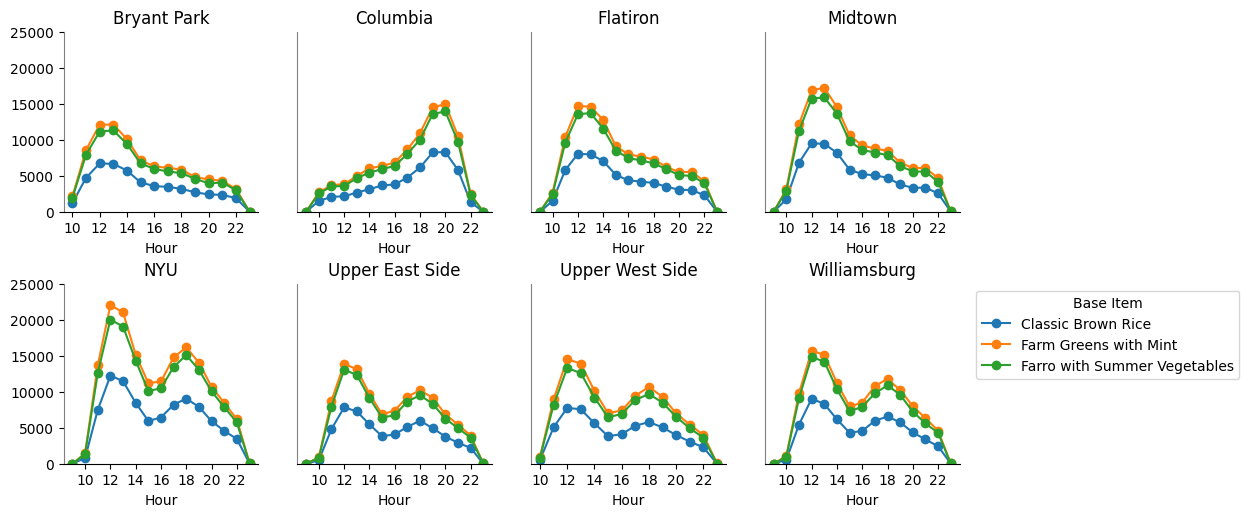

In [ ]:
# Plot by restaurant and base (Google, 2025)
title = 'Base Popularity by Restaurant and hour'
fig = plt.figure()

# Graph visual set (OpenAI, 2025)
ax1 = fig.add_subplot(241, title="Bryant Park")
ax1.set_xlabel('Hour')
ax1.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks(np.arange(10, 23, step=2))

ax2 = fig.add_subplot(242, title="Columbia")
ax2.set_xlabel('Hour')
ax2.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax3 = fig.add_subplot(243, title="Flatiron")
ax3.set_xlabel('Hour')
ax3.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax4 = fig.add_subplot(244, title="Midtown")
ax4.set_xlabel('Hour')
ax4.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax5 = fig.add_subplot(245, title="NYU")
ax5.set_xlabel('Hour')
ax5.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks(np.arange(10, 23, step=2))

ax6 = fig.add_subplot(246, title="Upper East Side")
ax6.set_xlabel('Hour')
ax6.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax7 = fig.add_subplot(247, title="Upper West Side")
ax7.set_xlabel('Hour')
ax7.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax8 = fig.add_subplot(248, title="Williamsburg")
ax8.set_xlabel('Hour')
ax8.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

# Plot and add datalabels (OpenAI, 2025)
plt.subplots_adjust(left=0.1, right=1.5, top=1, bottom=0.1, hspace=0.4)

# Filter for Bryant Park orders
bryant_park_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Bryant Park']
columbias_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Columbia']
flatirons_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Flatiron']
midtowns_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Midtown']
nyus_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'NYU']
upper_east_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Upper East Side']
upper_west_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Upper West Side']
williamsburg_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Williamsburg']

# Pivot the table to have hours as index, items as columns, and order count as values
bryant_park_pivot = bryant_park_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
columbias_pivot = columbias_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
flatirons_pivot = flatirons_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
midtowns_pivot = midtowns_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
nyus_pivot = nyus_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
upper_east_pivot = upper_east_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
upper_west_pivot = upper_west_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
williamsburg_pivot = williamsburg_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)

# Plotting
for column in bryant_park_pivot.columns:
    ax1.plot(bryant_park_pivot.index, bryant_park_pivot[column], marker='o', linestyle='-', label=column)
for column in columbias_pivot.columns:
    ax2.plot(columbias_pivot.index, columbias_pivot[column], marker='o', linestyle='-', label=column)
for column in flatirons_pivot.columns:
    ax3.plot(flatirons_pivot.index, flatirons_pivot[column], marker='o', linestyle='-', label=column)
for column in midtowns_pivot.columns:
    ax4.plot(midtowns_pivot.index, midtowns_pivot[column], marker='o', linestyle='-', label=column)
for column in nyus_pivot.columns:
    ax5.plot(nyus_pivot.index, nyus_pivot[column], marker='o', linestyle='-', label=column)
for column in upper_east_pivot.columns:
    ax6.plot(upper_east_pivot.index, upper_east_pivot[column], marker='o', linestyle='-', label=column)
for column in upper_west_pivot.columns:
    ax7.plot(upper_west_pivot.index, upper_west_pivot[column], marker='o', linestyle='-', label=column)
for column in williamsburg_pivot.columns:
    ax8.plot(williamsburg_pivot.index, williamsburg_pivot[column], marker='o', linestyle='-', label=column)

plt.legend(title='Base Item', bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.savefig(title+'.png')
plt.show()

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

### 3.4.3 Sides

#### 3.4.3.1_All time

In [ ]:
# Group by restaurant and sides (Google, 2025)

df_orders_items_analysis = df_orders_7

# Add ID
sides_id = {'Roasted Sweet Potatoes':1, 'Snap Peas':2, 'Cauliflower with Garlic and Parmesan':3, 'Charred Broccoli with Lemon':4, 'Cashew Kale Caesar':5, 'Jasper Hill Mac & Cheese':6, 'Blistered Shishitos':7, 'Green Goddess Beans with Sesame':8}
df_orders_items_analysis['SIDE_1_ID'] = df_orders_items_analysis['SIDE_1_NAME'].map(sides_id)
df_orders_items_analysis['SIDE_2_ID'] = df_orders_items_analysis['SIDE_2_NAME'].map(sides_id)

# Group by restaurant and side_1
df_restaurant_1 = df_orders_items_analysis.groupby(['RESTAURANT_NAME','SIDE_1_NAME','SIDE_1_ID']).size()
df_restaurant_1 = df_restaurant_1.reset_index()
df_restaurant_1.columns = ['RESTAURANT_NAME','ITEM_NAME', 'ITEM_ID', 'COUNT']
df_restaurant_1 = df_restaurant_1.sort_values(by=['RESTAURANT_NAME','ITEM_ID'], ascending=False)

# Group by restaurant and side_2
df_restaurant_2 = df_orders_items_Main.groupby(['RESTAURANT_NAME','SIDE_2_NAME','SIDE_2_ID']).size()
df_restaurant_2 = df_restaurant_2.reset_index()
df_restaurant_2.columns = ['RESTAURANT_NAME','ITEM_NAME', 'ITEM_ID', 'COUNT']
df_restaurant_2 = df_restaurant_2.sort_values(by=['RESTAURANT_NAME','ITEM_ID'], ascending=False)

# Marge side_1 and side_2
df_restaurant = df_restaurant_1
df_restaurant['COUNT'] = df_restaurant['COUNT'] + df_restaurant_2['COUNT']

# Calculate total orders per restaurant
total_orders_per_restaurant = df_restaurant.groupby('RESTAURANT_NAME')['COUNT'].sum().reset_index(name='TOTAL_RESTAURANT_ORDERS')
total_orders_per_restaurant.columns = ['RESTAURANT_NAME', 'TOTAL_RESTAURANT_ORDERS']

# Merge the total orders back to the main_restaurant dataframe
df_restaurant = pd.merge(df_restaurant, total_orders_per_restaurant, on='RESTAURANT_NAME')

# Calculate the percentage
df_restaurant['PERCENTAGE'] = (df_restaurant['COUNT'] / df_restaurant['TOTAL_RESTAURANT_ORDERS']) * 100

# Separate by restaurant
df_restaurant_B = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Bryant Park']
df_restaurant_C = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Columbia']
df_restaurant_F = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Flatiron']
df_restaurant_M = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Midtown']
df_restaurant_N = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'NYU']
df_restaurant_UE = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Upper East Side']
df_restaurant_UW = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Upper West Side']
df_restaurant_W = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Williamsburg']

df_restaurant.head(10)

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME                             ITEM_NAME  ITEM_ID   COUNT  \
0     Williamsburg       Green Goddess Beans with Sesame      8.0   40641   
1     Williamsburg                   Blistered Shishitos      7.0   46540   
2     Williamsburg              Jasper Hill Mac & Cheese      6.0   53131   
3     Williamsburg                    Cashew Kale Caesar      5.0   54844   
4     Williamsburg           Charred Broccoli with Lemon      4.0   60771   
5     Williamsburg  Cauliflower with Garlic and Parmesan      3.0   82604   
6     Williamsburg                             Snap Peas      2.0  130071   
7     Williamsburg                Roasted Sweet Potatoes      1.0  131042   
8  Upper West Side       Green Goddess Beans with Sesame      8.0   36357   
9  Upper West Side                   Blistered Shishitos      7.0   41646   

   TOTAL_RESTAURANT_ORDERS  PERCENTAGE  
0                   599644    6.777521  
1                   599644    7.761272  
2                   599644    8.860424  
3                   599644    9.146093  
4                   599644   10.134513  
5                   599644   13.775507  
6                   599644   21.691370  
7                   599644   21.853300  
8                   536046    6.782440  
9                   536046    7.769109

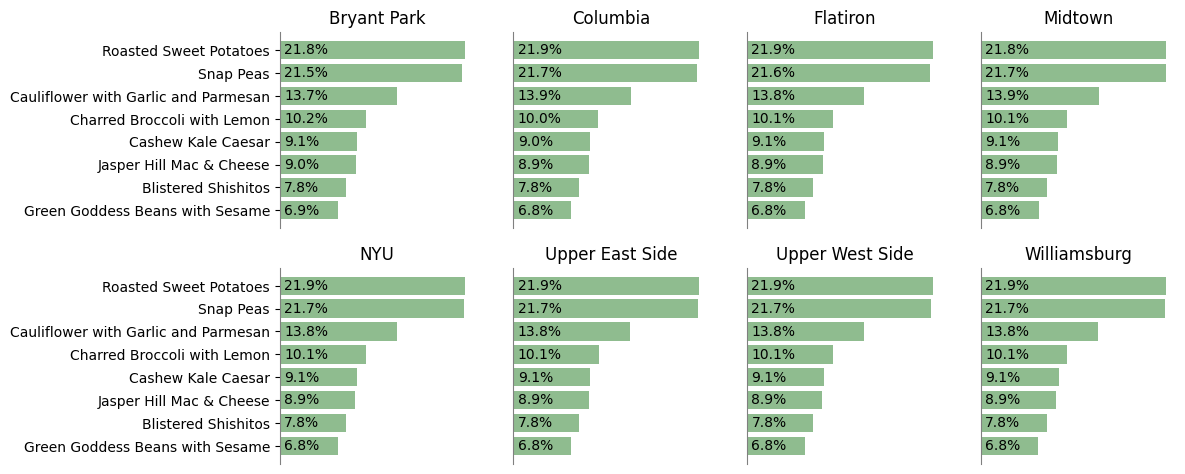

In [ ]:
# Plot by restaurant and sides (Google, 2025)
title = 'Sides Popularity by Restaurant'
fig = plt.figure()

# Graph visual set (OpenAI, 2025)
ax1 = fig.add_subplot(241, title="Bryant Park")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])

ax2 = fig.add_subplot(242, title="Columbia")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax3 = fig.add_subplot(243, title="Flatiron")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax4 = fig.add_subplot(244, title="Midtown")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax5 = fig.add_subplot(245, title="NYU")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])

ax6 = fig.add_subplot(246, title="Upper East Side")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax7 = fig.add_subplot(247, title="Upper West Side")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax8 = fig.add_subplot(248, title="Williamsburg")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

# Format data labels (OpenAI, 2025)
df_ax1_label = (round(df_restaurant_B['PERCENTAGE'], 1)).astype(str) + '%'
df_ax2_label = (round(df_restaurant_C['PERCENTAGE'], 1)).astype(str) + '%'
df_ax3_label = (round(df_restaurant_F['PERCENTAGE'], 1)).astype(str) + '%'
df_ax4_label = (round(df_restaurant_M['PERCENTAGE'], 1)).astype(str) + '%'
df_ax5_label = (round(df_restaurant_N['PERCENTAGE'], 1)).astype(str) + '%'
df_ax6_label = (round(df_restaurant_UE['PERCENTAGE'], 1)).astype(str) + '%'
df_ax7_label = (round(df_restaurant_UW['PERCENTAGE'], 1)).astype(str) + '%'
df_ax8_label = (round(df_restaurant_W['PERCENTAGE'], 1)).astype(str) + '%'

# Plot and add datalabels (OpenAI, 2025)
plt.subplots_adjust(left=0.1, right=1.5, top=1, bottom=0.1)

ax1.barh(df_restaurant_B['ITEM_NAME'], df_restaurant_B['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_B['PERCENTAGE']):
    ax1.text(0.5, i, df_ax1_label.values[i], va='center', color='black')

ax2.barh(df_restaurant_C['ITEM_NAME'], df_restaurant_C['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_C['PERCENTAGE']):
    ax2.text(0.5, i, df_ax2_label.values[i], va='center', color='black')

ax3.barh(df_restaurant_F['ITEM_NAME'], df_restaurant_F['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_F['PERCENTAGE']):
    ax3.text(0.5, i, df_ax3_label.values[i], va='center', color='black')

ax4.barh(df_restaurant_M['ITEM_NAME'], df_restaurant_M['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_M['PERCENTAGE']):
    ax4.text(0.5, i, df_ax4_label.values[i], va='center', color='black')

ax5.barh(df_restaurant_N['ITEM_NAME'], df_restaurant_N['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_N['PERCENTAGE']):
    ax5.text(0.5, i, df_ax5_label.values[i], va='center', color='black')

ax6.barh(df_restaurant_UE['ITEM_NAME'], df_restaurant_UE['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_UE['PERCENTAGE']):
    ax6.text(0.5, i, df_ax6_label.values[i], va='center', color='black')

ax7.barh(df_restaurant_UW['ITEM_NAME'], df_restaurant_UW['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_UW['PERCENTAGE']):
    ax7.text(0.5, i, df_ax7_label.values[i], va='center', color='black')

ax8.barh(df_restaurant_W['ITEM_NAME'], df_restaurant_W['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_W['PERCENTAGE']):
    ax8.text(0.5, i, df_ax8_label.values[i], va='center', color='black')

#plt.savefig(title+'.png')
plt.show()

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

#### 3.4.3.2 By Month

In [ ]:
# Group by restaurant and sides in month (Google, 2025)

df_orders_items_sides = df_orders_items_analysis

df_orders_items_sides['ORDER_MONTH'] = df_orders_items_sides['DATETIME'].dt.month

# Group by restaurant and side_1
monthly_orders_1 = df_orders_items_sides.groupby(['RESTAURANT_NAME','SIDE_1_NAME','SIDE_1_ID', 'ORDER_MONTH']).size()
monthly_orders_1 = monthly_orders_1.reset_index()
monthly_orders_1.columns = ['RESTAURANT_NAME','ITEM_NAME', 'ITEM_ID', 'ORDER_MONTH', 'ORDER_COUNT']
monthly_orders_1 = monthly_orders_1.sort_values(by=['RESTAURANT_NAME','ITEM_ID'], ascending=False)

# Group by restaurant and side_2
monthly_orders_2 = df_orders_items_sides.groupby(['RESTAURANT_NAME','SIDE_2_NAME','SIDE_2_ID', 'ORDER_MONTH']).size()
monthly_orders_2 = monthly_orders_2.reset_index()
monthly_orders_2.columns = ['RESTAURANT_NAME','ITEM_NAME', 'ITEM_ID', 'ORDER_MONTH', 'ORDER_COUNT']
monthly_orders_2 = monthly_orders_2.sort_values(by=['RESTAURANT_NAME','ITEM_ID'], ascending=False)

# Marge side_1 and side_2
monthly_orders = monthly_orders_1
monthly_orders['ORDER_COUNT'] = monthly_orders['ORDER_COUNT'] + monthly_orders_2['ORDER_COUNT']

# Separate by restaurant
monthly_orders_B = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Bryant Park']
monthly_orders_C = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Columbia']
monthly_orders_F = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Flatiron']
monthly_orders_M = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Midtown']
monthly_orders_N = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'NYU']
monthly_orders_UE = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Upper East Side']
monthly_orders_UW = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Upper West Side']
monthly_orders_W = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Williamsburg']

monthly_orders.head(15)

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME                        ITEM_NAME  ITEM_ID  ORDER_MONTH  \
720    Williamsburg  Green Goddess Beans with Sesame      8.0            1   
721    Williamsburg  Green Goddess Beans with Sesame      8.0            2   
722    Williamsburg  Green Goddess Beans with Sesame      8.0            3   
723    Williamsburg  Green Goddess Beans with Sesame      8.0            4   
724    Williamsburg  Green Goddess Beans with Sesame      8.0            5   
725    Williamsburg  Green Goddess Beans with Sesame      8.0            6   
726    Williamsburg  Green Goddess Beans with Sesame      8.0            7   
727    Williamsburg  Green Goddess Beans with Sesame      8.0            8   
728    Williamsburg  Green Goddess Beans with Sesame      8.0            9   
729    Williamsburg  Green Goddess Beans with Sesame      8.0           10   
730    Williamsburg  Green Goddess Beans with Sesame      8.0           11   
731    Williamsburg  Green Goddess Beans with Sesame      8.0           12   
672    Williamsburg              Blistered Shishitos      7.0            1   
673    Williamsburg              Blistered Shishitos      7.0            2   
674    Williamsburg              Blistered Shishitos      7.0            3   

     ORDER_COUNT  
720         3577  
721         3380  
722         3629  
723         3489  
724         3360  
725         2964  
726         2959  
727         3010  
728         3221  
729         3651  
730         3638  
731         3763  
672         4137  
673         3878  
674         4140

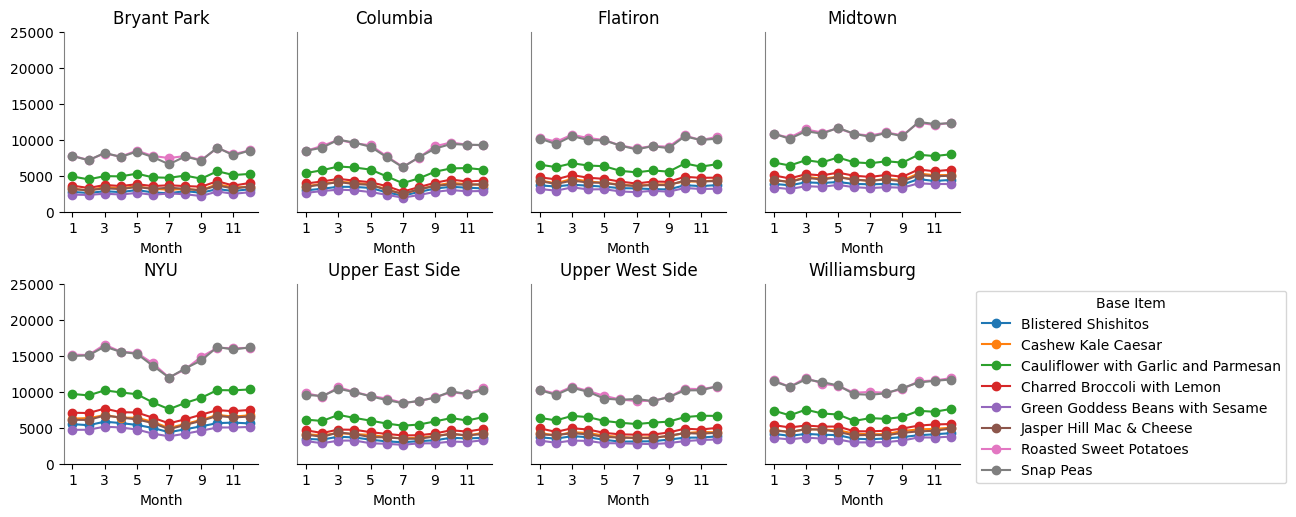

In [ ]:
# Plot by restaurant and sides by month (Google, 2025)
title = 'Sides Popularity by Restaurant and month'
fig = plt.figure()

# Graph visual set (OpenAI, 2025)
ax1 = fig.add_subplot(241, title="Bryant Park")
ax1.set_xlabel('Month')
ax1.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks(np.arange(1, 12, step=2))

ax2 = fig.add_subplot(242, title="Columbia")
ax2.set_xlabel('Month')
ax2.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax3 = fig.add_subplot(243, title="Flatiron")
ax3.set_xlabel('Month')
ax3.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax4 = fig.add_subplot(244, title="Midtown")
ax4.set_xlabel('Month')
ax4.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax5 = fig.add_subplot(245, title="NYU")
ax5.set_xlabel('Month')
ax5.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks(np.arange(1, 12, step=2))

ax6 = fig.add_subplot(246, title="Upper East Side")
ax6.set_xlabel('Month')
ax6.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax7 = fig.add_subplot(247, title="Upper West Side")
ax7.set_xlabel('Month')
ax7.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

ax8 = fig.add_subplot(248, title="Williamsburg")
ax8.set_xlabel('Month')
ax8.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(1, 12, step=2))

# Plot and add datalabels (OpenAI, 2025)
plt.subplots_adjust(left=0.1, right=1.5, top=1, bottom=0.1, hspace=0.4)

# Filter for Bryant Park orders
bryant_park_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Bryant Park']
columbias_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Columbia']
flatirons_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Flatiron']
midtowns_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Midtown']
nyus_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'NYU']
upper_east_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Upper East Side']
upper_west_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Upper West Side']
williamsburg_orders = monthly_orders[monthly_orders['RESTAURANT_NAME'] == 'Williamsburg']

# Pivot the table to have hours as index, items as columns, and order count as values
bryant_park_pivot = bryant_park_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
columbias_pivot = columbias_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
flatirons_pivot = flatirons_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
midtowns_pivot = midtowns_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
nyus_pivot = nyus_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
upper_east_pivot = upper_east_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
upper_west_pivot = upper_west_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
williamsburg_pivot = williamsburg_orders.pivot(index='ORDER_MONTH', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)

# Plotting
for column in bryant_park_pivot.columns:
    ax1.plot(bryant_park_pivot.index, bryant_park_pivot[column], marker='o', linestyle='-', label=column)
for column in columbias_pivot.columns:
    ax2.plot(columbias_pivot.index, columbias_pivot[column], marker='o', linestyle='-', label=column)
for column in flatirons_pivot.columns:
    ax3.plot(flatirons_pivot.index, flatirons_pivot[column], marker='o', linestyle='-', label=column)
for column in midtowns_pivot.columns:
    ax4.plot(midtowns_pivot.index, midtowns_pivot[column], marker='o', linestyle='-', label=column)
for column in nyus_pivot.columns:
    ax5.plot(nyus_pivot.index, nyus_pivot[column], marker='o', linestyle='-', label=column)
for column in upper_east_pivot.columns:
    ax6.plot(upper_east_pivot.index, upper_east_pivot[column], marker='o', linestyle='-', label=column)
for column in upper_west_pivot.columns:
    ax7.plot(upper_west_pivot.index, upper_west_pivot[column], marker='o', linestyle='-', label=column)
for column in williamsburg_pivot.columns:
    ax8.plot(williamsburg_pivot.index, williamsburg_pivot[column], marker='o', linestyle='-', label=column)

plt.legend(title='Base Item', bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.savefig(title+'.png')
plt.show()

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

#### 3.4.3.3 By Hour

In [ ]:
# Group by restaurant and sides in hour (Google, 2025)

df_orders_items_sides = df_orders_items_analysis

df_orders_items_sides['ORDER_HOUR'] = df_orders_items_sides['DATETIME'].dt.hour

# Group by restaurant and side_1
hourly_orders_1 = df_orders_items_sides.groupby(['RESTAURANT_NAME','SIDE_1_NAME','SIDE_1_ID', 'ORDER_HOUR']).size()
hourly_orders_1 = hourly_orders_1.reset_index()
hourly_orders_1.columns = ['RESTAURANT_NAME','ITEM_NAME', 'ITEM_ID', 'ORDER_HOUR', 'ORDER_COUNT']
hourly_orders_1 = hourly_orders_1.sort_values(by=['RESTAURANT_NAME','ITEM_ID'], ascending=False)

# Group by restaurant and side_2
hourly_orders_2 = df_orders_items_sides.groupby(['RESTAURANT_NAME','SIDE_2_NAME','SIDE_2_ID', 'ORDER_HOUR']).size()
hourly_orders_2 = hourly_orders_2.reset_index()
hourly_orders_2.columns = ['RESTAURANT_NAME','ITEM_NAME', 'ITEM_ID', 'ORDER_HOUR', 'ORDER_COUNT']
hourly_orders_2 = hourly_orders_2.sort_values(by=['RESTAURANT_NAME','ITEM_ID'], ascending=False)

# Marge side_1 and side_2
hourly_orders = hourly_orders_1
hourly_orders['ORDER_COUNT'] = hourly_orders['ORDER_COUNT'] + hourly_orders_2['ORDER_COUNT']

# Separate by restaurant
hourly_orders_B = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Bryant Park']
hourly_orders_C = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Columbia']
hourly_orders_F = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Flatiron']
hourly_orders_M = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Midtown']
hourly_orders_N = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'NYU']
hourly_orders_UE = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Upper East Side']
hourly_orders_UW = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Upper West Side']
hourly_orders_W = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Williamsburg']

hourly_orders.head(15)

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME                        ITEM_NAME  ITEM_ID  ORDER_HOUR  \
848    Williamsburg  Green Goddess Beans with Sesame      8.0          10   
849    Williamsburg  Green Goddess Beans with Sesame      8.0          11   
850    Williamsburg  Green Goddess Beans with Sesame      8.0          12   
851    Williamsburg  Green Goddess Beans with Sesame      8.0          13   
852    Williamsburg  Green Goddess Beans with Sesame      8.0          14   
853    Williamsburg  Green Goddess Beans with Sesame      8.0          15   
854    Williamsburg  Green Goddess Beans with Sesame      8.0          16   
855    Williamsburg  Green Goddess Beans with Sesame      8.0          17   
856    Williamsburg  Green Goddess Beans with Sesame      8.0          18   
857    Williamsburg  Green Goddess Beans with Sesame      8.0          19   
858    Williamsburg  Green Goddess Beans with Sesame      8.0          20   
859    Williamsburg  Green Goddess Beans with Sesame      8.0          21   
860    Williamsburg  Green Goddess Beans with Sesame      8.0          22   
861    Williamsburg  Green Goddess Beans with Sesame      8.0          23   
792    Williamsburg              Blistered Shishitos      7.0          10   

     ORDER_COUNT  
848       1821.0  
849       4339.0  
850       5107.0  
851       4506.0  
852       3190.0  
853       2791.0  
854       3315.0  
855       3688.0  
856       3705.0  
857       3023.0  
858       2312.0  
859       1787.0  
860        873.0  
861         10.0  
792       3302.0

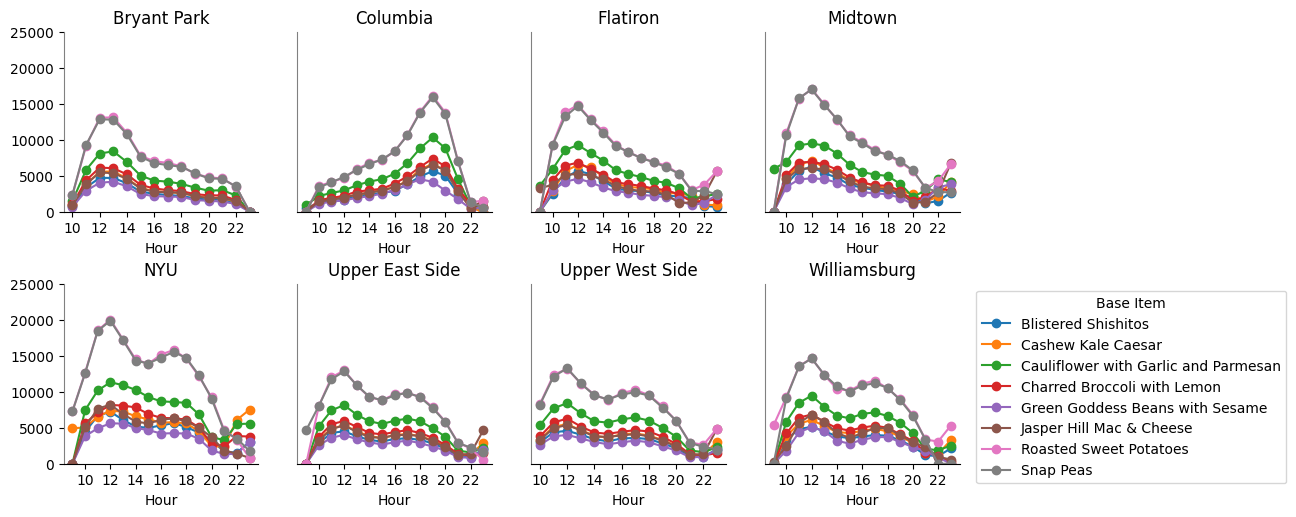

In [ ]:
# Plot by restaurant and sides by hour (Google, 2025)
title = 'Base Popularity by Restaurant and hour'
fig = plt.figure()

# Graph visual set (OpenAI, 2025)
ax1 = fig.add_subplot(241, title="Bryant Park")
ax1.set_xlabel('Hour')
ax1.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks(np.arange(10, 23, step=2))

ax2 = fig.add_subplot(242, title="Columbia")
ax2.set_xlabel('Hour')
ax2.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax3 = fig.add_subplot(243, title="Flatiron")
ax3.set_xlabel('Hour')
ax3.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax4 = fig.add_subplot(244, title="Midtown")
ax4.set_xlabel('Hour')
ax4.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax5 = fig.add_subplot(245, title="NYU")
ax5.set_xlabel('Hour')
ax5.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks(np.arange(10, 23, step=2))

ax6 = fig.add_subplot(246, title="Upper East Side")
ax6.set_xlabel('Hour')
ax6.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax7 = fig.add_subplot(247, title="Upper West Side")
ax7.set_xlabel('Hour')
ax7.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

ax8 = fig.add_subplot(248, title="Williamsburg")
ax8.set_xlabel('Hour')
ax8.set_ylim(0,25000)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(True)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.yticks([])
plt.xticks(np.arange(10, 23, step=2))

# Plot and add datalabels (OpenAI, 2025)
plt.subplots_adjust(left=0.1, right=1.5, top=1, bottom=0.1, hspace=0.4)

# Filter for Bryant Park orders
bryant_park_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Bryant Park']
columbias_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Columbia']
flatirons_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Flatiron']
midtowns_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Midtown']
nyus_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'NYU']
upper_east_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Upper East Side']
upper_west_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Upper West Side']
williamsburg_orders = hourly_orders[hourly_orders['RESTAURANT_NAME'] == 'Williamsburg']

# Pivot the table to have hours as index, items as columns, and order count as values
bryant_park_pivot = bryant_park_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
columbias_pivot = columbias_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
flatirons_pivot = flatirons_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
midtowns_pivot = midtowns_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
nyus_pivot = nyus_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
upper_east_pivot = upper_east_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
upper_west_pivot = upper_west_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)
williamsburg_pivot = williamsburg_orders.pivot(index='ORDER_HOUR', columns='ITEM_NAME', values='ORDER_COUNT').fillna(0)

# Plotting
for column in bryant_park_pivot.columns:
    ax1.plot(bryant_park_pivot.index, bryant_park_pivot[column], marker='o', linestyle='-', label=column)
for column in columbias_pivot.columns:
    ax2.plot(columbias_pivot.index, columbias_pivot[column], marker='o', linestyle='-', label=column)
for column in flatirons_pivot.columns:
    ax3.plot(flatirons_pivot.index, flatirons_pivot[column], marker='o', linestyle='-', label=column)
for column in midtowns_pivot.columns:
    ax4.plot(midtowns_pivot.index, midtowns_pivot[column], marker='o', linestyle='-', label=column)
for column in nyus_pivot.columns:
    ax5.plot(nyus_pivot.index, nyus_pivot[column], marker='o', linestyle='-', label=column)
for column in upper_east_pivot.columns:
    ax6.plot(upper_east_pivot.index, upper_east_pivot[column], marker='o', linestyle='-', label=column)
for column in upper_west_pivot.columns:
    ax7.plot(upper_west_pivot.index, upper_west_pivot[column], marker='o', linestyle='-', label=column)
for column in williamsburg_pivot.columns:
    ax8.plot(williamsburg_pivot.index, williamsburg_pivot[column], marker='o', linestyle='-', label=column)

plt.legend(title='Base Item', bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.savefig(title+'.png')
plt.show()

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

### 3.4.4 Drinks

#### 3.4.4.1 All time

In [ ]:
# Group by restaurant and with / without drinks (Google, 2025)

df_orders_items_analysis = df_orders_7

df_orders_items_analysis['HAS_DRINK'] = df_orders_items_analysis['DRINKS'] > 0
df_restaurant = df_orders_items_analysis.groupby('RESTAURANT_NAME').agg(
    COUNT_WITH_DRINK=('HAS_DRINK', 'sum'),  # counts True values = drink orders
    TOTAL_RESTAURANT_ORDERS=('ORDER_ID', 'count') # Changed 'COUNT' to 'count'
).reset_index()

# Calculate the percentage
df_restaurant['DRINKS'] = 'With Drinks'
df_restaurant['PERCENTAGE'] = (df_restaurant['COUNT_WITH_DRINK'] / df_restaurant['TOTAL_RESTAURANT_ORDERS']) * 100 # Use COUNT_WITH_DRINK

# Add 'Without Drinks' row
df_restaurant_without_drinks = df_restaurant.copy()
df_restaurant_without_drinks['COUNT_WITH_DRINK'] = df_restaurant_without_drinks['TOTAL_RESTAURANT_ORDERS'] - df_restaurant_without_drinks['COUNT_WITH_DRINK'] # Use COUNT_WITH_DRINK
df_restaurant_without_drinks['DRINKS'] = 'Without Drinks'
df_restaurant_without_drinks['PERCENTAGE'] = 100 - df_restaurant_without_drinks['PERCENTAGE']

# Combine the two dataframes
df_restaurant = pd.concat([df_restaurant, df_restaurant_without_drinks])
df_restaurant = df_restaurant.sort_values(by=['RESTAURANT_NAME', 'DRINKS'], ascending=False)

#df_restaurant['Without Drinks'] = 100 - df_restaurant['With Drinks']

# Separate by restaurant
df_restaurant_B = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Bryant Park']
df_restaurant_C = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Columbia']
df_restaurant_F = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Flatiron']
df_restaurant_M = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Midtown']
df_restaurant_N = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'NYU']
df_restaurant_UE = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Upper East Side']
df_restaurant_UW = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Upper West Side']
df_restaurant_W = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Williamsburg']

df_restaurant.head()

RESTAURANT_NAME  COUNT_WITH_DRINK  TOTAL_RESTAURANT_ORDERS          DRINKS  \
7     Williamsburg            289952                   314674  Without Drinks   
7     Williamsburg             24722                   314674     With Drinks   
6  Upper West Side            259025                   281186  Without Drinks   
6  Upper West Side             22161                   281186     With Drinks   
5  Upper East Side            248665                   275001  Without Drinks   

   PERCENTAGE  
7   92.143615  
7    7.856385  
6   92.118740  
6    7.881260  
5   90.423308

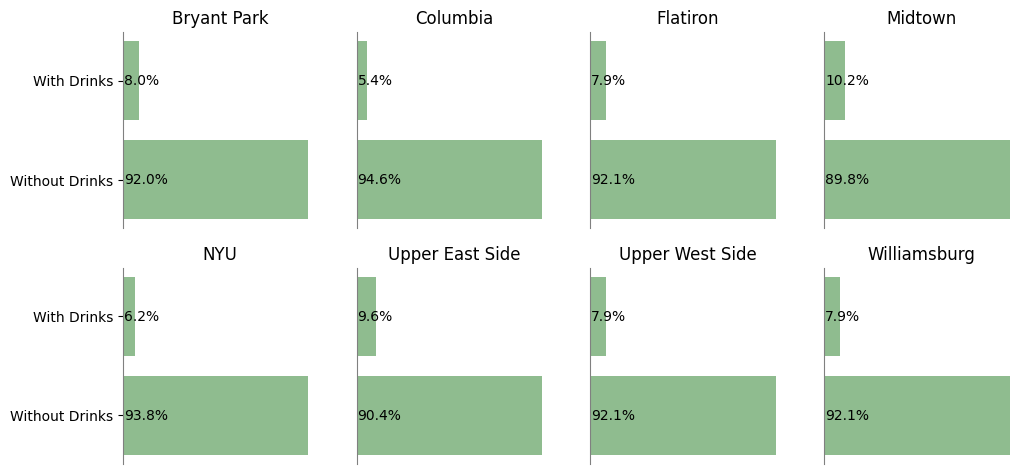

In [ ]:
# Plot by restaurant and with / without drinks (Google, 2025)
title = 'Orders With and Without Drinks by Restaurant'
fig = plt.figure()

# Graph visual set (OpenAI, 2025)
ax1 = fig.add_subplot(241, title="Bryant Park")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])

ax2 = fig.add_subplot(242, title="Columbia")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax3 = fig.add_subplot(243, title="Flatiron")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax4 = fig.add_subplot(244, title="Midtown")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax5 = fig.add_subplot(245, title="NYU")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])

ax6 = fig.add_subplot(246, title="Upper East Side")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax7 = fig.add_subplot(247, title="Upper West Side")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax8 = fig.add_subplot(248, title="Williamsburg")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

# Format data labels (OpenAI, 2025)
df_ax1_label = (round(df_restaurant_B['PERCENTAGE'], 1)).astype(str) + '%'
df_ax2_label = (round(df_restaurant_C['PERCENTAGE'], 1)).astype(str) + '%'
df_ax3_label = (round(df_restaurant_F['PERCENTAGE'], 1)).astype(str) + '%'
df_ax4_label = (round(df_restaurant_M['PERCENTAGE'], 1)).astype(str) + '%'
df_ax5_label = (round(df_restaurant_N['PERCENTAGE'], 1)).astype(str) + '%'
df_ax6_label = (round(df_restaurant_UE['PERCENTAGE'], 1)).astype(str) + '%'
df_ax7_label = (round(df_restaurant_UW['PERCENTAGE'], 1)).astype(str) + '%'
df_ax8_label = (round(df_restaurant_W['PERCENTAGE'], 1)).astype(str) + '%'

# Plot and add datalabels (OpenAI, 2025)
plt.subplots_adjust(left=0.1, right=1.5, top=1, bottom=0.1)

ax1.barh(df_restaurant_B['DRINKS'], df_restaurant_B['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_B['PERCENTAGE']):
    ax1.text(0.5, i, df_ax1_label.values[i], va='center', color='black')

ax2.barh(df_restaurant_C['DRINKS'], df_restaurant_C['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_C['PERCENTAGE']):
    ax2.text(0.5, i, df_ax2_label.values[i], va='center', color='black')

ax3.barh(df_restaurant_F['DRINKS'], df_restaurant_F['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_F['PERCENTAGE']):
    ax3.text(0.5, i, df_ax3_label.values[i], va='center', color='black')

ax4.barh(df_restaurant_M['DRINKS'], df_restaurant_M['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_M['PERCENTAGE']):
    ax4.text(0.5, i, df_ax4_label.values[i], va='center', color='black')

ax5.barh(df_restaurant_N['DRINKS'], df_restaurant_N['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_N['PERCENTAGE']):
    ax5.text(0.5, i, df_ax5_label.values[i], va='center', color='black')

ax6.barh(df_restaurant_UE['DRINKS'], df_restaurant_UE['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_UE['PERCENTAGE']):
    ax6.text(0.5, i, df_ax6_label.values[i], va='center', color='black')

ax7.barh(df_restaurant_UW['DRINKS'], df_restaurant_UW['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_UW['PERCENTAGE']):
    ax7.text(0.5, i, df_ax7_label.values[i], va='center', color='black')

ax8.barh(df_restaurant_W['DRINKS'], df_restaurant_W['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_W['PERCENTAGE']):
    ax8.text(0.5, i, df_ax8_label.values[i], va='center', color='black')

#plt.savefig(title+'.png')
plt.show()

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

#### 3.4.4.2 By Month

In [ ]:
# Group by restaurant and drink in month (Google, 2025)

df_orders_items_drinks = df_orders_items_analysis

df_orders_items_drinks['ORDER_MONTH'] = df_orders_items_drinks['DATETIME'].dt.month

df_orders_items_drinks['HAS_DRINK'] = df_orders_items_drinks['DRINKS'] > 0
# Pass the grouping keys as a list to groupby()
monthly_orders = df_orders_items_drinks.groupby(['RESTAURANT_NAME', 'ORDER_MONTH']).agg(
    COUNT_WITH_DRINK=('HAS_DRINK', 'sum'),  # counts True values = drink orders
    TOTAL_RESTAURANT_ORDERS=('ORDER_ID', 'count') # Changed 'COUNT' to 'count'
).reset_index()

monthly_orders.head(15)

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME  ORDER_MONTH  COUNT_WITH_DRINK  TOTAL_RESTAURANT_ORDERS
0      Bryant Park            1              1147                    18607
1      Bryant Park            2              1102                    17289
2      Bryant Park            3              1169                    19368
3      Bryant Park            4              1210                    18474
4      Bryant Park            5              1892                    20234
5      Bryant Park            6              1827                    18413
6      Bryant Park            7              1948                    17836
7      Bryant Park            8              2027                    18734
8      Bryant Park            9              1677                    17381
9      Bryant Park           10              1728                    21548
10     Bryant Park           11              1279                    19130
11     Bryant Park           12              1216                    20431
12        Columbia            1               879                    20296
13        Columbia            2               938                    21842
14        Columbia            3              1029                    23914

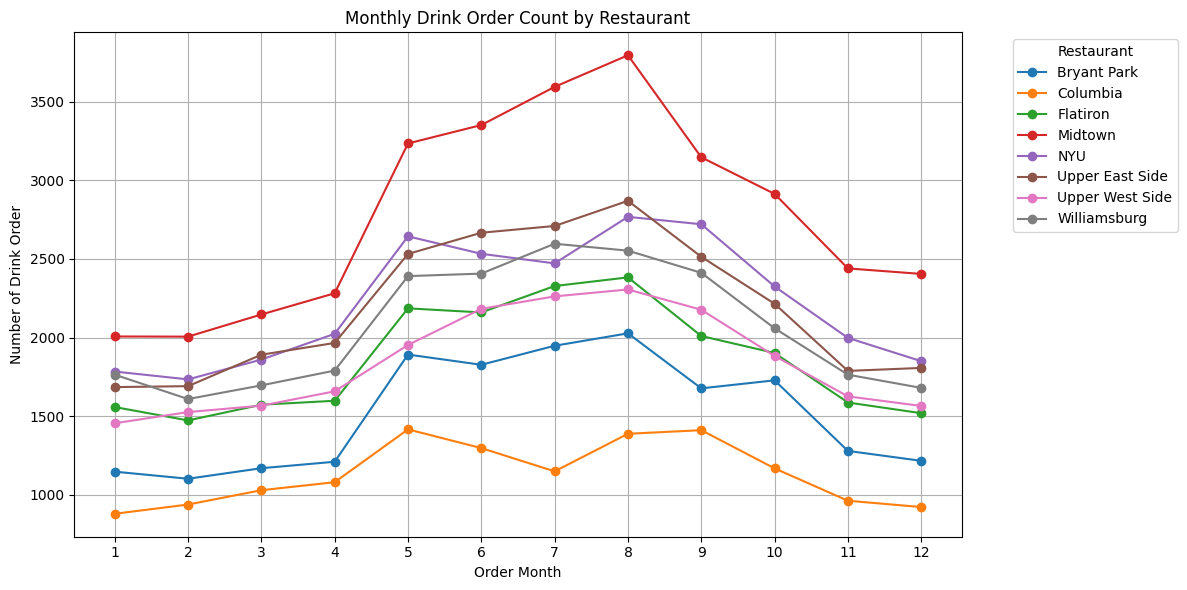

In [ ]:
# Set the figure size (width, height) in inches
df_pivot = monthly_orders.pivot(index='ORDER_MONTH', columns='RESTAURANT_NAME', values='COUNT_WITH_DRINK')
fig, ax = plt.subplots(figsize=(12, 6))  # You can adjust 12 and 6 as needed

# Plot the pivot table on the axes
df_pivot.plot(marker='o', ax=ax)

# Set titles and labels
ax.set_title('Monthly Drink Order Count by Restaurant')
ax.set_xlabel('Order Month')
ax.set_ylabel('Number of Drink Order')
ax.set_xticks(range(1, 13))  # Ensure x-axis shows months 1 to 12

# Legend positioning
ax.legend(title='Restaurant', bbox_to_anchor=(1.05, 1), loc='upper left')

# Layout and grid
plt.tight_layout()
ax.grid(True)

# Show the plot
plt.show()

#### 3.4.4.3 By Hour

In [ ]:
# Group by restaurant and drink in hour (Google, 2025)

df_orders_items_drinks = df_orders_items_analysis

# The user seems to be extracting the month again instead of the hour.
# Change .dt.month to .dt.hour
df_orders_items_drinks['ORDER_HOUR'] = df_orders_items_drinks['DATETIME'].dt.hour

df_orders_items_drinks['HAS_DRINK'] = df_orders_items_drinks['DRINKS'] > 0
# Pass the grouping keys as a list to groupby()
hourly_orders = df_orders_items_drinks.groupby(['RESTAURANT_NAME', 'ORDER_HOUR']).agg(
    # Correct the column name from 'HAS_COOKIES' to 'HAS_COOKIE'
    # Also change the output column name to reflect cookie counts, not drink counts
    COUNT_WITH_DRINK=('HAS_DRINK', 'sum'),  # counts True values = cookie orders
    TOTAL_RESTAURANT_ORDERS=('ORDER_ID', 'count')
).reset_index()

hourly_orders.head(15)

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME  ORDER_HOUR  COUNT_WITH_DRINK  TOTAL_RESTAURANT_ORDERS
0      Bryant Park          10               398                     5581
1      Bryant Park          11              1736                    22289
2      Bryant Park          12              2477                    31444
3      Bryant Park          13              2678                    31442
4      Bryant Park          14              2150                    26484
5      Bryant Park          15              1543                    18848
6      Bryant Park          16              1317                    16577
7      Bryant Park          17              1318                    15844
8      Bryant Park          18              1199                    15126
9      Bryant Park          19              1006                    12724
10     Bryant Park          20               907                    11347
11     Bryant Park          21               857                    11233
12     Bryant Park          22               628                     8428
13     Bryant Park          23                 8                       78
14        Columbia           9                 0                        2

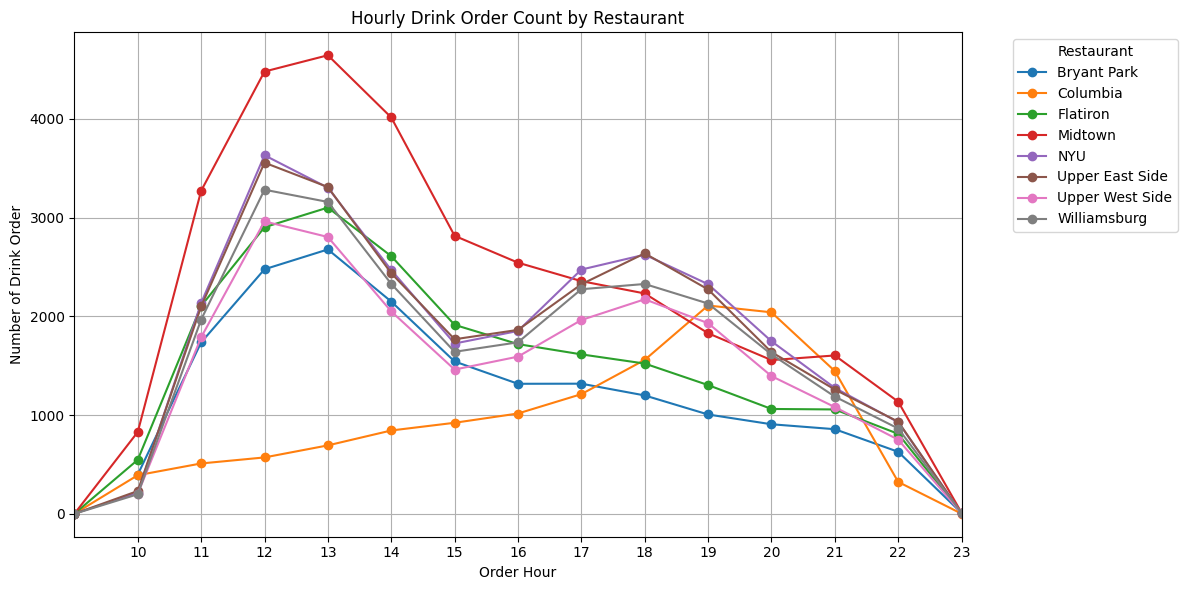

In [ ]:
# Pivot the data: rows = ORDER_HOUR, columns = RESTAURANT_NAME, values = COUNT_WITH_DRINK
df_pivot = hourly_orders.pivot(index='ORDER_HOUR', columns='RESTAURANT_NAME', values='COUNT_WITH_DRINK')

# Create figure and axes with custom size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot on the specified axes
df_pivot.plot(marker='o', ax=ax)

# Titles and labels
ax.set_title('Hourly Drink Order Count by Restaurant')
ax.set_xlabel('Order Hour')
ax.set_ylabel('Number of Drink Order')
ax.set_xlim(9, 23)
ax.set_xticks(range(10, 24))  # Ensure x-axis shows 10 to 23

# Legend
ax.legend(title='Restaurant', bbox_to_anchor=(1.05, 1), loc='upper left')

# Layout and grid
plt.tight_layout()
ax.grid(True)

# Show the plot
plt.show()

### 3.4.5 Cookies

#### 3.4.5.1 All time

In [ ]:
# Group by restaurant and with / without cookies (Google, 2025)

df_orders_items_analysis = df_orders_7

df_orders_items_analysis['HAS_COOKIE'] = df_orders_items_analysis['COOKIES'] > 0
df_restaurant = df_orders_items_analysis.groupby('RESTAURANT_NAME').agg(
    COUNT_WITH_COOKIE=('HAS_COOKIE', 'sum'),  # counts True values = cookie orders
    TOTAL_RESTAURANT_ORDERS=('ORDER_ID', 'count') # Changed 'COUNT' to 'count'
).reset_index()

# Calculate the percentage
df_restaurant['COOKIES'] = 'With Cookies'
df_restaurant['PERCENTAGE'] = (df_restaurant['COUNT_WITH_COOKIE'] / df_restaurant['TOTAL_RESTAURANT_ORDERS']) * 100 # Use COUNT_WITH_COOKIE

# Add 'Without Drinks' row
df_restaurant_without_cookies = df_restaurant.copy()
df_restaurant_without_cookies['COUNT_WITH_COOKIE'] = df_restaurant_without_cookies['TOTAL_RESTAURANT_ORDERS'] - df_restaurant_without_cookies['COUNT_WITH_COOKIE'] # Use COUNT_WITH_COOKIE
df_restaurant_without_cookies['COOKIES'] = 'Without Cookies'
df_restaurant_without_cookies['PERCENTAGE'] = 100 - df_restaurant_without_cookies['PERCENTAGE']

# Combine the two dataframes
df_restaurant = pd.concat([df_restaurant, df_restaurant_without_cookies])
df_restaurant = df_restaurant.sort_values(by=['RESTAURANT_NAME'], ascending=False)

#df_restaurant['Without Drinks'] = 100 - df_restaurant['With Drinks']

# Separate by restaurant
df_restaurant_B = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Bryant Park']
df_restaurant_C = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Columbia']
df_restaurant_F = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Flatiron']
df_restaurant_M = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Midtown']
df_restaurant_N = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'NYU']
df_restaurant_UE = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Upper East Side']
df_restaurant_UW = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Upper West Side']
df_restaurant_W = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Williamsburg']

df_restaurant.head()

RESTAURANT_NAME  COUNT_WITH_COOKIE  TOTAL_RESTAURANT_ORDERS  \
7     Williamsburg              62759                   314674   
7     Williamsburg             251915                   314674   
6  Upper West Side              56246                   281186   
6  Upper West Side             224940                   281186   
5  Upper East Side              54618                   275001   

           COOKIES  PERCENTAGE  
7     With Cookies   19.944133  
7  Without Cookies   80.055867  
6     With Cookies   20.003130  
6  Without Cookies   79.996870  
5     With Cookies   19.861019

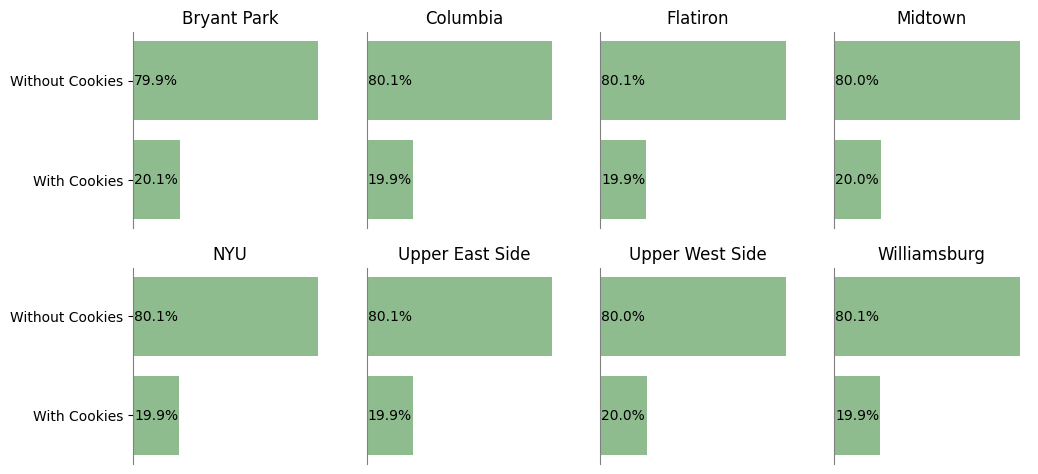

In [ ]:
# Plot by restaurant and with / without cookieks (Google, 2025)
title = 'Orders With and Without Cookies by Restaurant'
fig = plt.figure()

# Graph visual set (OpenAI, 2025)
ax1 = fig.add_subplot(241, title="Bryant Park")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])

ax2 = fig.add_subplot(242, title="Columbia")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax3 = fig.add_subplot(243, title="Flatiron")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax4 = fig.add_subplot(244, title="Midtown")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax5 = fig.add_subplot(245, title="NYU")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])

ax6 = fig.add_subplot(246, title="Upper East Side")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax7 = fig.add_subplot(247, title="Upper West Side")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax8 = fig.add_subplot(248, title="Williamsburg")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

# Format data labels (OpenAI, 2025)
df_ax1_label = (round(df_restaurant_B['PERCENTAGE'], 1)).astype(str) + '%'
df_ax2_label = (round(df_restaurant_C['PERCENTAGE'], 1)).astype(str) + '%'
df_ax3_label = (round(df_restaurant_F['PERCENTAGE'], 1)).astype(str) + '%'
df_ax4_label = (round(df_restaurant_M['PERCENTAGE'], 1)).astype(str) + '%'
df_ax5_label = (round(df_restaurant_N['PERCENTAGE'], 1)).astype(str) + '%'
df_ax6_label = (round(df_restaurant_UE['PERCENTAGE'], 1)).astype(str) + '%'
df_ax7_label = (round(df_restaurant_UW['PERCENTAGE'], 1)).astype(str) + '%'
df_ax8_label = (round(df_restaurant_W['PERCENTAGE'], 1)).astype(str) + '%'

# Plot and add datalabels (OpenAI, 2025)
plt.subplots_adjust(left=0.1, right=1.5, top=1, bottom=0.1)

ax1.barh(df_restaurant_B['COOKIES'], df_restaurant_B['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_B['PERCENTAGE']):
    ax1.text(0.5, i, df_ax1_label.values[i], va='center', color='black')

ax2.barh(df_restaurant_C['COOKIES'], df_restaurant_C['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_C['PERCENTAGE']):
    ax2.text(0.5, i, df_ax2_label.values[i], va='center', color='black')

ax3.barh(df_restaurant_F['COOKIES'], df_restaurant_F['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_F['PERCENTAGE']):
    ax3.text(0.5, i, df_ax3_label.values[i], va='center', color='black')

ax4.barh(df_restaurant_M['COOKIES'], df_restaurant_M['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_M['PERCENTAGE']):
    ax4.text(0.5, i, df_ax4_label.values[i], va='center', color='black')

ax5.barh(df_restaurant_N['COOKIES'], df_restaurant_N['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_N['PERCENTAGE']):
    ax5.text(0.5, i, df_ax5_label.values[i], va='center', color='black')

ax6.barh(df_restaurant_UE['COOKIES'], df_restaurant_UE['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_UE['PERCENTAGE']):
    ax6.text(0.5, i, df_ax6_label.values[i], va='center', color='black')

ax7.barh(df_restaurant_UW['COOKIES'], df_restaurant_UW['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_UW['PERCENTAGE']):
    ax7.text(0.5, i, df_ax7_label.values[i], va='center', color='black')

ax8.barh(df_restaurant_W['COOKIES'], df_restaurant_W['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_W['PERCENTAGE']):
    ax8.text(0.5, i, df_ax8_label.values[i], va='center', color='black')

#plt.savefig(title+'.png')
plt.show()

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

#### 3.4.5.2 By Month

In [ ]:
# Group by restaurant and cookie in month (Google, 2025)

df_orders_items_cookies = df_orders_items_analysis

df_orders_items_cookies['ORDER_MONTH'] = df_orders_items_cookies['DATETIME'].dt.month

df_orders_items_cookies['HAS_COOKIES'] = df_orders_items_cookies['COOKIES'] > 0
# Pass the grouping keys as a list to groupby()
monthly_orders = df_orders_items_cookies.groupby(['RESTAURANT_NAME', 'ORDER_MONTH']).agg(
    COUNT_WITH_COOKIE=('HAS_COOKIE', 'sum'),  # counts True values = drink orders
    TOTAL_RESTAURANT_ORDERS=('ORDER_ID', 'count') # Changed 'COUNT' to 'count'
).reset_index()

monthly_orders.head(15)

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME  ORDER_MONTH  COUNT_WITH_COOKIE  TOTAL_RESTAURANT_ORDERS
0      Bryant Park            1               3775                    18607
1      Bryant Park            2               3445                    17289
2      Bryant Park            3               3874                    19368
3      Bryant Park            4               3696                    18474
4      Bryant Park            5               4102                    20234
5      Bryant Park            6               3786                    18413
6      Bryant Park            7               3605                    17836
7      Bryant Park            8               3860                    18734
8      Bryant Park            9               3453                    17381
9      Bryant Park           10               4318                    21548
10     Bryant Park           11               3780                    19130
11     Bryant Park           12               4014                    20431
12        Columbia            1               4007                    20296
13        Columbia            2               4465                    21842
14        Columbia            3               4721                    23914

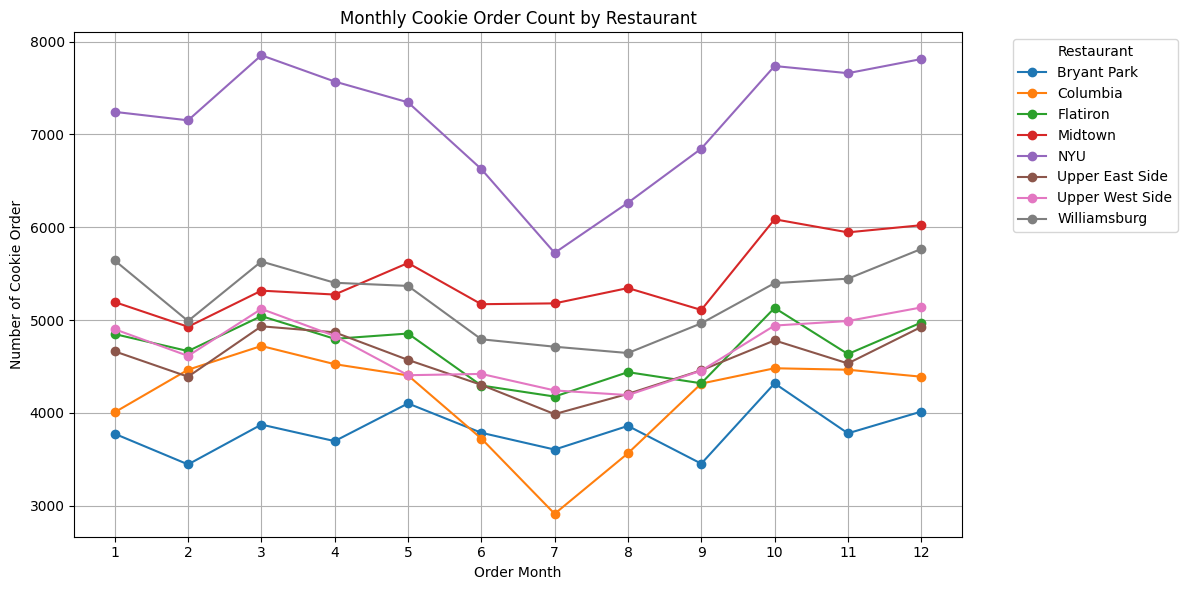

In [ ]:
# Set the figure size (width, height) in inches
df_pivot = monthly_orders.pivot(index='ORDER_MONTH', columns='RESTAURANT_NAME', values='COUNT_WITH_COOKIE')
fig, ax = plt.subplots(figsize=(12, 6))  # You can adjust 12 and 6 as needed

# Plot the pivot table on the axes
df_pivot.plot(marker='o', ax=ax)

# Set titles and labels
ax.set_title('Monthly Cookie Order Count by Restaurant')
ax.set_xlabel('Order Month')
ax.set_ylabel('Number of Cookie Order')
ax.set_xticks(range(1, 13))  # Ensure x-axis shows months 1 to 12

# Legend positioning
ax.legend(title='Restaurant', bbox_to_anchor=(1.05, 1), loc='upper left')

# Layout and grid
plt.tight_layout()
ax.grid(True)

# Show the plot
plt.show()

#### 3.4.5.3 By Hour

In [ ]:
# Group by restaurant and cookie in hour (Google, 2025)

df_orders_items_cookies = df_orders_items_analysis

df_orders_items_cookies['ORDER_HOUR'] = df_orders_items_cookies['DATETIME'].dt.hour

df_orders_items_cookies['HAS_COOKIES'] = df_orders_items_cookies['COOKIES'] > 0
# Pass the grouping keys as a list to groupby()
hourly_orders = df_orders_items_cookies.groupby(['RESTAURANT_NAME', 'ORDER_HOUR']).agg(
    COUNT_WITH_COOKIE=('HAS_COOKIE', 'sum'),  # counts True values = drink orders
    TOTAL_RESTAURANT_ORDERS=('ORDER_ID', 'count') # Changed 'COUNT' to 'count'
).reset_index()

hourly_orders.head(15)

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME  ORDER_HOUR  COUNT_WITH_COOKIE  TOTAL_RESTAURANT_ORDERS
0      Bryant Park          10               1125                     5581
1      Bryant Park          11               4420                    22289
2      Bryant Park          12               6368                    31444
3      Bryant Park          13               6422                    31442
4      Bryant Park          14               5318                    26484
5      Bryant Park          15               3773                    18848
6      Bryant Park          16               3372                    16577
7      Bryant Park          17               3167                    15844
8      Bryant Park          18               3047                    15126
9      Bryant Park          19               2526                    12724
10     Bryant Park          20               2180                    11347
11     Bryant Park          21               2185                    11233
12     Bryant Park          22               1792                     8428
13     Bryant Park          23                 13                       78
14        Columbia           9                  1                        2

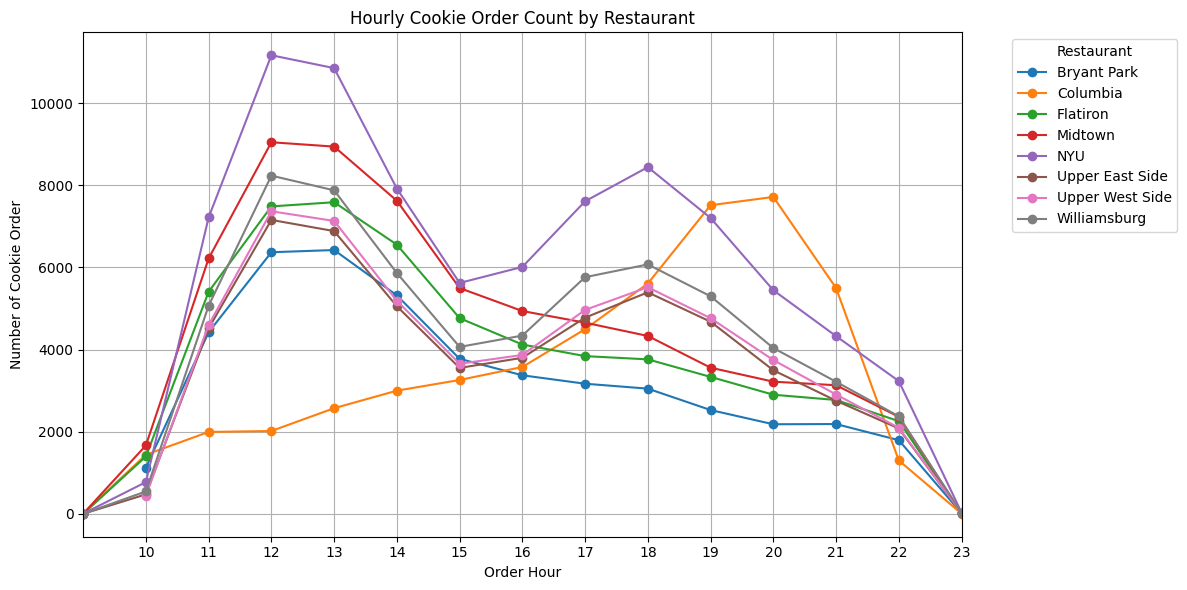

In [ ]:
# Pivot the data: rows = ORDER_HOUR, columns = RESTAURANT_NAME, values = COUNT_WITH_DRINK
df_pivot = hourly_orders.pivot(index='ORDER_HOUR', columns='RESTAURANT_NAME', values='COUNT_WITH_COOKIE')

# Create figure and axes with custom size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot on the specified axes
df_pivot.plot(marker='o', ax=ax)

# Titles and labels
ax.set_title('Hourly Cookie Order Count by Restaurant')
ax.set_xlabel('Order Hour')
ax.set_ylabel('Number of Cookie Order')
ax.set_xlim(9, 23)
ax.set_xticks(range(10, 24))  # Ensure x-axis shows 10 to 23

# Legend
ax.legend(title='Restaurant', bbox_to_anchor=(1.05, 1), loc='upper left')

# Layout and grid
plt.tight_layout()
ax.grid(True)

# Show the plot
plt.show()

### 3.4.6 Combo

In [ ]:
# Group by restaurant and combos (Google, 2025)

df_orders_items_analysis = df_orders_7

# Add ID
combo_id = {'Herb Roasted Chicken Marketbowl + Farro with Summer Vegetables + Cauliflower with Garlic and Parmesan + Roasted Sweet Potatoes':1,
            'Spicy Meatballs Marketbowl + Farm Greens with Mint + Snap Peas + Snap Peas':2,
            'Spicy Meatballs Marketbowl + Farm Greens with Mint + Roasted Sweet Potatoes + Snap Peas':3,
            'Spicy Meatballs Marketbowl + Farro with Summer Vegetables + Snap Peas + Snap Peas':4,
            'Herb Roasted Chicken Marketbowl + Farm Greens with Mint + Roasted Sweet Potatoes + Roasted Sweet Potatoes':5,
            'Others':6}

df_orders_items_analysis['COMBO_ID'] = df_orders_items_analysis['COMBO'].map(combo_id)
df_orders_items_analysis['COMBO_ID'] = df_orders_items_analysis['COMBO_ID'].fillna(6).astype(int)
df_orders_items_analysis.loc[df_orders_items_analysis['COMBO_ID'] == 6, 'COMBO'] = 'Others'

# Group by restaurant and main (Google, 2025)
df_restaurant = df_orders_items_analysis.groupby(['RESTAURANT_NAME','COMBO','COMBO_ID']).size()
df_restaurant = df_restaurant.reset_index()
df_restaurant.columns = ['RESTAURANT_NAME','ITEM_NAME', 'ITEM_ID', 'COUNT']
df_restaurant = df_restaurant.sort_values(by=['RESTAURANT_NAME','ITEM_ID'], ascending=False)

# Calculate total orders per restaurant
total_orders_per_restaurant = df_restaurant.groupby('RESTAURANT_NAME')['COUNT'].sum().reset_index(name='TOTAL_RESTAURANT_ORDERS')
total_orders_per_restaurant.columns = ['RESTAURANT_NAME', 'TOTAL_RESTAURANT_ORDERS']

# Merge the total orders back to the main_restaurant dataframe
df_restaurant = pd.merge(df_restaurant, total_orders_per_restaurant, on='RESTAURANT_NAME')

# Calculate the percentage
df_restaurant['PERCENTAGE'] = (df_restaurant['COUNT'] / df_restaurant['TOTAL_RESTAURANT_ORDERS']) * 100

# Separate by restaurant
df_restaurant_B = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Bryant Park']
df_restaurant_C = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Columbia']
df_restaurant_F = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Flatiron']
df_restaurant_M = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Midtown']
df_restaurant_N = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'NYU']
df_restaurant_UE = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Upper East Side']
df_restaurant_UW = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Upper West Side']
df_restaurant_W = df_restaurant[df_restaurant['RESTAURANT_NAME'] == 'Williamsburg']

df_restaurant.head(10)

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

RESTAURANT_NAME  \
0     Williamsburg   
1     Williamsburg   
2     Williamsburg   
3     Williamsburg   
4     Williamsburg   
5     Williamsburg   
6  Upper West Side   
7  Upper West Side   
8  Upper West Side   
9  Upper West Side   

                                                                                                                        ITEM_NAME  \
0                                                                                                                          Others   
1                       Herb Roasted Chicken Marketbowl + Farm Greens with Mint + Roasted Sweet Potatoes + Roasted Sweet Potatoes   
2                                               Spicy Meatballs Marketbowl + Farro with Summer Vegetables + Snap Peas + Snap Peas   
3                                         Spicy Meatballs Marketbowl + Farm Greens with Mint + Roasted Sweet Potatoes + Snap Peas   
4                                                      Spicy Meatballs Marketbowl + Farm Greens with Mint + Snap Peas + Snap Peas   
5  Herb Roasted Chicken Marketbowl + Farro with Summer Vegetables + Cauliflower with Garlic and Parmesan + Roasted Sweet Potatoes   
6                                                                                                                          Others   
7                       Herb Roasted Chicken Marketbowl + Farm Greens with Mint + Roasted Sweet Potatoes + Roasted Sweet Potatoes   
8                                               Spicy Meatballs Marketbowl + Farro with Summer Vegetables + Snap Peas + Snap Peas   
9                                         Spicy Meatballs Marketbowl + Farm Greens with Mint + Roasted Sweet Potatoes + Snap Peas   

   ITEM_ID   COUNT  TOTAL_RESTAURANT_ORDERS  PERCENTAGE  
0        6  290546                   314674   92.332382  
1        5    4079                   314674    1.296262  
2        4    4194                   314674    1.332808  
3        3    4960                   314674    1.576234  
4        2    5193                   314674    1.650279  
5        1    5702                   314674    1.812034  
6        6  259496                   281186   92.286245  
7        5    3675                   281186    1.306964  
8        4    3655                   281186    1.299851  
9        3    4526                   281186    1.609611

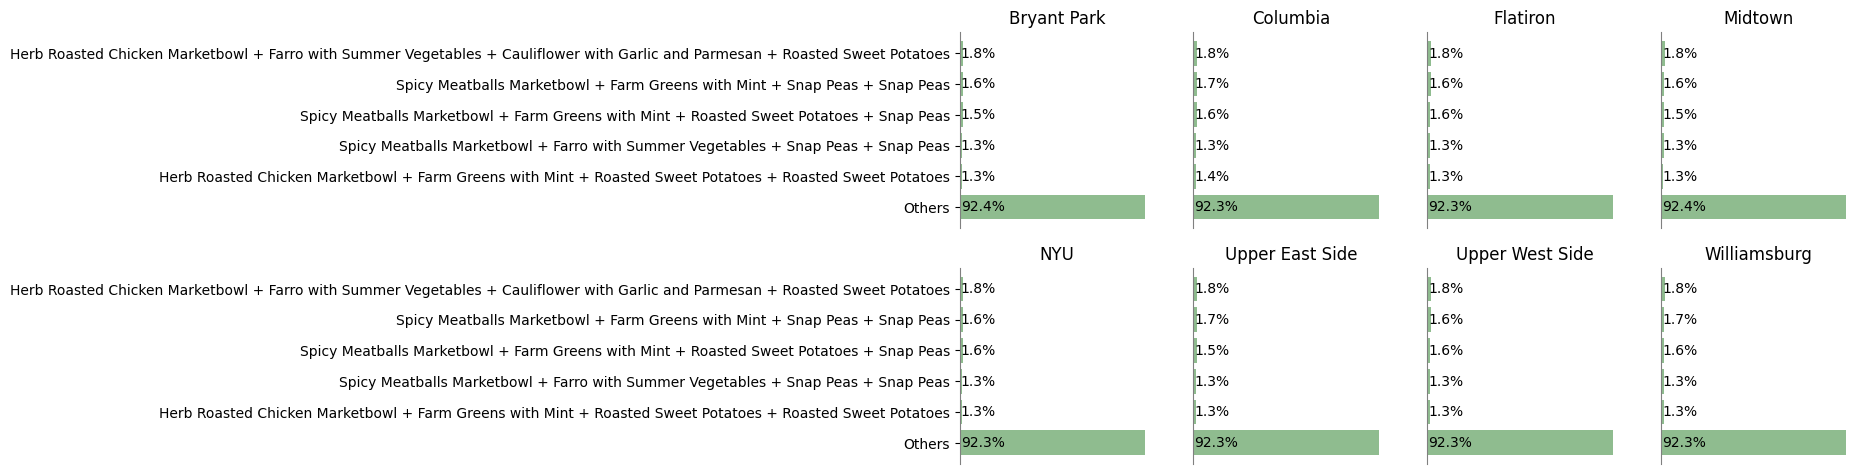

In [ ]:
# Plot by restaurant and combo (Google, 2025)
title = 'Combo Popularity by Restaurant'
fig = plt.figure()

# Graph visual set (OpenAI, 2025)
ax1 = fig.add_subplot(241, title="Bryant Park")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])

ax2 = fig.add_subplot(242, title="Columbia")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax3 = fig.add_subplot(243, title="Flatiron")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax4 = fig.add_subplot(244, title="Midtown")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax5 = fig.add_subplot(245, title="NYU")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])

ax6 = fig.add_subplot(246, title="Upper East Side")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax7 = fig.add_subplot(247, title="Upper West Side")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

ax8 = fig.add_subplot(248, title="Williamsburg")
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['left'].set_color('gray')
plt.xticks([])
plt.yticks([])

# Format data labels (OpenAI, 2025)
df_ax1_label = (round(df_restaurant_B['PERCENTAGE'], 1)).astype(str) + '%'
df_ax2_label = (round(df_restaurant_C['PERCENTAGE'], 1)).astype(str) + '%'
df_ax3_label = (round(df_restaurant_F['PERCENTAGE'], 1)).astype(str) + '%'
df_ax4_label = (round(df_restaurant_M['PERCENTAGE'], 1)).astype(str) + '%'
df_ax5_label = (round(df_restaurant_N['PERCENTAGE'], 1)).astype(str) + '%'
df_ax6_label = (round(df_restaurant_UE['PERCENTAGE'], 1)).astype(str) + '%'
df_ax7_label = (round(df_restaurant_UW['PERCENTAGE'], 1)).astype(str) + '%'
df_ax8_label = (round(df_restaurant_W['PERCENTAGE'], 1)).astype(str) + '%'

# Plot and add datalabels (OpenAI, 2025)
plt.subplots_adjust(left=0.1, right=1.5, top=1, bottom=0.1)

ax1.barh(df_restaurant_B['ITEM_NAME'], df_restaurant_B['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_B['PERCENTAGE']):
    ax1.text(0.5, i, df_ax1_label.values[i], va='center', color='black')

ax2.barh(df_restaurant_C['ITEM_NAME'], df_restaurant_C['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_C['PERCENTAGE']):
    ax2.text(0.5, i, df_ax2_label.values[i], va='center', color='black')

ax3.barh(df_restaurant_F['ITEM_NAME'], df_restaurant_F['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_F['PERCENTAGE']):
    ax3.text(0.5, i, df_ax3_label.values[i], va='center', color='black')

ax4.barh(df_restaurant_M['ITEM_NAME'], df_restaurant_M['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_M['PERCENTAGE']):
    ax4.text(0.5, i, df_ax4_label.values[i], va='center', color='black')

ax5.barh(df_restaurant_N['ITEM_NAME'], df_restaurant_N['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_N['PERCENTAGE']):
    ax5.text(0.5, i, df_ax5_label.values[i], va='center', color='black')

ax6.barh(df_restaurant_UE['ITEM_NAME'], df_restaurant_UE['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_UE['PERCENTAGE']):
    ax6.text(0.5, i, df_ax6_label.values[i], va='center', color='black')

ax7.barh(df_restaurant_UW['ITEM_NAME'], df_restaurant_UW['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_UW['PERCENTAGE']):
    ax7.text(0.5, i, df_ax7_label.values[i], va='center', color='black')

ax8.barh(df_restaurant_W['ITEM_NAME'], df_restaurant_W['PERCENTAGE'], color=barh_color)
for i, v in enumerate(df_restaurant_W['PERCENTAGE']):
    ax8.text(0.5, i, df_ax8_label.values[i], va='center', color='black')

#plt.savefig(title+'.png')
plt.show()

## Reference
# Google. (2025). Gemini (May 19 version) [Large language model].

# 5. References

In [ ]:
# DataCamp. (n.d.). Intermediate Python.
# Google. (2025). Gemini (May 17 version) [Large language model].
# OpenAI. (2025). ChatGPT 4o (May 17 version) [Large language model].
# Vasilev. E. (n.d.). Heatmap of pubs and bars of New York City [Computer software]. Kaggle. https://www.kaggle.com/code/somesnm/heatmap-of-pubs-and-bars-of-new-york-city
# Vasilev. E. (n.d.). 2016 Parties in New York [Data set]. Kaggle. https://www.kaggle.com/datasets/somesnm/partynyc

